<a href="https://colab.research.google.com/github/gh0st-kid/TimeSeries_Analysis_and_Forecasting/blob/main/TS_model_RNN(q).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.6 MB/s eta 0:00:00


In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import (train_test_split, TimeSeriesSplit,
                                     cross_val_score)
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
import logging

In [ ]:
warnings.filterwarnings("ignore")
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [ ]:
def check_versions():
  print(f'Pandas версия: {pd.__version__}')
  print(f'Numpy версия: {np.__version__}')
  print(f'Matplotlib версия: {plt.matplotlib.__version__}')
  print(f'Seaborn версия: {sns.__version__}')
  print(f'Scikit-learn версия: {sklearn.__version__}')
  print(f'Tensorflow версия: {tf.__version__}')
  print(f'Библиотеки успешно импортированы.')

check_versions()

Pandas версия: 2.2.2
Numpy версия: 1.26.4
Matplotlib версия: 3.7.1
Seaborn версия: 0.13.2
Scikit-learn версия: 1.5.2
Tensorflow версия: 2.17.0
Библиотеки успешно импортированы.


In [ ]:
# Фиксация для воспроизводимости
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Детерминированные операции в TensorFlow

In [ ]:
def load_and_prepare_data(file_path):
  """
  Загружает и подготавливает данные из CSV файла.

  Аргументы:
  file_path : str
      Путь к CSV файлу с данными.

  Возвращает:
  pandas.DataFrame
      Подготовленный датафрейм с данными, где:
    - Удалены пробелы из названий столбцов.
    - Столбец 'year' преобразован в кварталы и удалён.
    - Все числовые столбцы преобразованы в тип float.
    - Данные отсортированы по кварталу.
  """
  df = pd.read_csv(file_path, delimiter=',')
  df.columns = df.columns.str.strip()
  df['year'] = pd.to_datetime(df['year'], format='%m/%d/%Y')
  df['quarter'] = df['year'].dt.to_period('Q')
  numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
  df[numeric_columns] = df[numeric_columns].astype(float)
  df.sort_values('quarter', inplace=True)
  df.drop(columns=['year'], inplace=True)
  df.set_index('quarter', inplace=True)
  df.index = df.index.to_timestamp()
  return df

df = load_and_prepare_data('/content/df.csv')

In [ ]:
df.head(10)

zan(cfo)  zan(szfo)  zan(ufo)  zan(skfo)  zan(pfo)  zan(uralfo)  \
quarter                                                                       
2010-01-01   19402.5     7169.8    6260.5     3433.2   14150.9       5872.8   
2010-04-01   19675.6     7175.0    6532.1     3714.1   14762.3       5988.3   
2010-07-01   19895.0     7257.4    6588.1     3703.4   14957.0       6077.4   
2010-10-01   19892.0     7149.9    6374.2     3703.8   14787.7       6081.8   
2011-01-01   19722.3     7204.1    6415.3     3670.4   14396.5       6008.9   
2011-04-01   19974.6     7260.7    6474.7     3832.3   14809.1       6141.6   
2011-07-01   20342.7     7347.3    6605.1     3901.0   15057.5       6170.0   
2011-10-01   20188.0     7309.3    6452.0     3762.0   14940.3       6088.5   
2012-01-01   20106.7     7274.9    6406.9     3732.5   14458.1       6041.3   
2012-04-01   20412.4     7403.4    6647.0     3950.9   14939.3       6195.2   

            zan(sfo)  zan(dfo)  bezr(cfo)  bezr(szfo)  ...  bezr(sfo)  \
quarter                                                ...              
2010-01-01    8821.8    3049.5     1143.2       524.3  ...     1018.8   
2010-04-01    9167.9    3125.1      944.4       443.9  ...      894.2   
2010-07-01    9461.4    3232.5      900.3       415.4  ...      779.5   
2010-10-01    9110.5    3161.3      855.2       427.5  ...      786.9   
2011-01-01    8923.6    3163.7      943.6       475.3  ...      869.3   
2011-04-01    9166.9    3198.5      836.4       372.5  ...      836.5   
2011-07-01    9315.7    3248.7      828.8       362.3  ...      768.8   
2011-10-01    9127.4    3207.8      821.5       354.6  ...      748.3   
2012-01-01    8898.5    3156.9      784.2       352.1  ...      740.8   
2012-04-01    9190.2    3202.6      641.5       293.2  ...      695.1   

            bezr(dfo)  srd(cfo)  srd(szfo)  srd(ufo)  srd(skfo)  srd(pfo)  \
quarter                                                                     
2010-01-01      354.1   20994.4    17568.0   12560.4    10168.8   13275.0   
2010-04-01      291.9   25046.3    20140.8   14287.9    12212.4   15659.0   
2010-07-01      248.2   23340.4    19058.9   15746.2    13841.7   15731.1   
2010-10-01      286.0   29517.9    22802.4   17856.1    17200.4   18629.5   
2011-01-01      293.1   22688.4    19065.0   14001.0    11427.8   14494.9   
2011-04-01      233.9   27060.0    21536.3   15696.5    13579.3   16737.6   
2011-07-01      238.5   25919.8    20866.1   17494.3    15845.5   17440.6   
2011-10-01      251.8   32849.0    23565.9   19222.4    19677.1   20433.5   
2012-01-01      262.7   24303.0    19997.0   14824.0    12986.0   16201.0   
2012-04-01      226.0   29537.0    24043.0   17166.0    15474.0   19122.0   

            srd(uralfo)  srd(sfo)  srd(dfo)  
quarter                                      
2010-01-01      19566.3   12770.6   17202.3  
2010-04-01      21734.1   14862.1   20543.2  
2010-07-01      21178.0   14817.9   20412.1  
2010-10-01      24847.0   17523.5   24927.0  
2011-01-01      20607.8   14291.7   18913.8  
2011-04-01      23583.6   16273.5   21702.1  
2011-07-01      23509.8   16274.1   22692.8  
2011-10-01      28153.3   19448.0   28099.1  
2012-01-01      22502.0   15772.0   19449.0  
2012-04-01      26152.0   18335.0   22873.0  

[10 rows x 24 columns]

In [ ]:
def prepare_data(df, series_name, split_time, window_size, batch_size,
                 shuffle_buffer):
  '''
  Подготавливает данные временного ряда для обучения модели.

  Аргументы:
      df : pandas.DataFrame
          Исходный датафрейм, содержащий временной ряд.
      series_name : str
          Название переменной(столбца) в датафрейме df для анализа.
      split_time : int
          Количество временных отсчётов, используемых для валидации.
      window_size : int
          Размер окна для создания последовательных образцов.
      batch_size : int
          Размер пакета для обучения модели.
      shuffle_buffer : int
          Размер буфера для перемешивания данных.

  Возвращает:
      time_valid : pandas.Index
          Индекс времени для валидационных данных.
      x_valid : numpy.ndarray
          Валидационный данные временного ряда.
      x_valid_prescale : numpy.ndarray
          Валидационные данные временного ряда(перед масштабированием).
      scaler : sklearn.preprocessing.MinMaxScaler
          Объект масштабирования данных.
      dataset : tf.data.Dataset
          Оконный датасет, подготовленный для обучения модели.
  '''
  series = df[series_name]
  time_train = series.index[:split_time]
  x_train = series.values[:split_time]
  time_valid = series.index[split_time:]
  x_valid = series.values[split_time:]

  x_train = x_train.reshape(-1, 1)
  x_valid = x_valid.reshape(-1, 1)
  x_valid_prescale = x_valid

  scaler = MinMaxScaler()
  scaler.fit(x_train)
  x_train = scaler.transform(x_train)
  x_valid = scaler.transform(x_valid)

  dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)

  return time_valid, x_valid, x_valid_prescale, scaler, dataset

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  '''
  Создает оконный датасет для обучения модели временного ряда.

  Аргументы:
      series : numpy.ndarray
          Временной ряд в виде массива NumPy.
      window_size : int
          Размер окна для создания последовательных образцов.
      batch_size : int
          Размер пакета для обучения модели.
      shuffle_buffer : int
          Размер буфера для перемешивания данных.

  Возвращает:
      tf.data.Dataset
          Оконный датасет, подготовленный для обучения модели.
  '''
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return(dataset)

In [ ]:
def build_model():
  '''
  Строит и компилирует модель для прогнозирования временных рядов.

  Возвращает:
      tf.keras.models.Sequential
          Построенная модель для прогнозирования временных рядов.
  '''
  model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                             input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(260,
                                                         return_sequences=True)),
      tf.keras.layers.Dropout(0.15),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(248)),
      tf.keras.layers.Dropout(0.05),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x*100.0)
  ])

  optimizer = tf.keras.optimizers.Adam()
  model.compile(loss = "mse", optimizer=optimizer, metrics=["mae"])

  return model

In [ ]:
def train_model(model, dataset, epochs):
  '''
  Обучает модель на заданном датасете.

  Аргументы:
      model : tf.keras.models.Model
          Модель для обучения.
      dataset : tf.data.Dataset
          Датасет для обучения модели.
      epochs : int
          Количество эпох обучения.


  Возвращает:
      tf.keras.callbacks.History
          История обучения модели.
  '''
  history = model.fit(dataset, epochs = epochs, verbose=1)
  return history

In [ ]:
def make_predictions(model, x_valid, scaler, window_size):
    '''
    Выполняет предсказания значений временного ряда на тестовых данных.

    Аргументы:
        model : tf.keras.models.Sequential
            Обученная модель для прогнозирования временных рядов.
        x_valid : numpy.ndarray
            Входные данные для предсказания.
        scaler : sklearn.preprocessing.MinMaxScaler
            Объект масштабирования, используемый для восстановления масштаба предсказаний.
        window_size : int
            Размер окна, использованный при подготовке данных.

    Возвращает:
        predictions : numpy.ndarray
            Предсказанные значения временного ряда в оригинальном масштабе.
    '''
    # Подготовка данных для предсказания
    n_samples = x_valid.shape[0]
    predictions = []

    for i in range(n_samples - window_size + 1):
        # Извлечение окна для предсказания
        window = x_valid[i:i + window_size].reshape(1, window_size, 1)
        # Выполнение предсказания
        pred = model.predict(window)
        predictions.append(pred[0][0])  # Сохраняем предсказанное значение

    # Преобразование предсказаний в numpy массив
    predictions = np.array(predictions).reshape(-1, 1)

    # Обратное преобразование для восстановления масштаба
    predictions = scaler.inverse_transform(predictions)

    return predictions.flatten()  # Возврат одномерного массива

In [ ]:
def evaluate_predictions(y_true, y_pred):
    '''
    Оценивает качество предсказаний с использованием метрик RMSE, MAE и MAPE.

    Аргументы:
        y_true : numpy.ndarray
            Истинные значения временного ряда.
        y_pred : numpy.ndarray
            Предсказанные значения временного ряда.

    Возвращает:
        metrics : dict
            Словарь с оценками RMSE, MAE и MAPE.
    '''

    # Преобразование в массивы NumPy для вычислений
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Вычисление RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    # Вычисление MAE
    mae = np.mean(np.abs(y_true - y_pred))

    # Вычисление MAPE
    # Избегаем деления на ноль, добавляя малое значение к y_true
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

    # Возврат метрик в виде словаря
    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

    return metrics

In [ ]:
def plot_predictions(time_valid, x_valid_prescale, predictions, window_size):
    '''
    Строит график временного ряда с истинными значениями и предсказанными
    значениями.

    Аргументы:
        time_valid : pandas.Index
            Индексы времени для тестовой выборки.
        x_valid_prescale : numpy.ndarray
            Истинные значения временного ряда в исходных величинах (до
            масштабирования).
        predictions : numpy.ndarray
            Предсказанные значения временного ряда в исходных величинах.
        window_size : int
            Размер окна, использованный при подготовке данных.
    '''
    plt.figure(figsize=(14, 8))

    # График истинных значений
    plt.plot(time_valid, x_valid_prescale, label='Истинные значения', color='b')

    # График предсказанных значений
    plt.plot(time_valid[window_size-1:], predictions,
             label='Предсказанные значения', color='r')

    # Настройки графика
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.title('Сравнение истинных и предсказанных значений временного ряда')
    plt.legend()
    plt.grid(True)

    # Показ графика
    plt.show()

In [ ]:
def rescale_forecast(scaler, forecast):
  '''
  Масштабирует прогнозируемые значения обратно к оригинальному масштабу.

  Аргументы:
      scaler : sklearn.preprocessing.MinMaxScaler
          Объект масштабирования данных.
      forecast : list
          Прогнозируемые значения временного ряда.

  Возвращает:
      numpy.ndarray
          Прогнозируемые значения в оригинальном масштабе.
  '''
  return scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

In [ ]:
def run_pipeline(df, series_name, split_time, window_size, batch_size,
                 shuffle_buffer, epochs):
    '''
    Запускает полный пайплайн обработки данных, обучения модели, предсказания
    и оценки качества.

    Аргументы:
        df : pandas.DataFrame
            Исходный датафрейм, содержащий временной ряд.
        series_name : str
            Название переменной (столбца) в датафрейме df для анализа.
        split_time : int
            Количество временных отсчётов, используемых для валидации.
        window_size : int
            Размер окна для создания последовательных образцов.
        batch_size : int
            Размер пакета для обучения модели.
        shuffle_buffer : int
            Размер буфера для перемешивания данных.
        epochs : int
            Количество эпох обучения модели.

    Возвращает:
        metrics : dict
            Словарь с метриками RMSE, MAE и MAPE для оценки модели.
    '''
    # 1. Подготовка данных
    time_valid, x_valid, x_valid_prescale, scaler, dataset = prepare_data(
        df, series_name, split_time, window_size, batch_size, shuffle_buffer)

    # 2. Построение и обучение модели
    model = build_model()
    history = train_model(model, dataset, epochs)

    # 3. Предсказание на тестовых данных
    predictions = make_predictions(model, x_valid, scaler, window_size)

    # 4. Оценка качества предсказаний
    metrics = evaluate_predictions(x_valid_prescale[window_size-1:], predictions)

    # 5. Визуализация результатов
    plot_predictions(time_valid, x_valid_prescale, predictions, window_size)

    # Возвращаем метрики для анализа
    return metrics

In [ ]:
run_pipeline(df,
                       series_name='srd(cfo)',
                       split_time=30,
                       window_size=10,
                       batch_size=32,
                       shuffle_buffer=10,
                       epochs=25)

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 2.0601 - mae: 1.3242
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step - loss: 1026.9170 - mae: 30.8302
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 135.3931 - mae: 11.2097
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 12.3132 - mae: 3.3665
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 153.2774 - mae: 11.9117
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 193.0223 - mae: 13.3872
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 137.1620 - mae: 11.2783
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 59.4004 - mae: 7.3877
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 10.4287 - mae: 3.0545
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 1.0528 - mae: 0.9543
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 19.7267 - mae: 4.3404
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 39.6530 - mae: 6.1220
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━

{'RMSE': 58166.462065236636,
 'MAE': 56722.078640407984,
 'MAPE': 112.35435091281633}

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 27.7785 - mae: 3.1453
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 8.7511 - mae: 2.7948
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 39.2841 - mae: 5.9185
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 16.6016 - mae: 3.5551
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.8231 - mae: 1.0065
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 12.3105 - mae: 3.3858
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 9.4692 - mae: 2.9267 
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.8376 - mae: 1.1841
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.7292 - mae: 0.7326
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 3.0935 - mae: 1.7031
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.8650 - mae: 1.8793
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 2.2778 - mae: 1.4162
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss

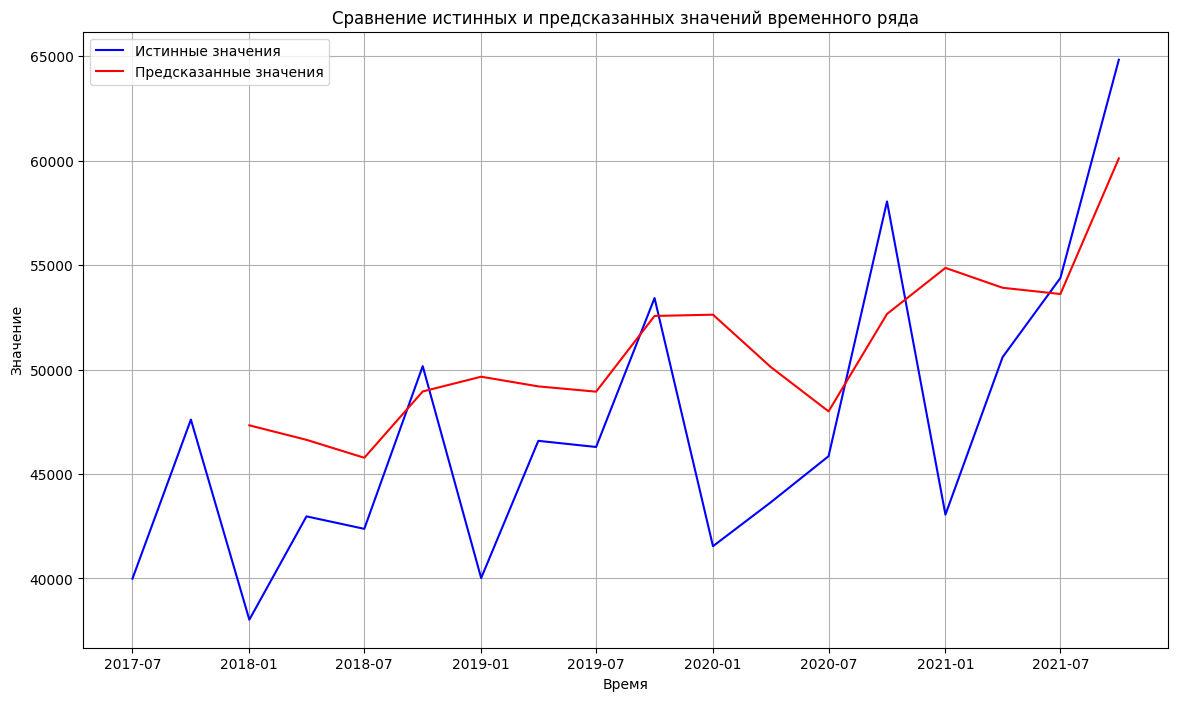

{'RMSE': 8509.691616784039, 'MAE': 7127.6259765625, 'MAPE': 15.532917060178189}

In [ ]:
run_pipeline(df,
                       series_name='srd(cfo)',
                       split_time=30,
                       window_size=3,
                       batch_size=16,
                       shuffle_buffer=1000,
                       epochs=25)

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 28.9167 - mae: 2.8900
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 7.9868 - mae: 2.6704 
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 29.7824 - mae: 5.1153
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 10.7687 - mae: 2.9277
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1.1170 - mae: 0.7881
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 9.7396 - mae: 3.0042
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 8.4114 - mae: 2.7738
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 1.8911 - mae: 1.2180
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3819 - mae: 0.5124
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.5877 - mae: 1.5348
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 3.4878 - mae: 1.8075
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.8817 - mae: 1.3145
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss:

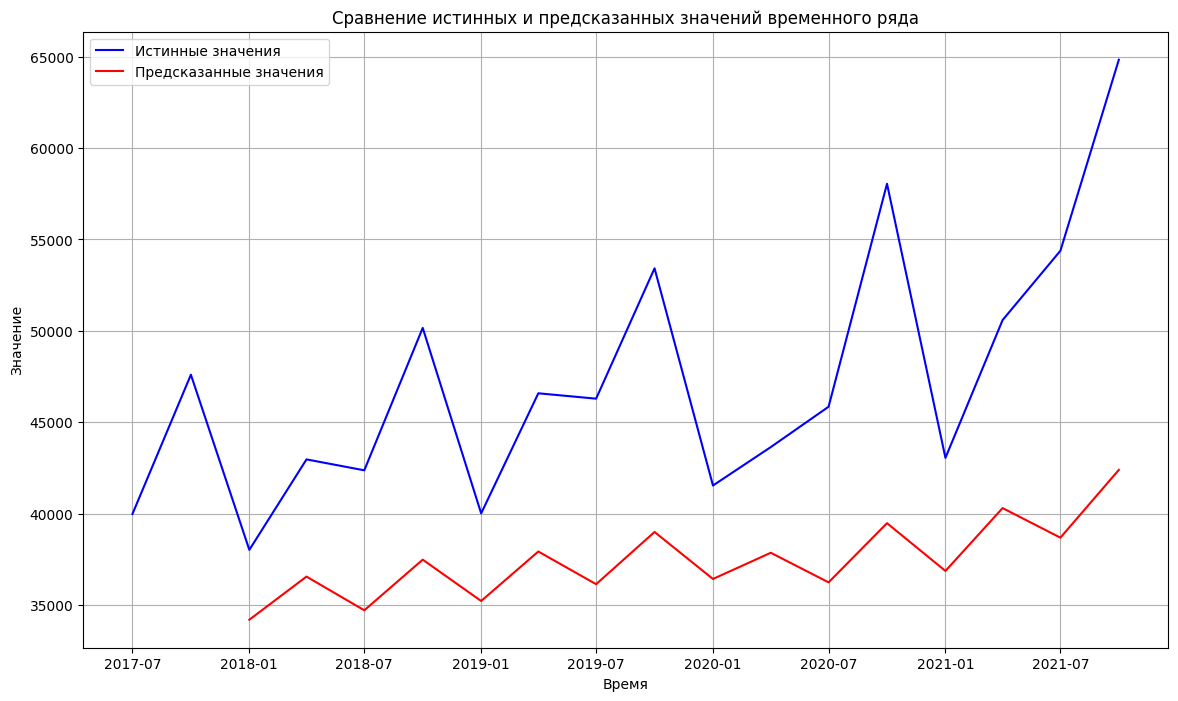

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 73.9922 - mae: 4.1311
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 27.9417 - mae: 4.9784
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 93.0712 - mae: 9.1464
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 35.9744 - mae: 5.3173
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 3.1576 - mae: 1.3650
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 22.2136 - mae: 4.5125
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 17.4777 - mae: 3.9533
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 3.9518 - mae: 1.7949
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.5172 - mae: 0.5395
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 4.5927 - mae: 2.0670
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 6.4595 - mae: 2.4769
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 4.0098 - mae: 1.9356
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/st

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - loss: 113.4849 - mae: 5.4695
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 45.0819 - mae: 6.3184
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 134.5842 - mae: 10.9925
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 61.5174 - mae: 7.3359
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 1.9720 - mae: 1.0627
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 25.2482 - mae: 4.8287
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 28.0412 - mae: 5.0772
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 7.3347 - mae: 2.5292
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.4492 - mae: 0.4855
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 5.6254 - mae: 2.2899
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 9.2843 - mae: 2.9767
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 6.5451 - mae: 2.4744
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - loss: 184.2837 - mae: 5.6857
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 80.6759 - mae: 8.5787
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 186.0736 - mae: 13.1820
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 119.3580 - mae: 10.4767
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 7.4144 - mae: 2.4827
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 30.9920 - mae: 5.4123
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 54.2492 - mae: 7.1810
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 20.7663 - mae: 4.3767
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 1.3049 - mae: 1.0380
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 4.6286 - mae: 2.0679
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 12.4129 - mae: 3.4563
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 13.2653 - mae: 3.5408
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 27.0051 - mae: 3.5016
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 6.8125 - mae: 2.4831
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 36.5604 - mae: 5.6819
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 10.1012 - mae: 2.8610
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.9782 - mae: 0.7371
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 8.9096 - mae: 2.8786
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 7.0778 - mae: 2.5199
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.3014 - mae: 0.9991
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.5508 - mae: 0.6294
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.0584 - mae: 1.6597
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 2.6417 - mae: 1.5635
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.9654 - mae: 0.9144
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss:

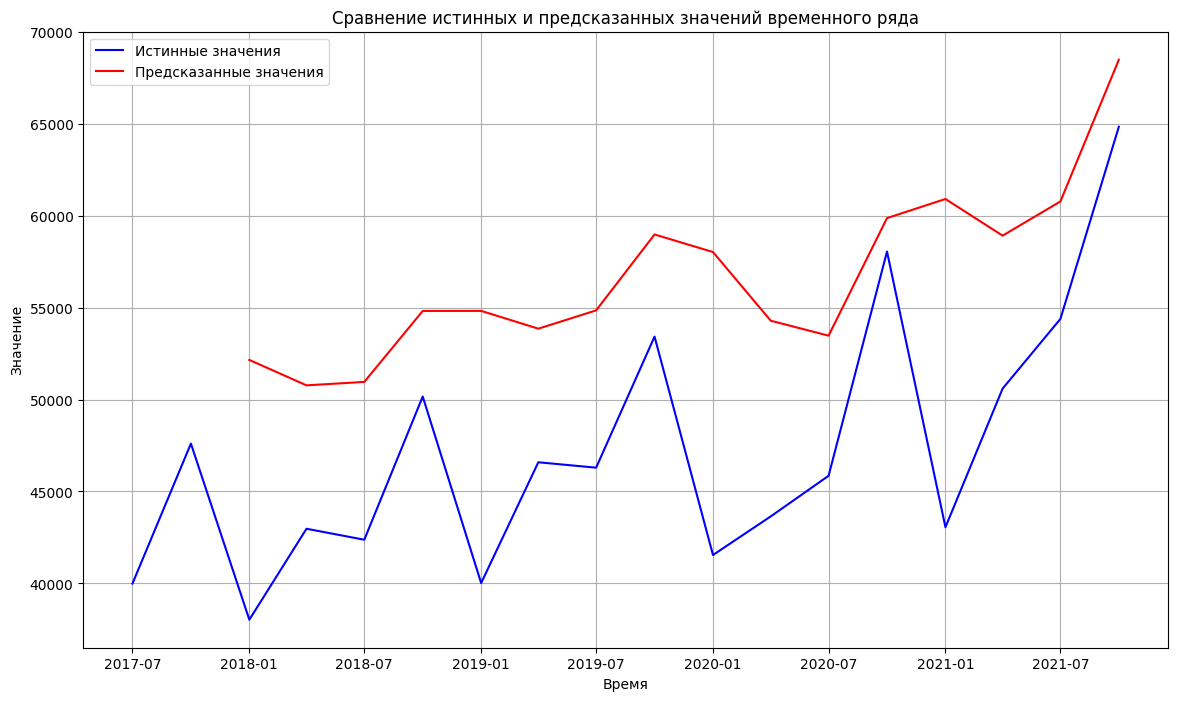

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 105.8841 - mae: 5.1114
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 27.4277 - mae: 4.9097
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 109.1351 - mae: 9.9558 
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 46.1106 - mae: 6.3830
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 1.8953 - mae: 1.2306
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 17.0412 - mae: 3.9594
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 24.3890 - mae: 4.7139
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 10.7827 - mae: 3.0763
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.5458 - mae: 0.6257
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 2.0129 - mae: 1.3295
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 5.8759 - mae: 2.3550
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 6.1527 - mae: 2.4127
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/st

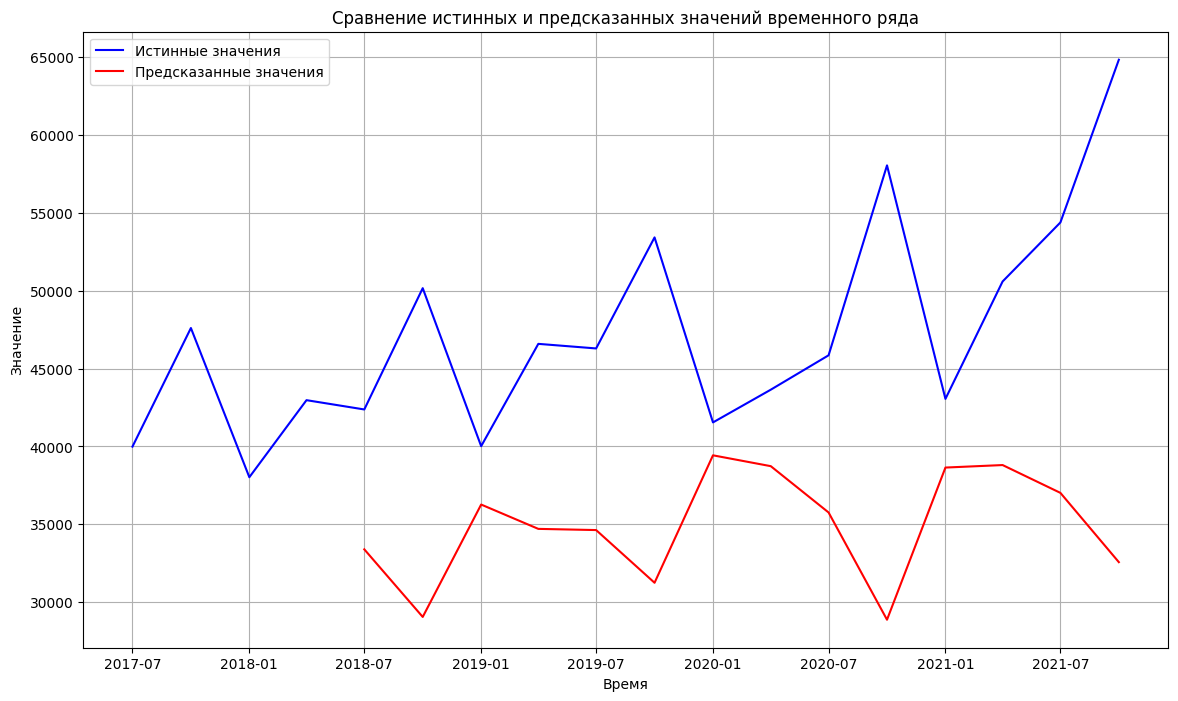

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 99.2032 - mae: 5.2214
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 45.4870 - mae: 6.4122
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 114.0011 - mae: 10.1813
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 46.3218 - mae: 6.3777
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 2.4219 - mae: 0.9084
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 20.8317 - mae: 4.3979
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 19.5508 - mae: 4.2175
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 4.8840 - mae: 1.9573
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 1.1608 - mae: 0.9466
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 6.6469 - mae: 2.4871
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 7.3959 - mae: 2.6355
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 3.1866 - mae: 1.7094
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99

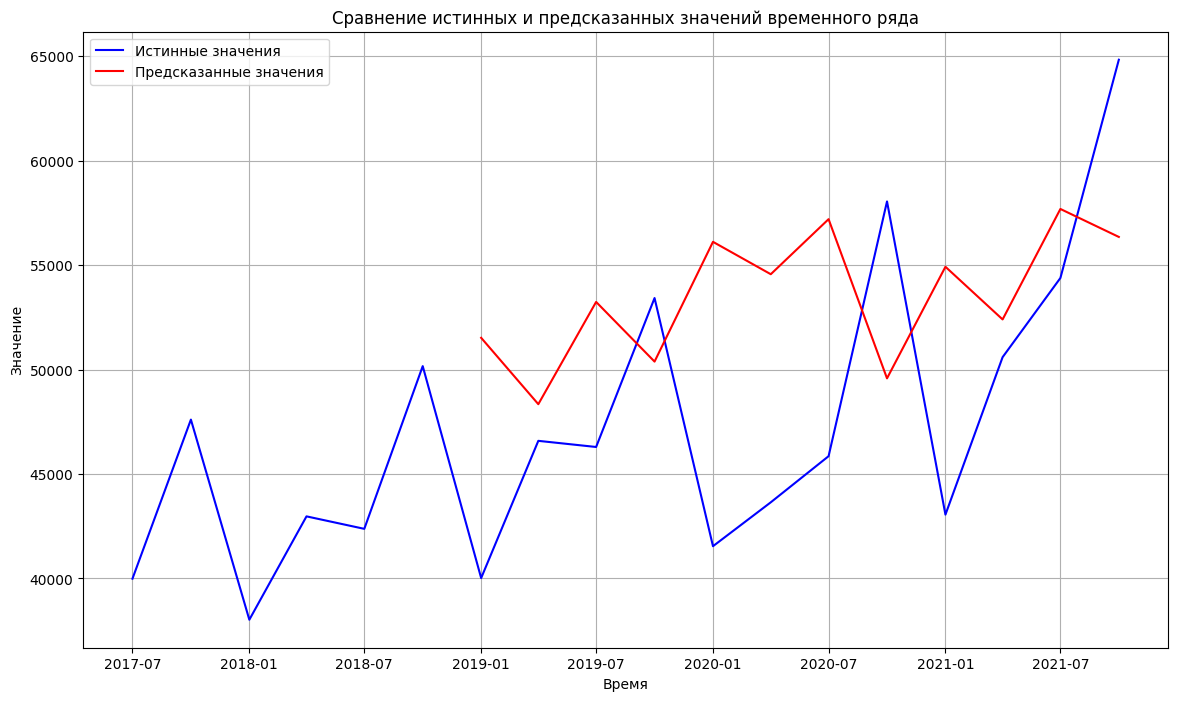

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 82.8423 - mae: 3.4221
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 39.8541 - mae: 4.9960
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 169.2268 - mae: 12.6583
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 8.4156 - mae: 2.8072
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 41.8964 - mae: 6.0980
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 47.4623 - mae: 6.4786
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 9.4030 - mae: 2.7805
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 1.1438 - mae: 0.9507
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 10.8489 - mae: 3.2521
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 14.0008 - mae: 3.6887
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 8.1652 - mae: 2.8156
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 1.9175 - mae: 1.3021
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 

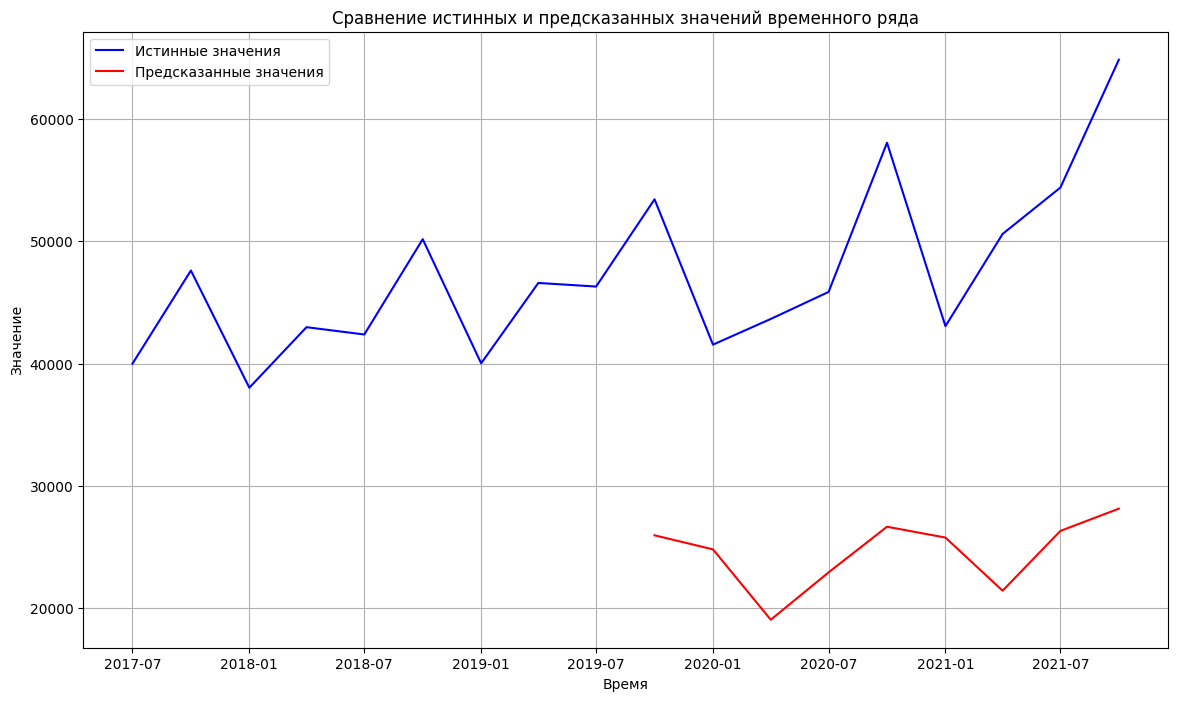

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - loss: 1.1844 - mae: 0.7276
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 17.7340 - mae: 3.7269
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 9.9094 - mae: 2.6564
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 2.5559 - mae: 1.3541
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 5.9010 - mae: 2.3794
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 2.3267 - mae: 1.3706
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.0466 - mae: 0.8448
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 2.8969 - mae: 1.5699
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.8851 - mae: 0.7618
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.5546 - mae: 0.6452
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 1.8412 - mae: 1.2442
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.6120 - mae: 0.6655
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - lo

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - loss: 113.0617 - mae: 5.4889
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 21.4577 - mae: 4.4209
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 100.2019 - mae: 9.4231
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 68.5607 - mae: 7.6024
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 6.7424 - mae: 2.1444
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 11.9382 - mae: 3.3218
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 27.3613 - mae: 5.1124
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 17.2679 - mae: 4.0270
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 3.2530 - mae: 1.6864
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.6841 - mae: 0.6322
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 4.6438 - mae: 2.0048
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 7.1459 - mae: 2.5326
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step -

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 159.7194 - mae: 6.1216
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 40.4055 - mae: 6.0759
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 126.1094 - mae: 10.6161
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 75.4244 - mae: 7.9885
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 3.6622 - mae: 1.6476
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 21.4135 - mae: 4.4996
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 32.7410 - mae: 5.5591
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 13.5716 - mae: 3.5378
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 1.0939 - mae: 0.9245
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 2.7273 - mae: 1.4836
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 7.2371 - mae: 2.5521
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 7.7688 - mae: 2.6493
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

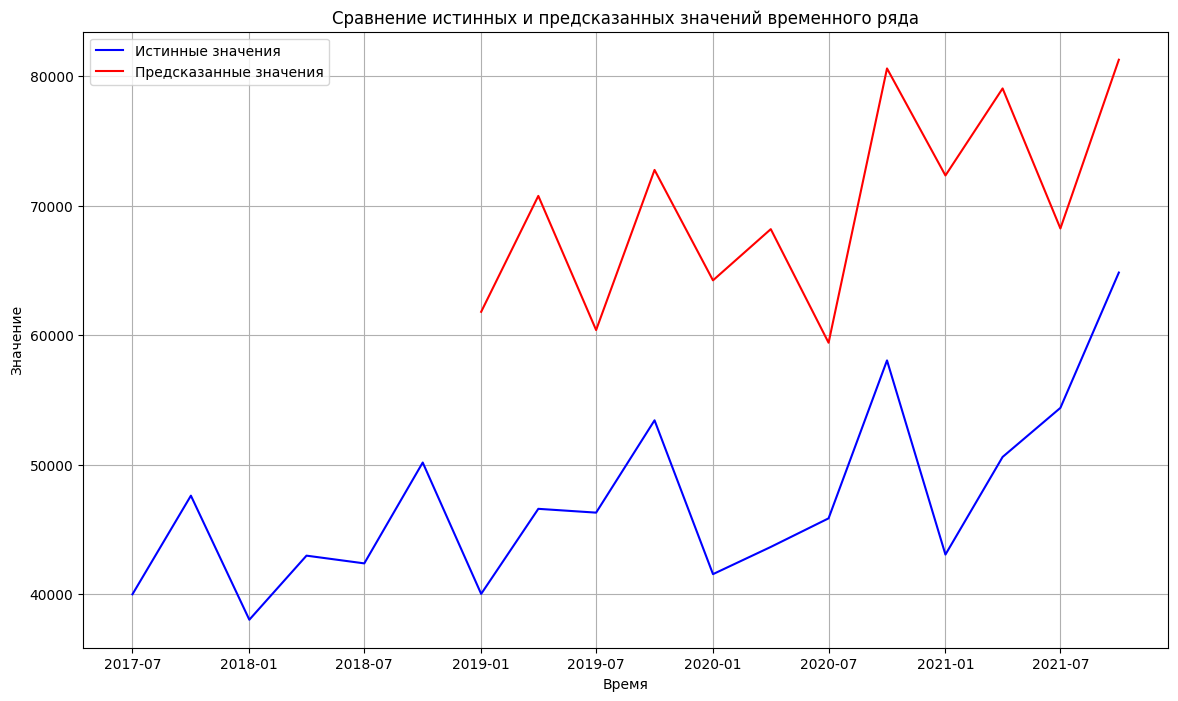

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - loss: 122.4714 - mae: 6.1714
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 86.4792 - mae: 8.8536
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 160.3455 - mae: 12.1933
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 82.8207 - mae: 8.6423
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 2.6778 - mae: 1.3475
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 32.8079 - mae: 5.5778
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 38.0411 - mae: 5.9582
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 9.4554 - mae: 2.9239
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.3205 - mae: 0.3749
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 6.5628 - mae: 2.4681
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 11.4225 - mae: 3.2613
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 8.8164 - mae: 2.8498
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

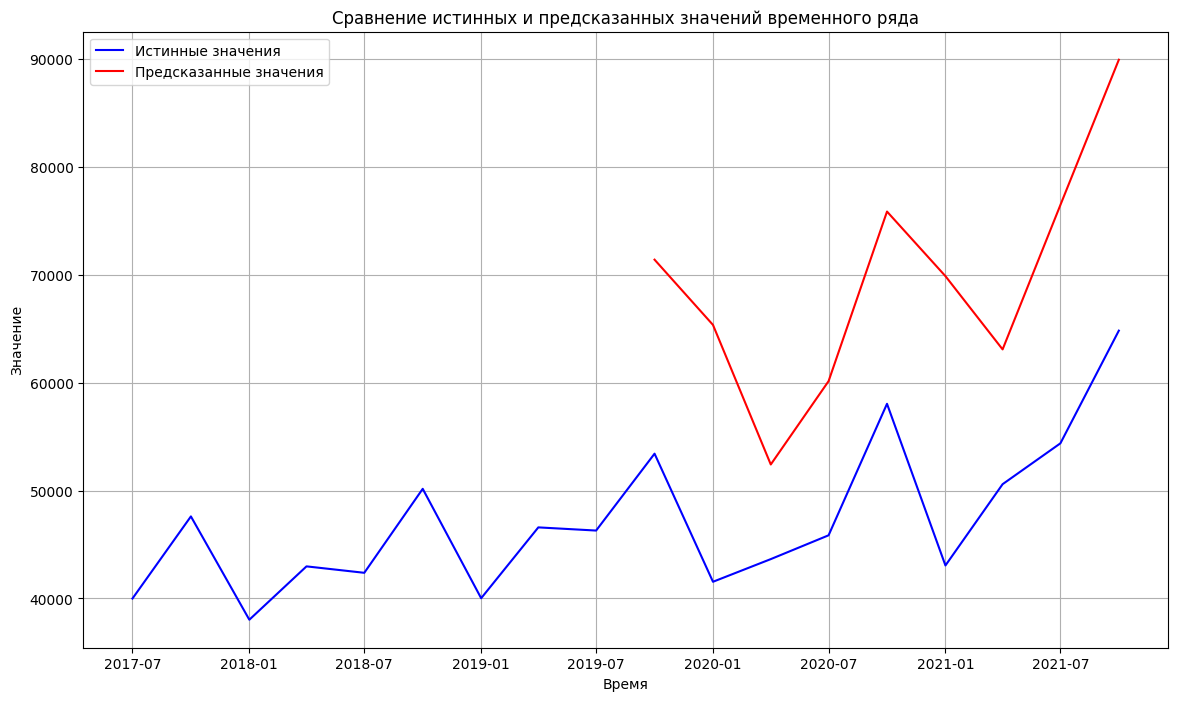

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 4.4471 - mae: 1.9147
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 85.3601 - mae: 8.7496
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 13.5593 - mae: 3.4779
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 2.6370 - mae: 1.4934
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 24.6500 - mae: 4.6567
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 30.8357 - mae: 5.1908
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 16.7299 - mae: 3.8233
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 4.7576 - mae: 1.9805
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0912 - mae: 0.2544
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 3.1409 - mae: 1.7135
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 8.1064 - mae: 2.7297
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 10.0748 - mae: 3.0373
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/

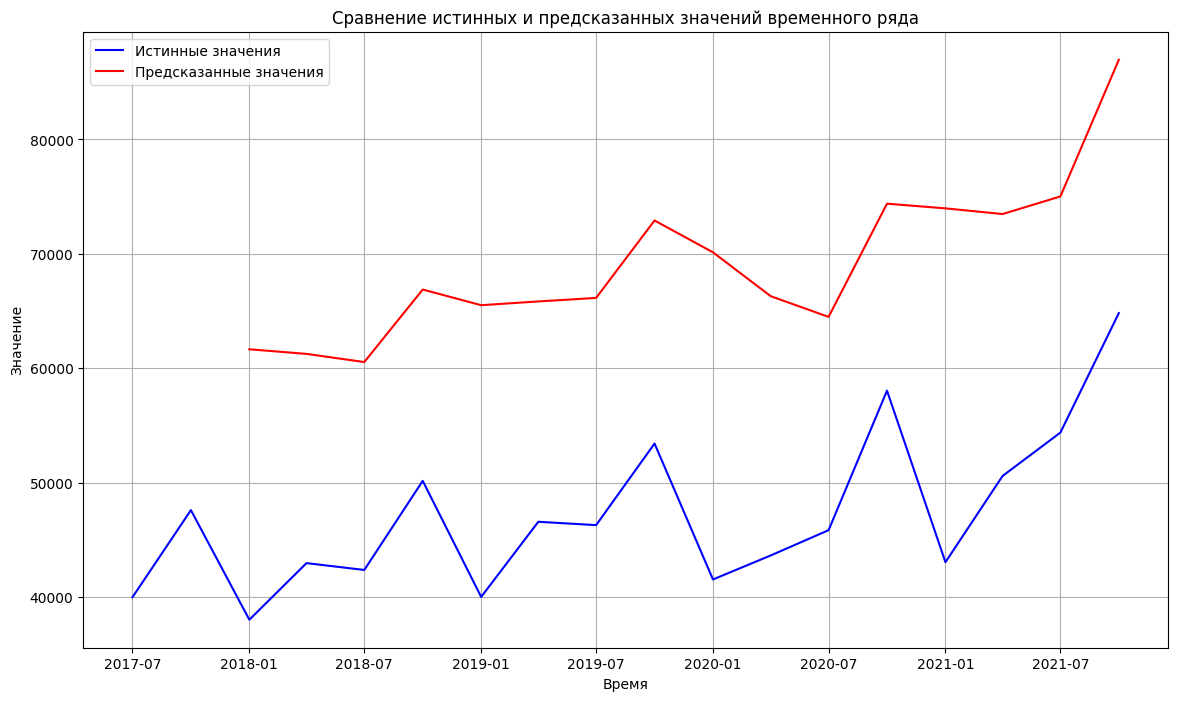

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.1768 - mae: 0.3387
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 327.4067 - mae: 17.1330
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 43.5966 - mae: 6.2458
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 12.2850 - mae: 3.3025
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 81.7827 - mae: 8.5255
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 97.0970 - mae: 9.2607
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 61.7787 - mae: 7.3806
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 23.0856 - mae: 4.4340
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 2.3233 - mae: 1.2957
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 2.1791 - mae: 1.4355
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 13.5027 - mae: 3.5509
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 22.3037 - mae: 4.5560
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

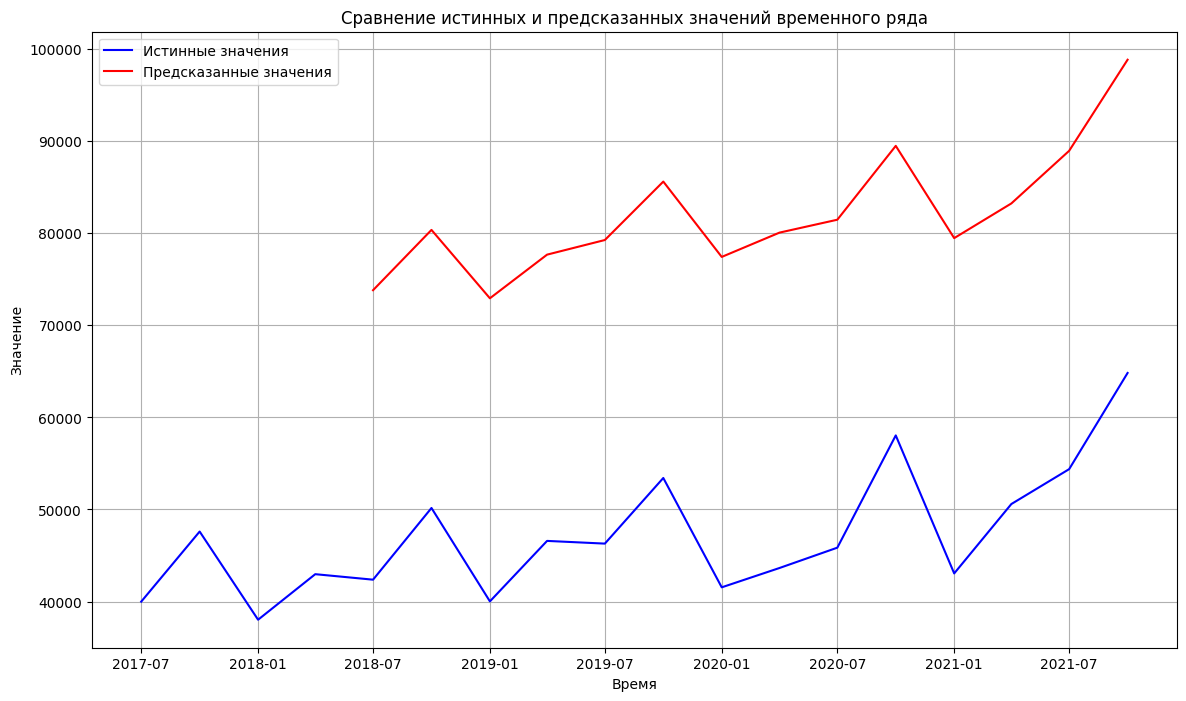

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 1.3665 - mae: 1.0506
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 572.0882 - mae: 22.7277
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 77.4054 - mae: 8.3462
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 15.0574 - mae: 3.7138
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 114.9430 - mae: 10.2409
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 142.8985 - mae: 11.3839
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 93.6360 - mae: 9.1717
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 39.2794 - mae: 5.9248
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 6.7302 - mae: 2.3907
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.8513 - mae: 0.8855
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 13.2896 - mae: 3.5353
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 26.8361 - mae: 4.9977
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 

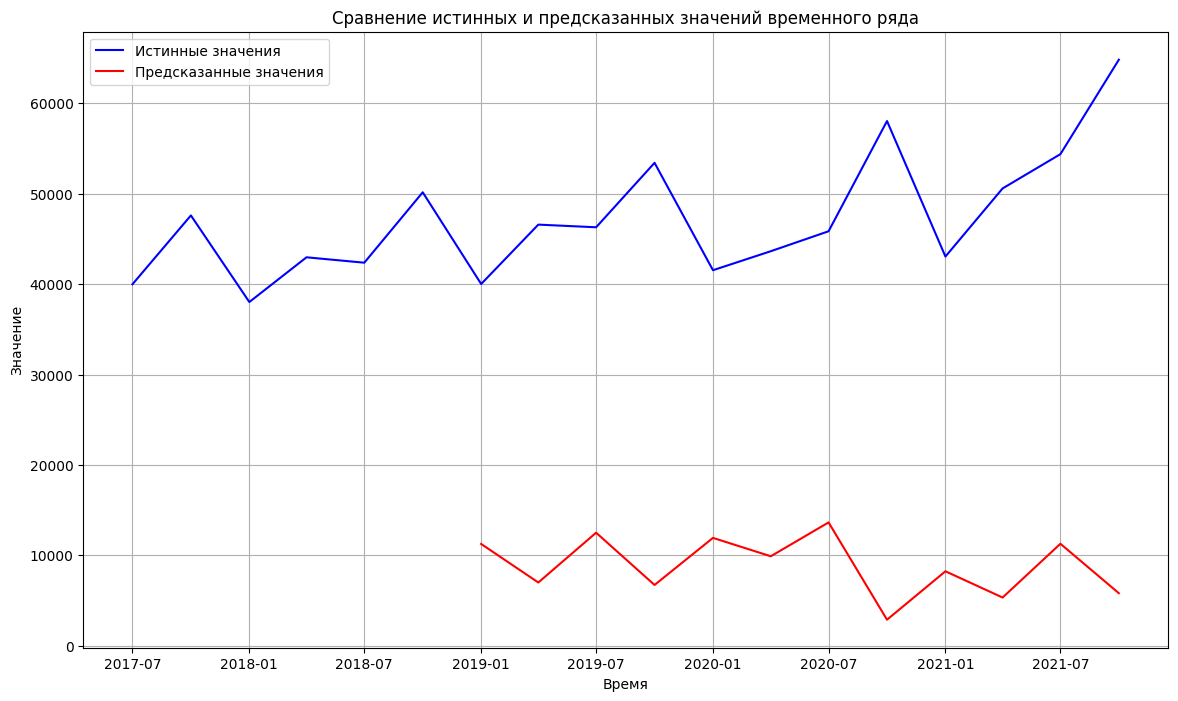

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 2.3145 - mae: 1.3889
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 1079.0959 - mae: 31.5180
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 146.3598 - mae: 11.5821
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 16.7989 - mae: 3.9698
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 172.8185 - mae: 12.7109
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 222.4541 - mae: 14.3497
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 144.3525 - mae: 11.5617
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 57.4694 - mae: 7.2766
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 9.0238 - mae: 2.8162
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 2.0018 - mae: 1.3672
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 27.1123 - mae: 5.0537
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 46.2951 - mae: 6.6329
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━

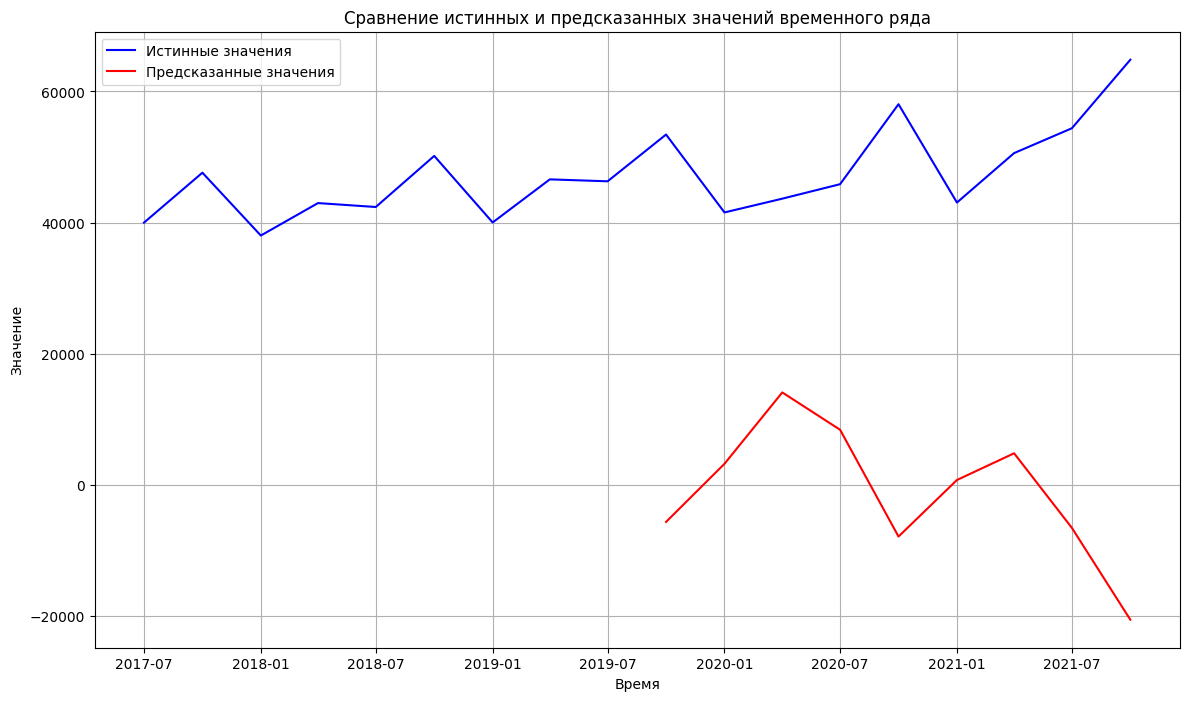

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.2511 - mae: 0.4011
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 111.4771 - mae: 9.9500
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 14.9751 - mae: 3.6209
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 5.5096 - mae: 2.2164
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 36.8606 - mae: 5.7176
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 40.3872 - mae: 5.9938
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 24.0452 - mae: 4.5958
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 7.6051 - mae: 2.5626
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 0.2521 - mae: 0.4023
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 2.6737 - mae: 1.5516
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 8.5616 - mae: 2.7972
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 12.4299 - mae: 3.3602
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms

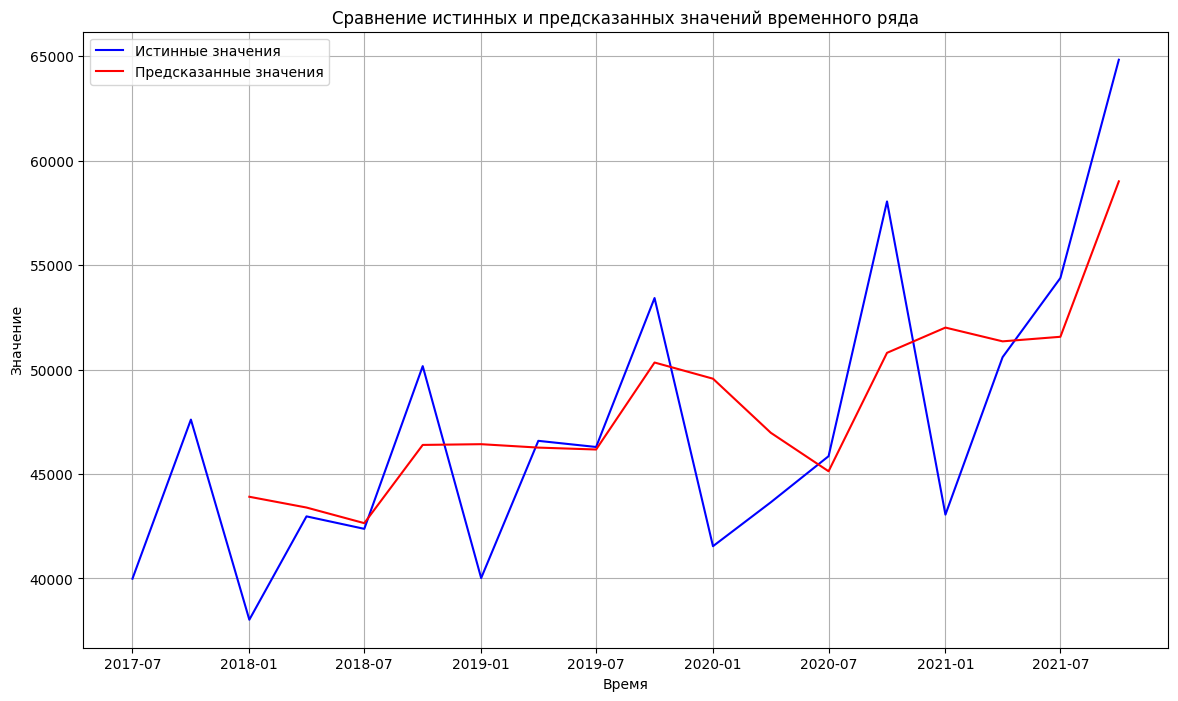

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.1573 - mae: 0.3214
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 304.8618 - mae: 16.5021
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 41.1514 - mae: 6.0517
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 11.1230 - mae: 3.1415
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 76.7484 - mae: 8.2980
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 90.8752 - mae: 9.0147
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 55.2348 - mae: 7.0270
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 20.0895 - mae: 4.1888
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 2.1236 - mae: 1.2569
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 2.3606 - mae: 1.5028
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 13.0467 - mae: 3.5075
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 22.0189 - mae: 4.5282
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

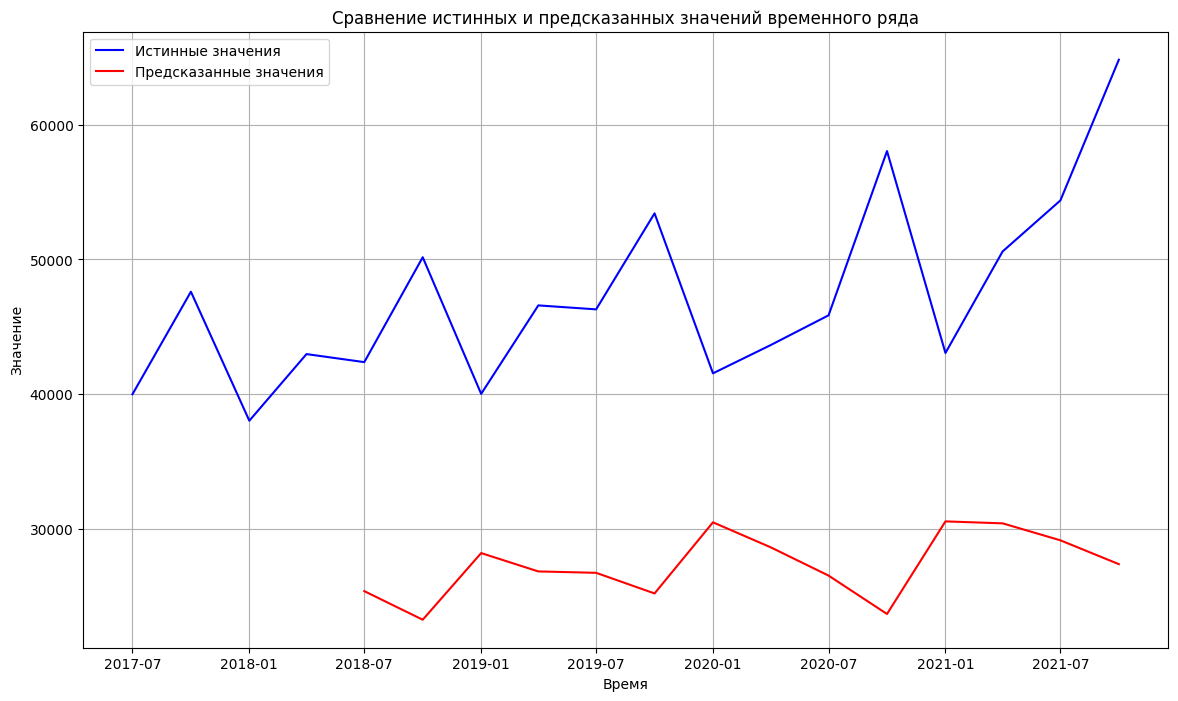

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 7.5981 - mae: 2.5819
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 574.9775 - mae: 22.8222
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 82.6482 - mae: 8.6160
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 11.6842 - mae: 3.2200
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 112.3751 - mae: 10.1002
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 143.8630 - mae: 11.3868
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 98.2965 - mae: 9.4031
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 39.4275 - mae: 5.9112
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 6.5273 - mae: 2.3272
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.9981 - mae: 0.9476
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 14.3166 - mae: 3.6839
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 28.2876 - mae: 5.1480
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 

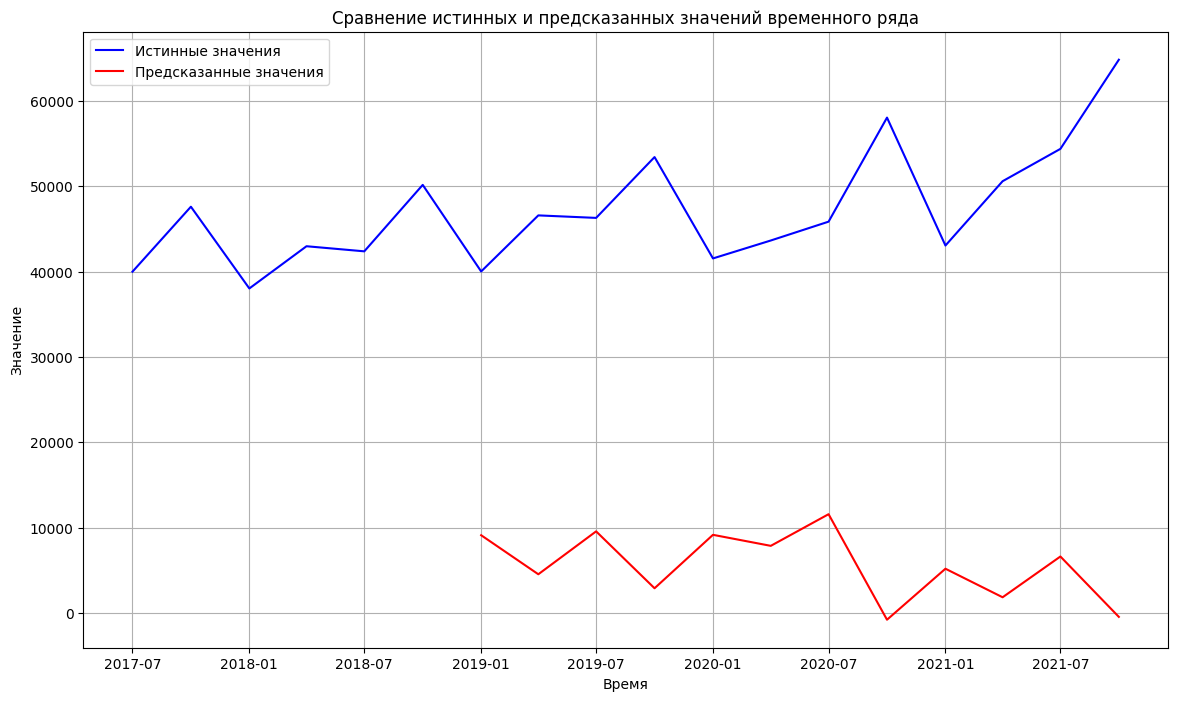

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.7058 - mae: 0.6480
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 1277.7314 - mae: 34.3641
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 174.5411 - mae: 12.7015
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 16.5993 - mae: 3.8465
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 206.1125 - mae: 13.7887
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 247.7968 - mae: 15.1561
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 177.9704 - mae: 12.7626
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 81.0829 - mae: 8.5694
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 18.5720 - mae: 4.0350
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.3834 - mae: 0.5345
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 16.4741 - mae: 3.9970
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 41.9477 - mae: 6.3135
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━

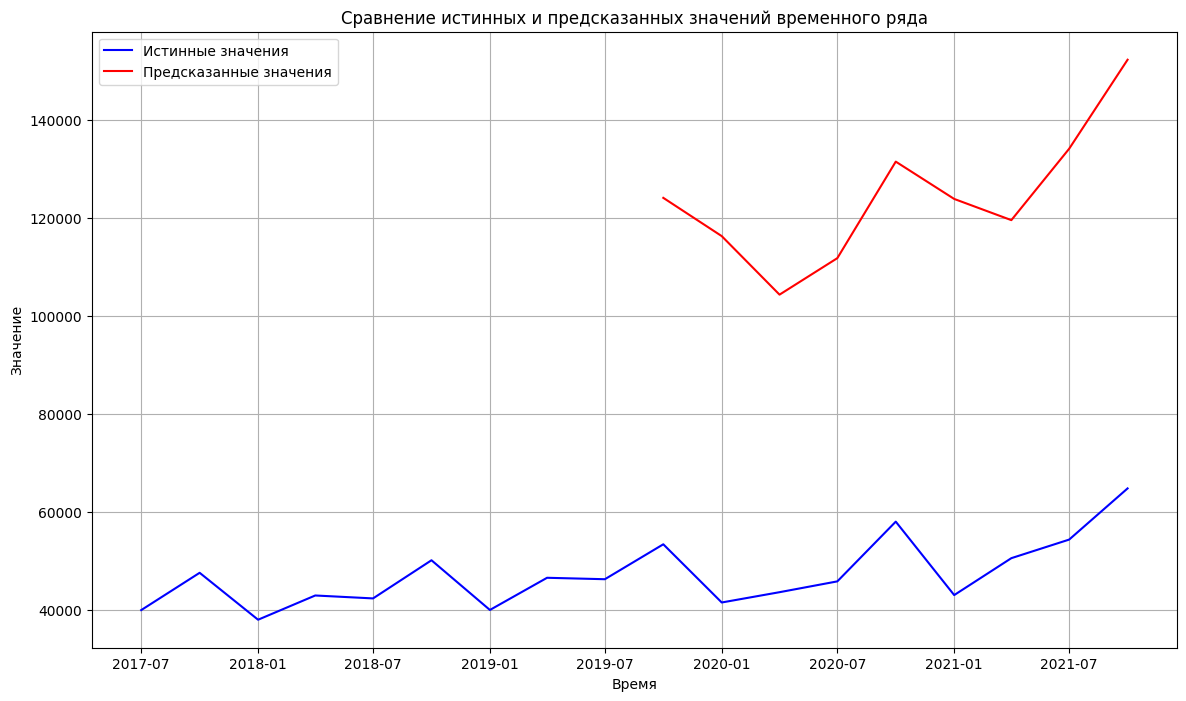

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.7622 - mae: 0.7529
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 107.1170 - mae: 9.7774
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 14.3525 - mae: 3.6020
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 4.8538 - mae: 2.0223
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 33.4187 - mae: 5.4025
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 38.6016 - mae: 5.7991
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 22.6137 - mae: 4.4317
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 6.5708 - mae: 2.3441
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1952 - mae: 0.3507
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 2.9035 - mae: 1.6576
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 8.4430 - mae: 2.7952
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 12.1514 - mae: 3.3493
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms

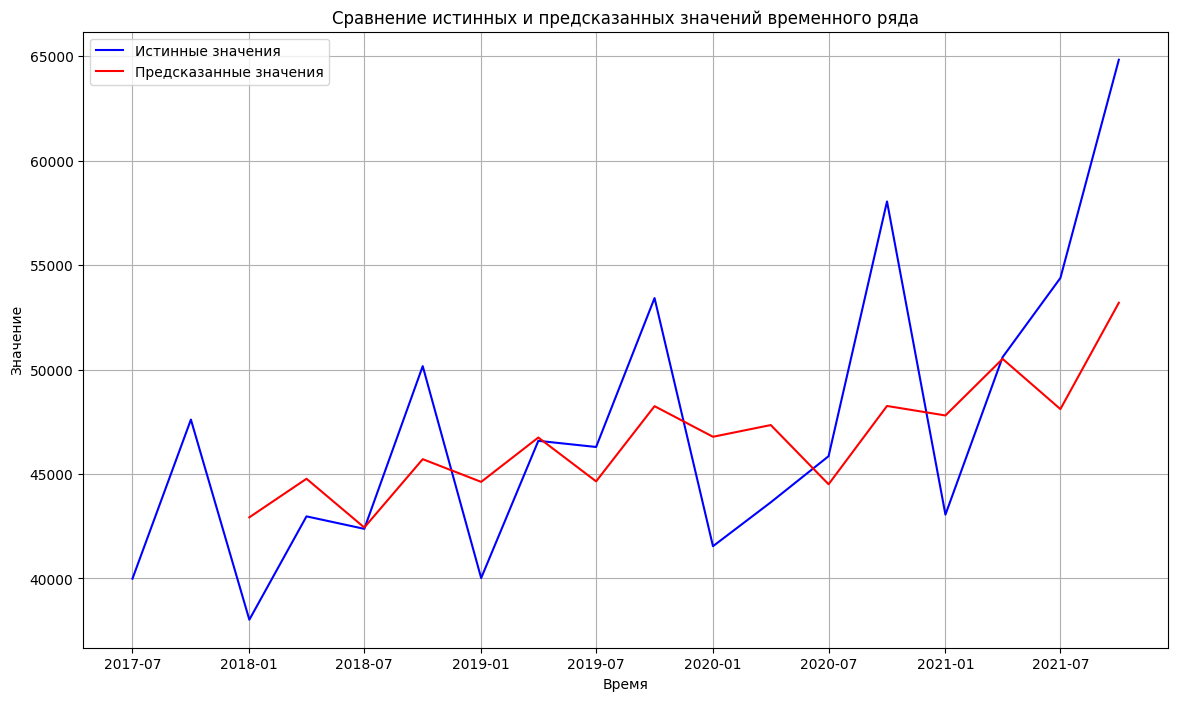

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 1.2910 - mae: 1.0571
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 214.6400 - mae: 13.9183
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 29.8266 - mae: 5.1463
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 7.8905 - mae: 2.6438
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 57.0582 - mae: 7.1442
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 63.3004 - mae: 7.5312
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 39.2767 - mae: 5.9201
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 12.7933 - mae: 3.3313
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 0.6662 - mae: 0.6490
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 3.8297 - mae: 1.9132
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 13.3062 - mae: 3.5295
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 19.2176 - mae: 4.2152
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26

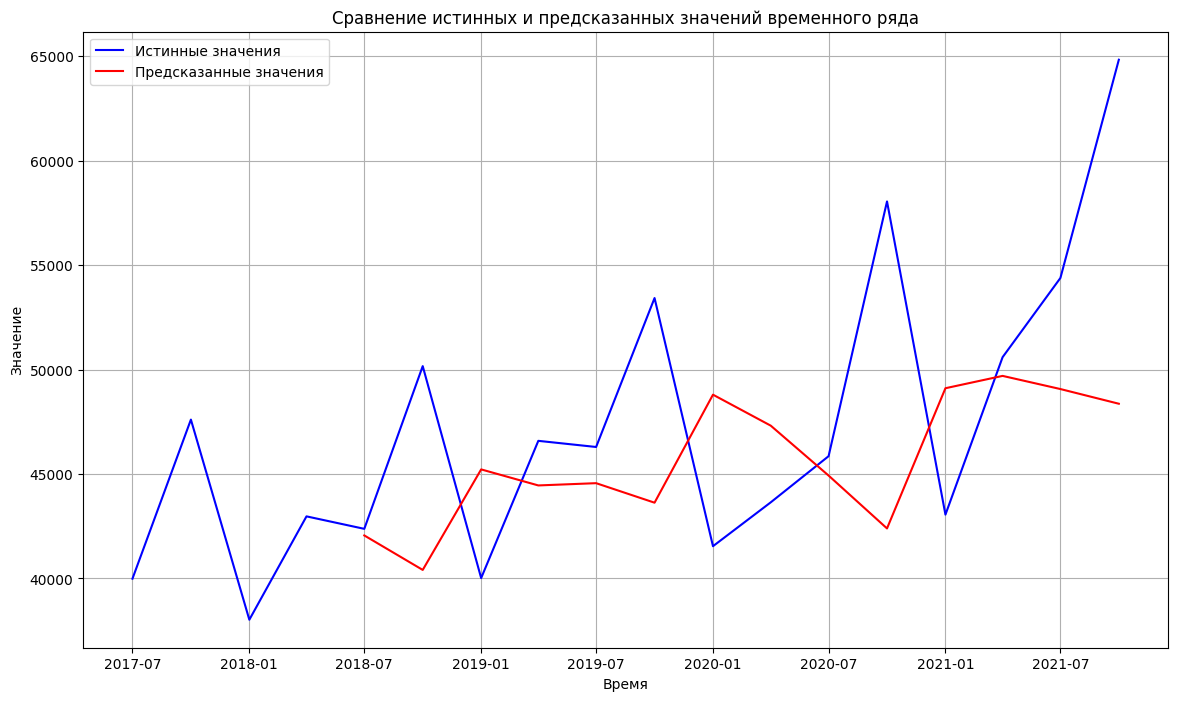

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.4238 - mae: 0.5571
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 621.8909 - mae: 23.7433
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 86.8166 - mae: 8.8506
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 13.5285 - mae: 3.5025
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 123.3873 - mae: 10.5907
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 151.6110 - mae: 11.7027
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 101.6014 - mae: 9.5453
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 39.1551 - mae: 5.8945
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 4.9476 - mae: 2.0466
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 2.8252 - mae: 1.6410
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 21.2087 - mae: 4.4457
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 33.8166 - mae: 5.6270
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━

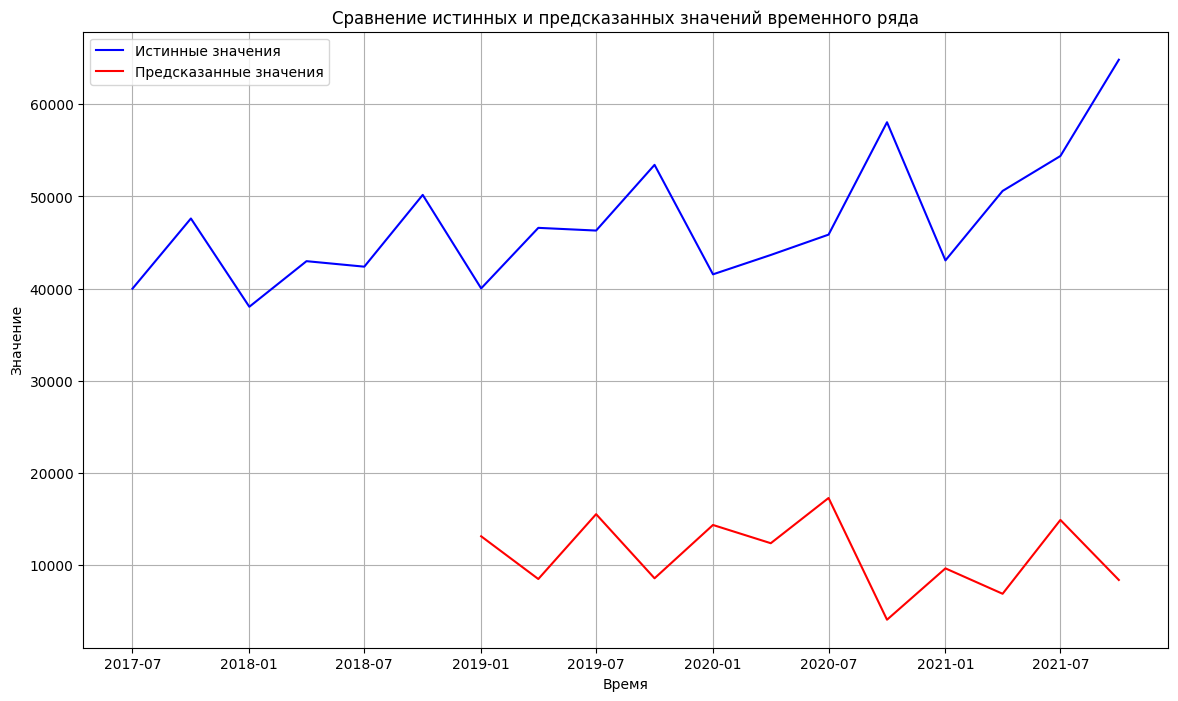

Epoch 1/25


In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'window_size': [3, 5, 7, 10],
    'batch_size': [16, 32, 64],
    'shuffle_buffer': [100, 500, 1000]
}

for params in ParameterGrid(param_grid):
    window_size = params['window_size']
    batch_size = params['batch_size']
    shuffle_buffer = params['shuffle_buffer']

    metrics = run_pipeline(df,
                       series_name='srd(cfo)',
                       split_time=30,
                       window_size=window_size,
                       batch_size=batch_size,
                       shuffle_buffer=shuffle_buffer,
                       epochs=25)

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.4730 - mae: 0.5188
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - loss: 1077.2651 - mae: 31.5288
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 141.0433 - mae: 11.3700
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 18.0094 - mae: 4.0936
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 175.3708 - mae: 12.7917
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 219.4023 - mae: 14.2793
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 148.2269 - mae: 11.7294
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 58.4069 - mae: 7.3474
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 10.4651 - mae: 3.0570
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 1.5322 - mae: 1.2064
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 23.0868 - mae: 4.6880
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 46.8965 - mae: 6.6518
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━

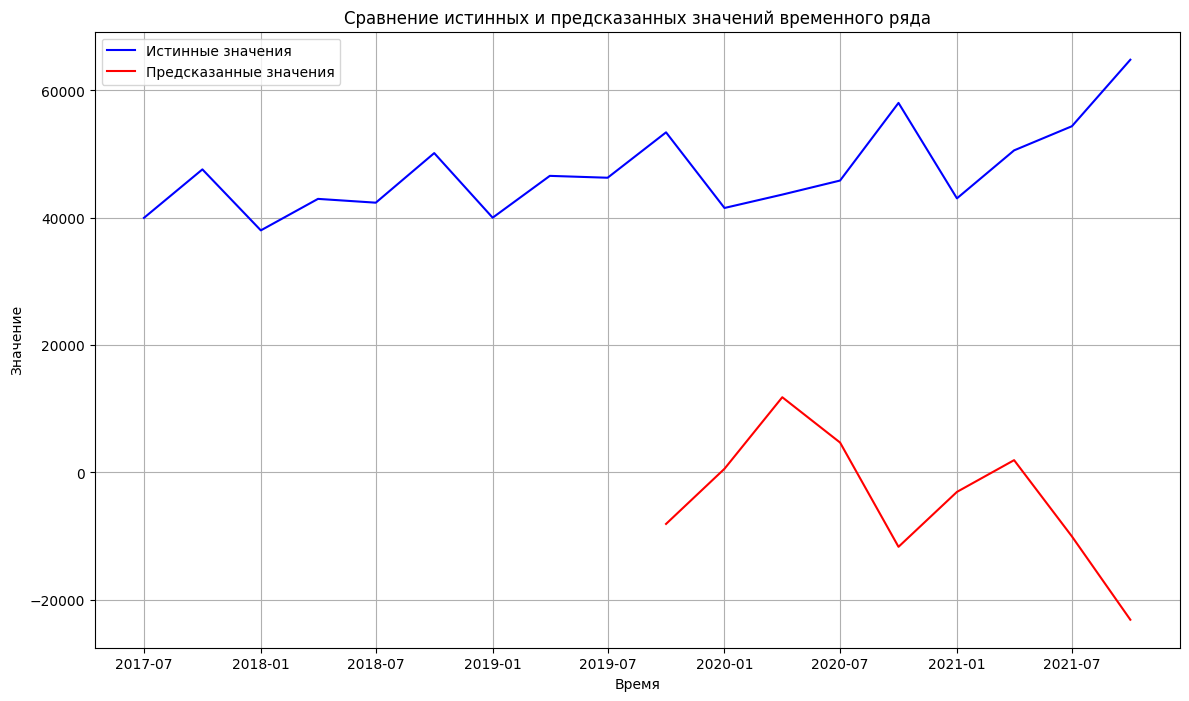

Параметры: {'window_size': 10, 'shuffle_buffer': 1000, 'batch_size': 64}, RMSE: 56056.85048900769
Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 1.0797 - mae: 0.8980
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 268.8391 - mae: 15.5446
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 38.7835 - mae: 5.9033
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 9.3598 - mae: 2.8554
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 66.5709 - mae: 7.6898
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 74.6387 - mae: 8.1627
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 49.1030 - mae: 6.5460
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 15.6307 - mae: 3.6399
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.9137 - mae: 0.7790
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 4.0944 - mae: 1.9776
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 15.4236 - mae: 3.7984
Epoch 12/25
1/1 ━━━━━━━━━

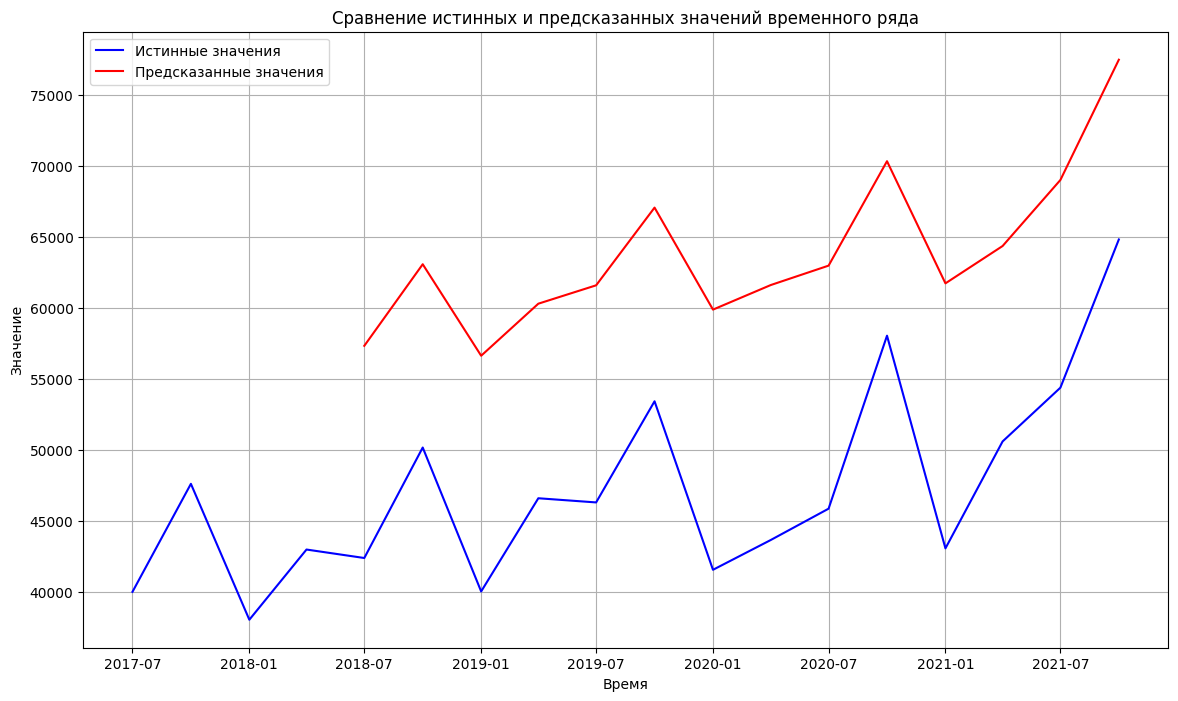

Параметры: {'window_size': 5, 'shuffle_buffer': 100, 'batch_size': 32}, RMSE: 17495.37021841338
Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.6766 - mae: 0.6118
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 679.7145 - mae: 24.7379
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 86.8659 - mae: 8.8592
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 15.7308 - mae: 3.7796
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 136.2291 - mae: 11.1331
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 163.6975 - mae: 12.1569
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 109.7244 - mae: 9.9735
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 49.0905 - mae: 6.6085
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 9.2288 - mae: 2.7898
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.6406 - mae: 0.7408
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 14.5222 - mae: 3.7202
Epoch 12/25
1/1 ━━━━━

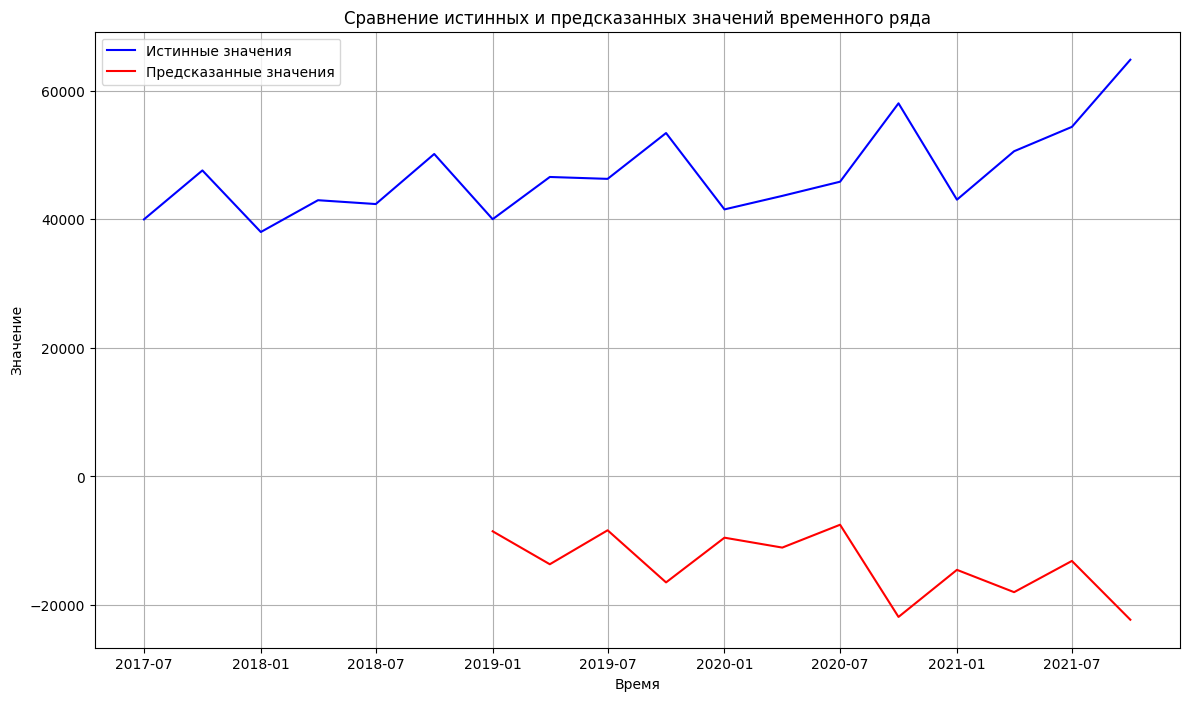

Параметры: {'window_size': 7, 'shuffle_buffer': 100, 'batch_size': 64}, RMSE: 63364.12822040052
Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.1411 - mae: 0.2801
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 550.5399 - mae: 22.3334
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 47.3093 - mae: 6.5359
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 41.5600 - mae: 6.1326
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 158.3028 - mae: 11.9200
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 147.5252 - mae: 11.5054
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 78.0869 - mae: 8.3548
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 22.5057 - mae: 4.4052
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.7351 - mae: 0.7013
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 6.8619 - mae: 2.5671
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 23.6845 - mae: 4.7228
Epoch 12/25
1/1 ━━━━━━

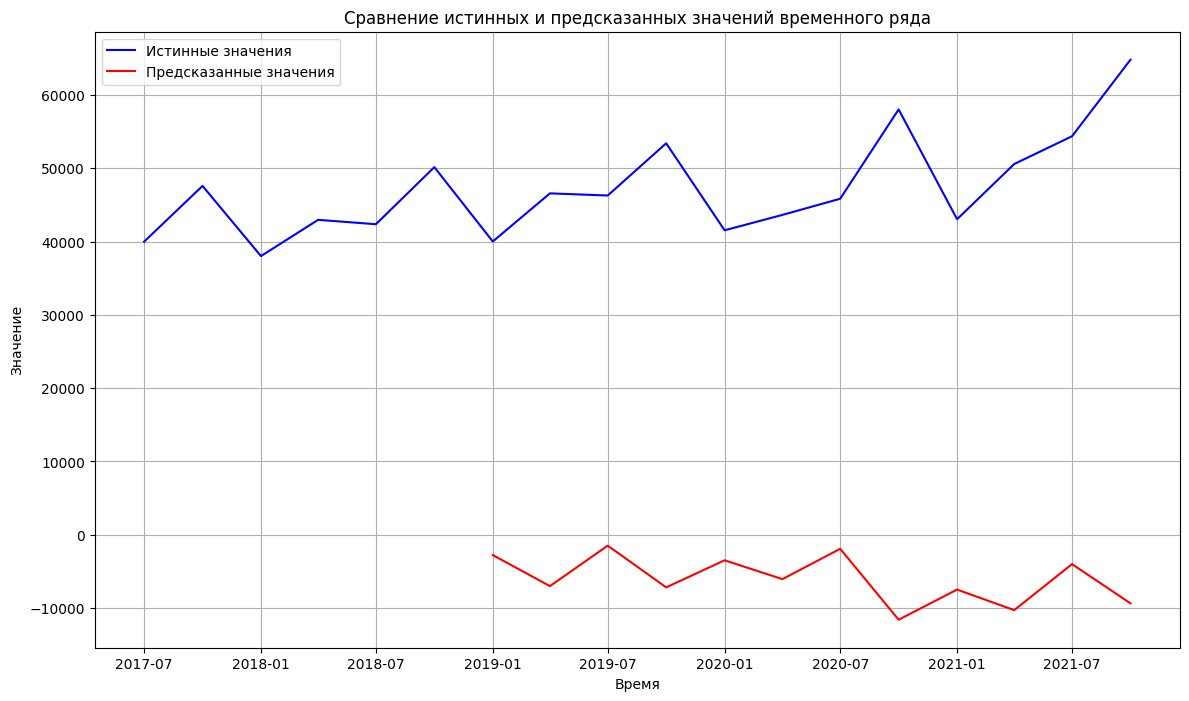

Параметры: {'window_size': 7, 'shuffle_buffer': 500, 'batch_size': 64}, RMSE: 55639.846237682636
Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.5381 - mae: 0.6627
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 106.6699 - mae: 9.7499
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 14.2885 - mae: 3.5628
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 5.4433 - mae: 2.1977
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 35.0420 - mae: 5.5669
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 38.4905 - mae: 5.8376
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 23.8489 - mae: 4.5526
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 7.0464 - mae: 2.4550
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.2565 - mae: 0.3896
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 2.5535 - mae: 1.5362
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 8.6611 - mae: 2.8122
Epoch 12/25
1/1 ━━━━━━━━━━━━━━

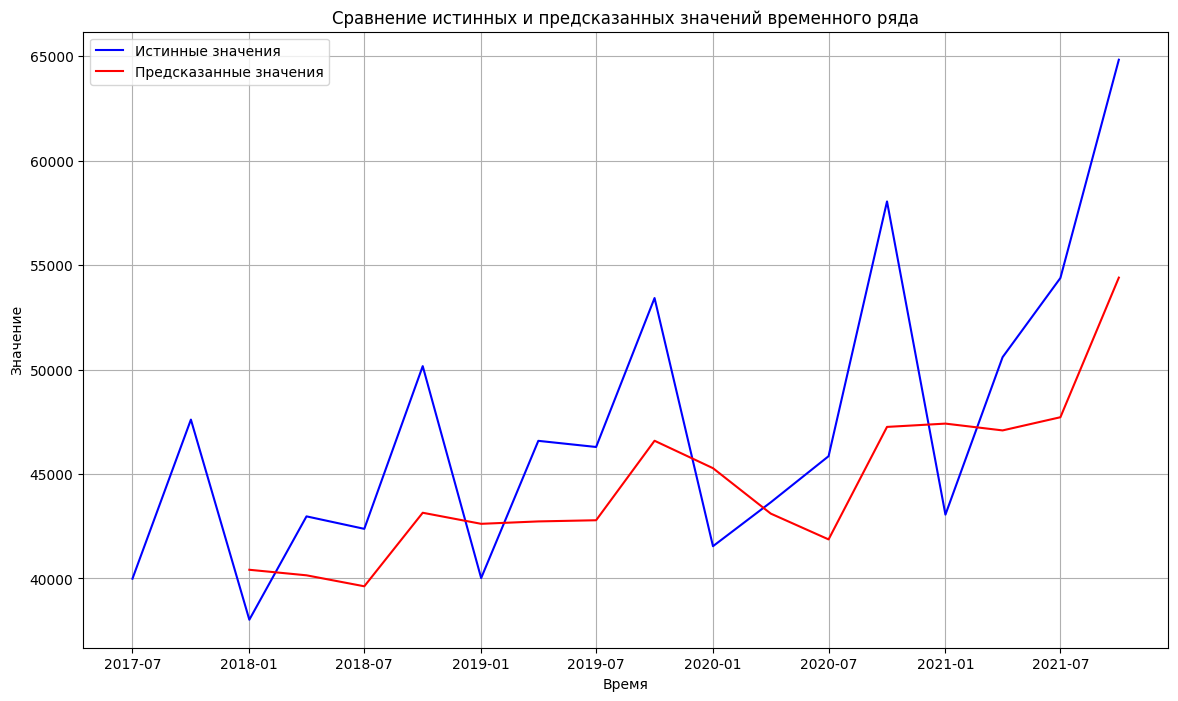

Параметры: {'window_size': 3, 'shuffle_buffer': 500, 'batch_size': 32}, RMSE: 8469.285256342288
Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.4323 - mae: 0.5101
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 1260.3582 - mae: 34.0128
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 166.4924 - mae: 12.3909
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 18.2684 - mae: 4.1425
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 198.9993 - mae: 13.5797
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 243.2663 - mae: 15.0245
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 159.8829 - mae: 12.1668
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 68.1754 - mae: 7.8577
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 10.2046 - mae: 2.9703
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 2.0535 - mae: 1.3950
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 26.0002 - mae: 4.9730
Epoch 12/25
1/1 

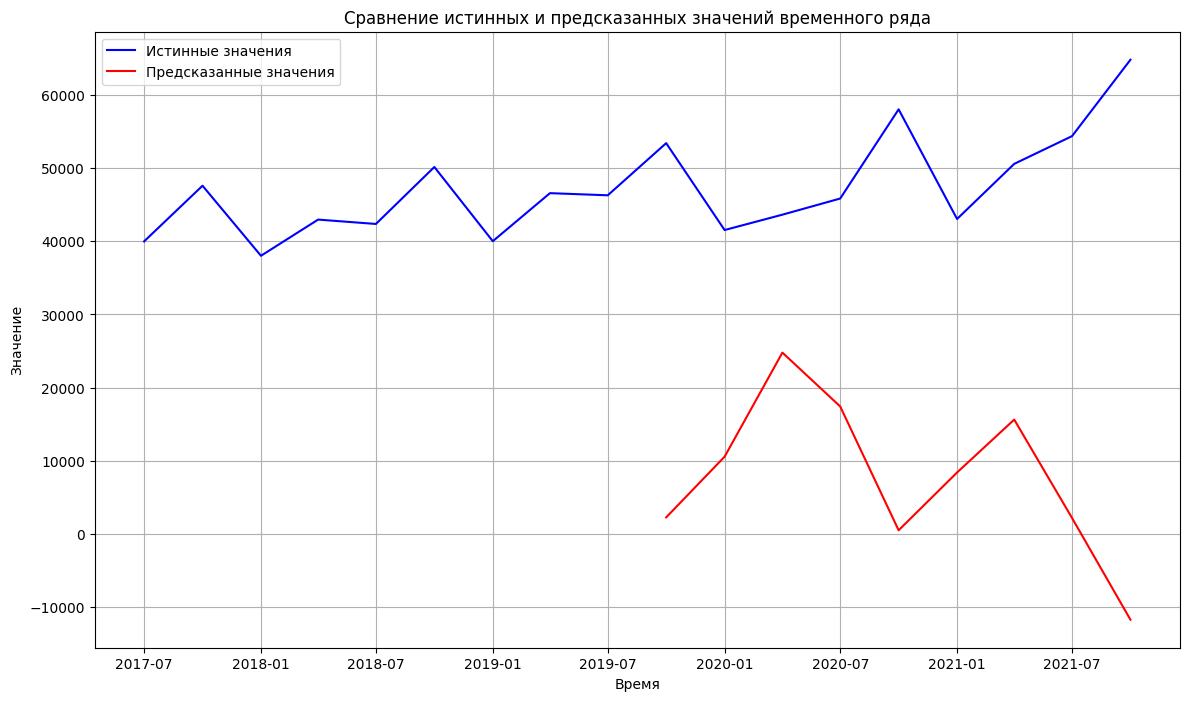

Параметры: {'window_size': 10, 'shuffle_buffer': 500, 'batch_size': 64}, RMSE: 44644.4273835092
Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 1.7177 - mae: 1.1880
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 329.0131 - mae: 17.1608
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 42.5175 - mae: 6.2007
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 12.5652 - mae: 3.3335
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 84.8221 - mae: 8.7244
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 100.8618 - mae: 9.4771
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 59.2851 - mae: 7.2626
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 22.4938 - mae: 4.3932
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 1.4186 - mae: 1.0298
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 3.1958 - mae: 1.7334
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 16.6027 - mae: 3.9200
Epoch 12/25
1/1 ━━━━━━━━━

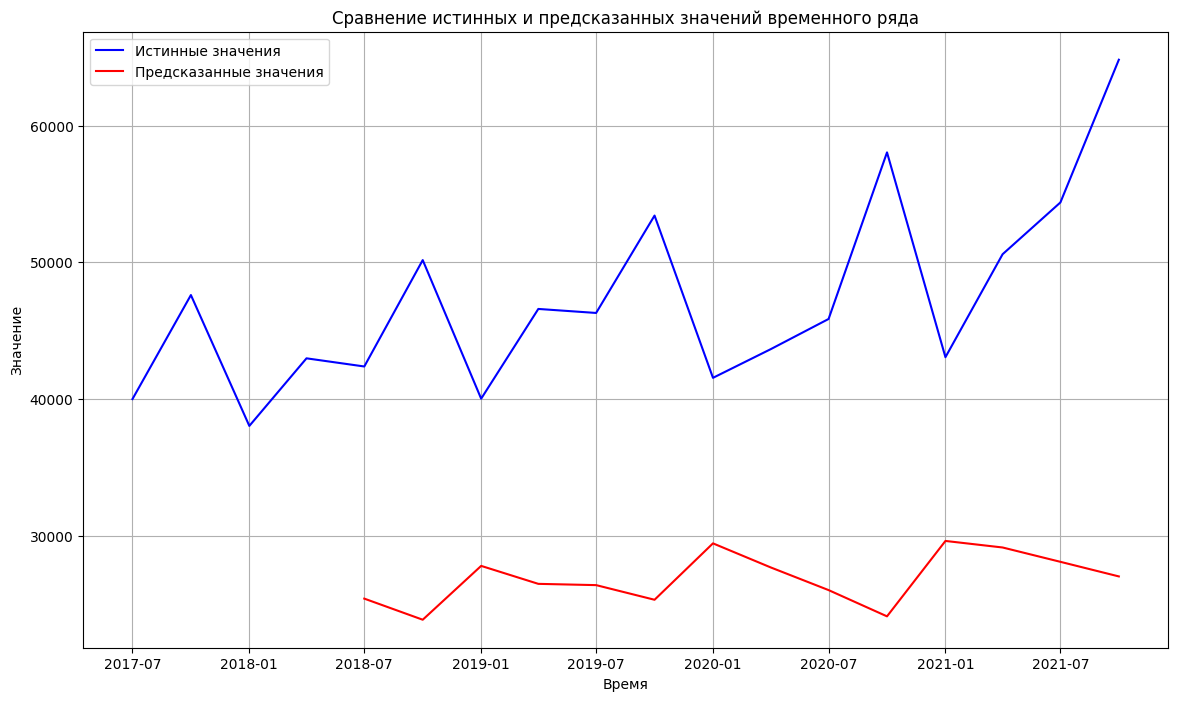

Параметры: {'window_size': 5, 'shuffle_buffer': 1000, 'batch_size': 32}, RMSE: 22873.79475358508
Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.0759 - mae: 0.2221
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 1.5353 - mae: 1.0379
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 27.5356 - mae: 5.1367
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 1.5339 - mae: 1.1736
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 10.0505 - mae: 2.7523
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 14.9841 - mae: 3.4640
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 5.8877 - mae: 2.0748
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.3182 - mae: 0.4801
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 3.2254 - mae: 1.7627
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 7.1301 - mae: 2.5986
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 5.2693 - mae: 2.2324
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 

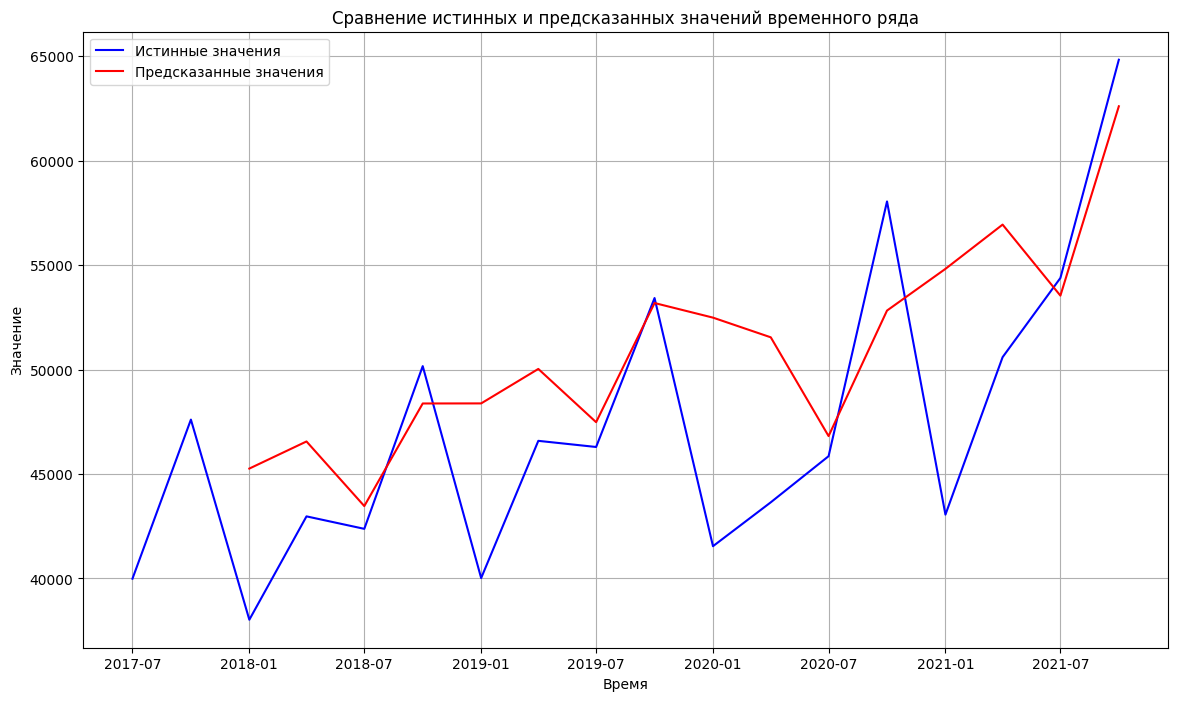

Параметры: {'window_size': 3, 'shuffle_buffer': 100, 'batch_size': 32}, RMSE: 9032.940789533895
Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 35.8452 - mae: 3.4710
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 7.4487 - mae: 2.5332
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 43.1196 - mae: 6.1772 
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 21.9581 - mae: 4.2690
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.0747 - mae: 0.8776
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.9342 - mae: 2.3406
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 10.5609 - mae: 3.1389
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 5.3512 - mae: 2.1874
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.5256 - mae: 0.6365
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.0437 - mae: 0.9347
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.9446 - mae: 1.6326
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

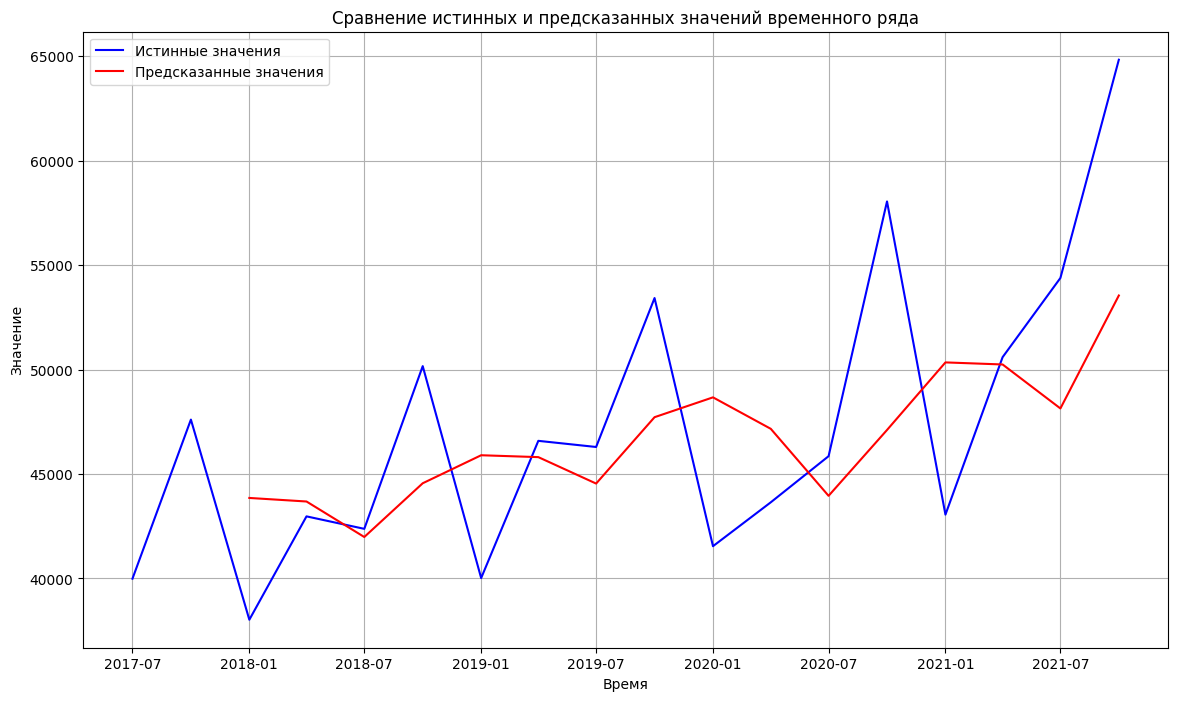

Параметры: {'window_size': 3, 'shuffle_buffer': 1000, 'batch_size': 16}, RMSE: 7619.832154437211
Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 1.5089 - mae: 1.1056
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 322.7466 - mae: 17.0070
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 42.0861 - mae: 6.1593
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 11.0490 - mae: 3.1172
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 72.8741 - mae: 8.1152
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 90.4129 - mae: 8.9922
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 58.5127 - mae: 7.2155
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 21.2975 - mae: 4.3169
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 2.2976 - mae: 1.3126
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 2.2300 - mae: 1.4701
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 14.0570 - mae: 3.6257
Epoch 12/25
1/1 ━━━━━━━━━

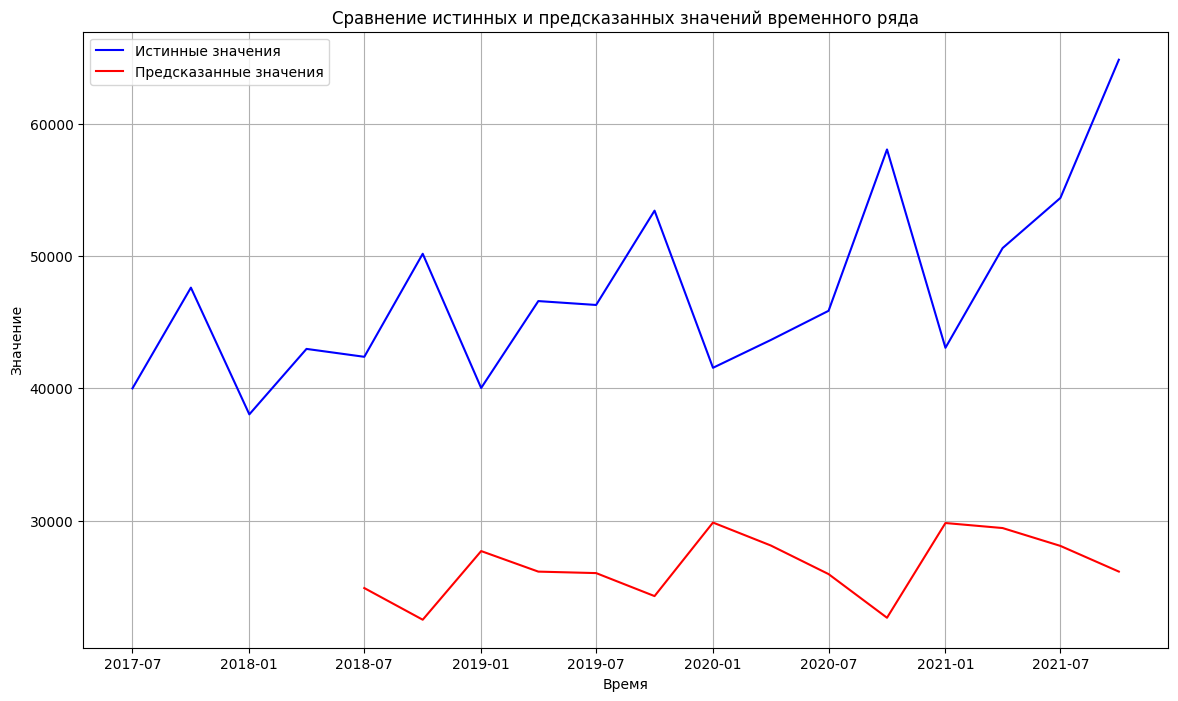

Параметры: {'window_size': 5, 'shuffle_buffer': 500, 'batch_size': 32}, RMSE: 23231.857455881945
Все результаты:
{'params': {'window_size': 10, 'shuffle_buffer': 1000, 'batch_size': 64}, 'RMSE': 56056.85048900769}
{'params': {'window_size': 5, 'shuffle_buffer': 100, 'batch_size': 32}, 'RMSE': 17495.37021841338}
{'params': {'window_size': 7, 'shuffle_buffer': 100, 'batch_size': 64}, 'RMSE': 63364.12822040052}
{'params': {'window_size': 7, 'shuffle_buffer': 500, 'batch_size': 64}, 'RMSE': 55639.846237682636}
{'params': {'window_size': 3, 'shuffle_buffer': 500, 'batch_size': 32}, 'RMSE': 8469.285256342288}
{'params': {'window_size': 10, 'shuffle_buffer': 500, 'batch_size': 64}, 'RMSE': 44644.4273835092}
{'params': {'window_size': 5, 'shuffle_buffer': 1000, 'batch_size': 32}, 'RMSE': 22873.79475358508}
{'params': {'window_size': 3, 'shuffle_buffer': 100, 'batch_size': 32}, 'RMSE': 9032.940789533895}
{'params': {'window_size': 3, 'shuffle_buffer': 1000, 'batch_size': 16}, 'RMSE': 7619.83215

In [ ]:
from sklearn.model_selection import ParameterSampler

param_dist = {
    'window_size': [3, 5, 7, 10],
    'batch_size': [16, 32, 64],
    'shuffle_buffer': [100, 500, 1000]
}

# Генерируем случайные параметры
random_params = list(ParameterSampler(param_dist, n_iter=10, random_state=42))

# Список для хранения результатов
results = []

for params in random_params:
    window_size = params['window_size']
    batch_size = params['batch_size']
    shuffle_buffer = params['shuffle_buffer']

    # Запуск пайплайна с текущими параметрами
    metrics = run_pipeline(df,
                           series_name='srd(cfo)',
                           split_time=30,
                           window_size=window_size,
                           batch_size=batch_size,
                           shuffle_buffer=shuffle_buffer,
                           epochs=25)

    # Получаем RMSE и добавляем результат в список
    rmse = metrics['RMSE']  # Предполагаем, что RMSE находится в metrics
    results.append({'params': params, 'RMSE': rmse})

    # Выводим параметры и RMSE
    print(f"Параметры: {params}, RMSE: {rmse}")

# Вывод всех результатов после завершения
print("Все результаты:")
for result in results:
    print(result)


[I 2024-10-18 09:55:38,337] A new study created in memory with name: no-name-9e9154f7-66e4-470b-ae1d-4616a64449ce


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 0.3141 - mae: 0.4049
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step - loss: 1000.6583 - mae: 30.3610
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - loss: 137.1805 - mae: 11.2003
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step - loss: 15.5036 - mae: 3.8142
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - loss: 172.8340 - mae: 12.6161
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 212.3257 - mae: 13.9872
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step - loss: 142.7102 - mae: 11.4464
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 61.7760 - mae: 7.5378
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 13.6162 - mae: 3.4582
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.6338 - mae: 0.7439
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step - loss: 16.2868 - mae: 3.9261
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step - loss: 39.3348 - mae: 6.0733
Epoch 13/25
1/1 ━━━━━━━━━━━━━

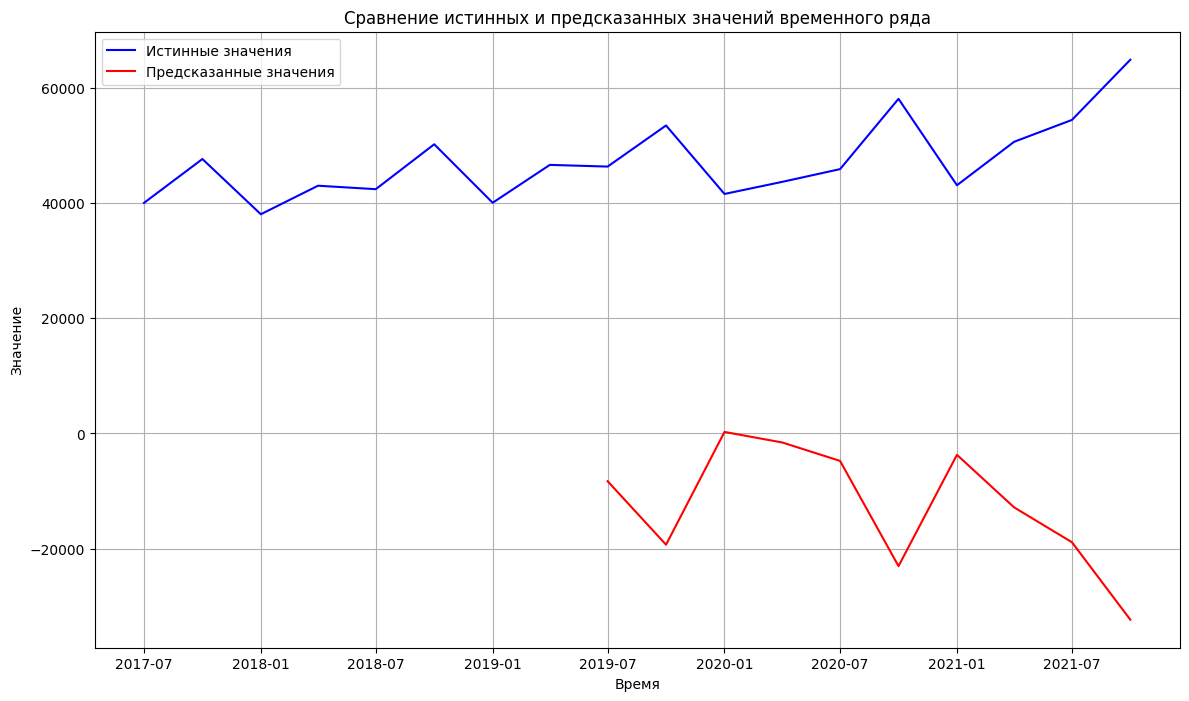

[I 2024-10-18 09:56:06,731] Trial 0 finished with value: 63815.27098001206 and parameters: {'window_size': 9, 'batch_size': 63, 'shuffle_buffer': 109}. Best is trial 0 with value: 63815.27098001206.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 15.7992 - mae: 3.7547
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 443.2715 - mae: 19.9954
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 65.1586 - mae: 7.6775
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 9.1275 - mae: 2.8638
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 83.5906 - mae: 8.7323
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 108.4220 - mae: 9.8962
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 69.3021 - mae: 7.9016
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 27.3122 - mae: 4.9253
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 2.2703 - mae: 1.3524
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 2.6996 - mae: 1.6224
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 15.4148 - mae: 3.8248
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 26.4173 - mae: 4.9576
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

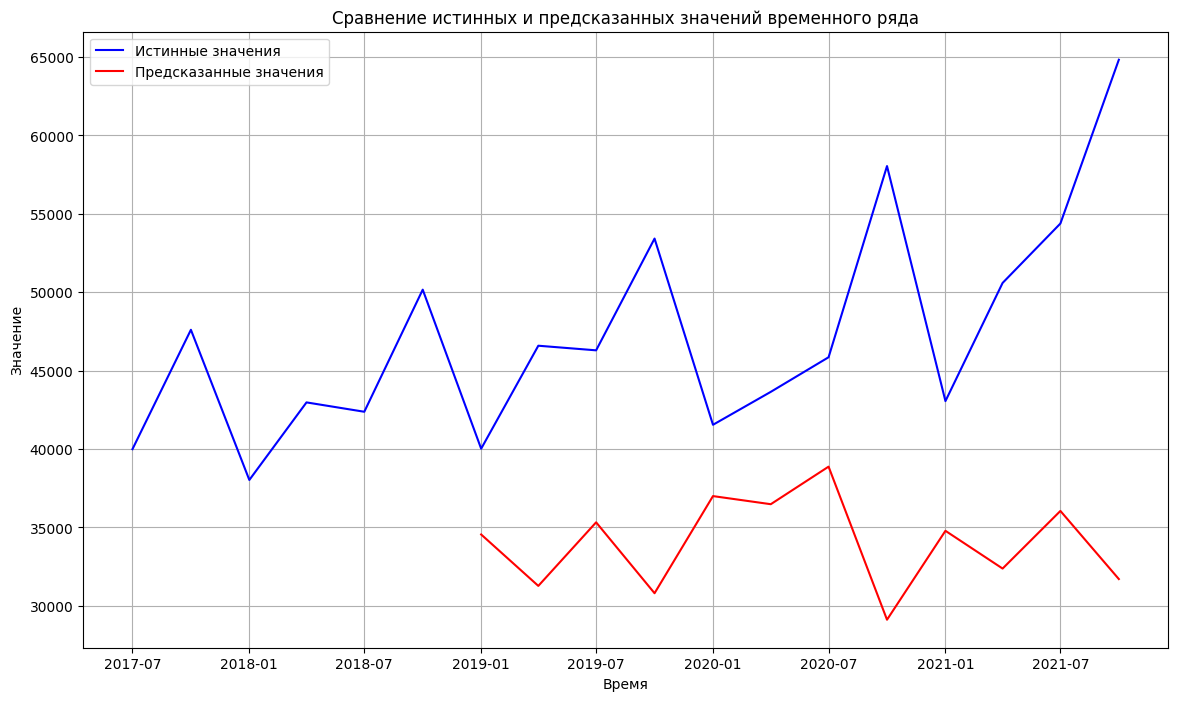

[I 2024-10-18 09:56:19,879] Trial 1 finished with value: 16834.42403849352 and parameters: {'window_size': 7, 'batch_size': 62, 'shuffle_buffer': 395}. Best is trial 1 with value: 16834.42403849352.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.5805 - mae: 0.6059
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 323.5743 - mae: 17.0497
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 43.0546 - mae: 6.1871
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 12.3878 - mae: 3.3058
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 81.3053 - mae: 8.5199
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 97.4344 - mae: 9.3055
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 60.2355 - mae: 7.2940
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 22.1380 - mae: 4.3693
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 2.2718 - mae: 1.2773
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 2.9301 - mae: 1.6730
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 15.2556 - mae: 3.7956
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 25.0758 - mae: 4.8294
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

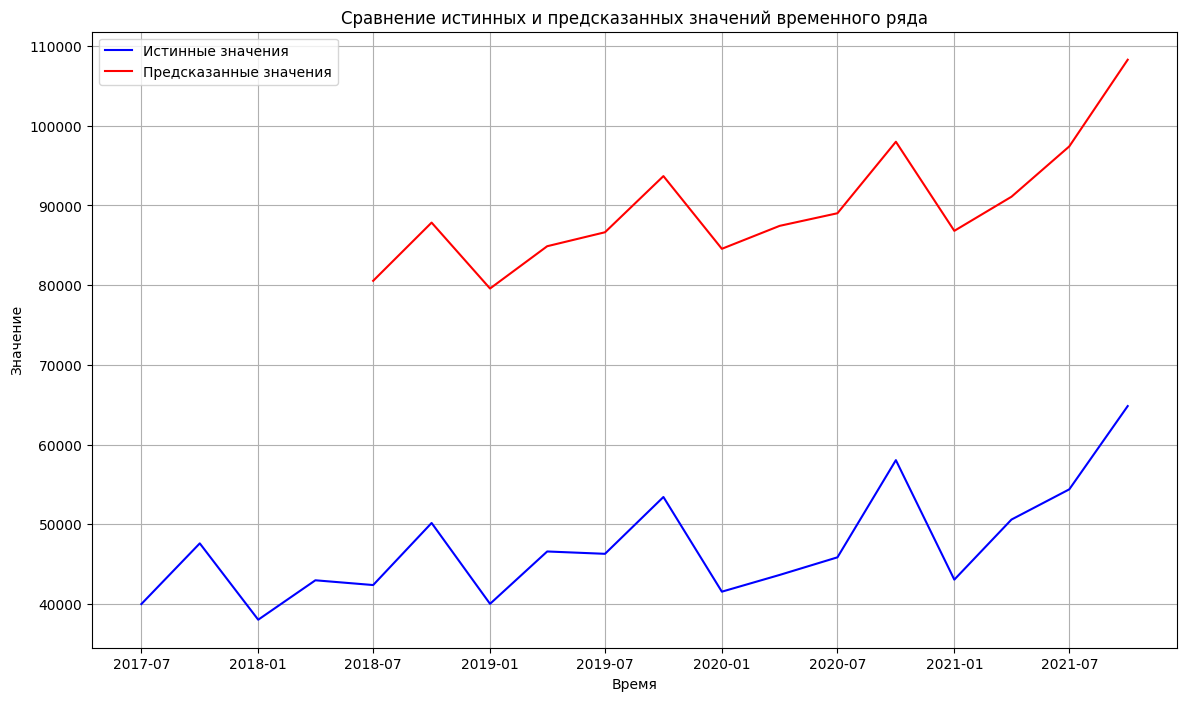

[I 2024-10-18 09:56:32,936] Trial 2 finished with value: 42271.640985887 and parameters: {'window_size': 5, 'batch_size': 40, 'shuffle_buffer': 377}. Best is trial 1 with value: 16834.42403849352.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 2.0148 - mae: 1.2460
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 428.4556 - mae: 19.7009
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 58.4747 - mae: 7.2946
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 10.7155 - mae: 3.0739
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 94.7903 - mae: 9.1975
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 111.1579 - mae: 9.9645
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 72.1128 - mae: 8.0179
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 26.5258 - mae: 4.7853
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 2.4366 - mae: 1.3386
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 3.0645 - mae: 1.7119
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 16.5659 - mae: 3.9653
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 28.7640 - mae: 5.1788
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

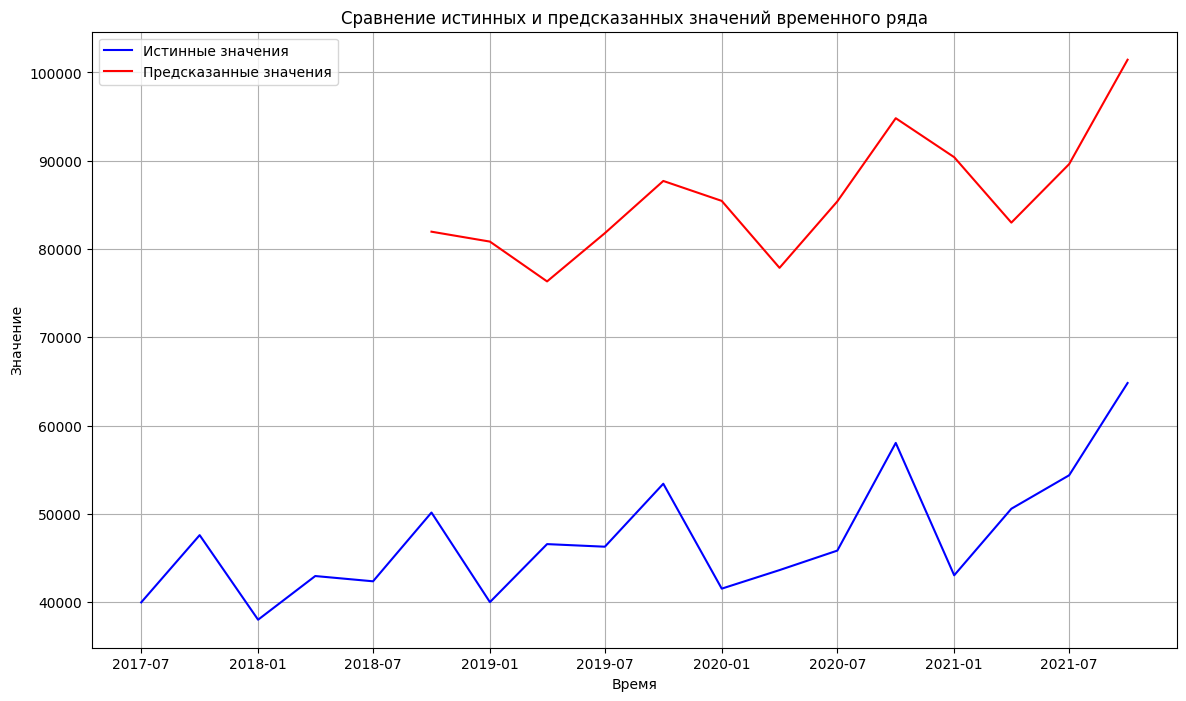

[I 2024-10-18 09:56:46,152] Trial 3 finished with value: 38007.04285380891 and parameters: {'window_size': 6, 'batch_size': 53, 'shuffle_buffer': 843}. Best is trial 1 with value: 16834.42403849352.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 1.3929 - mae: 1.0799
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 322.1448 - mae: 17.0259
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 45.6997 - mae: 6.3782
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 10.7547 - mae: 3.1065
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 82.6585 - mae: 8.6069
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 98.2873 - mae: 9.3462
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 63.4379 - mae: 7.5040
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 22.9072 - mae: 4.4784
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 2.6750 - mae: 1.4360
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 2.2080 - mae: 1.4455
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 13.2361 - mae: 3.5183
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 23.0389 - mae: 4.6208
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

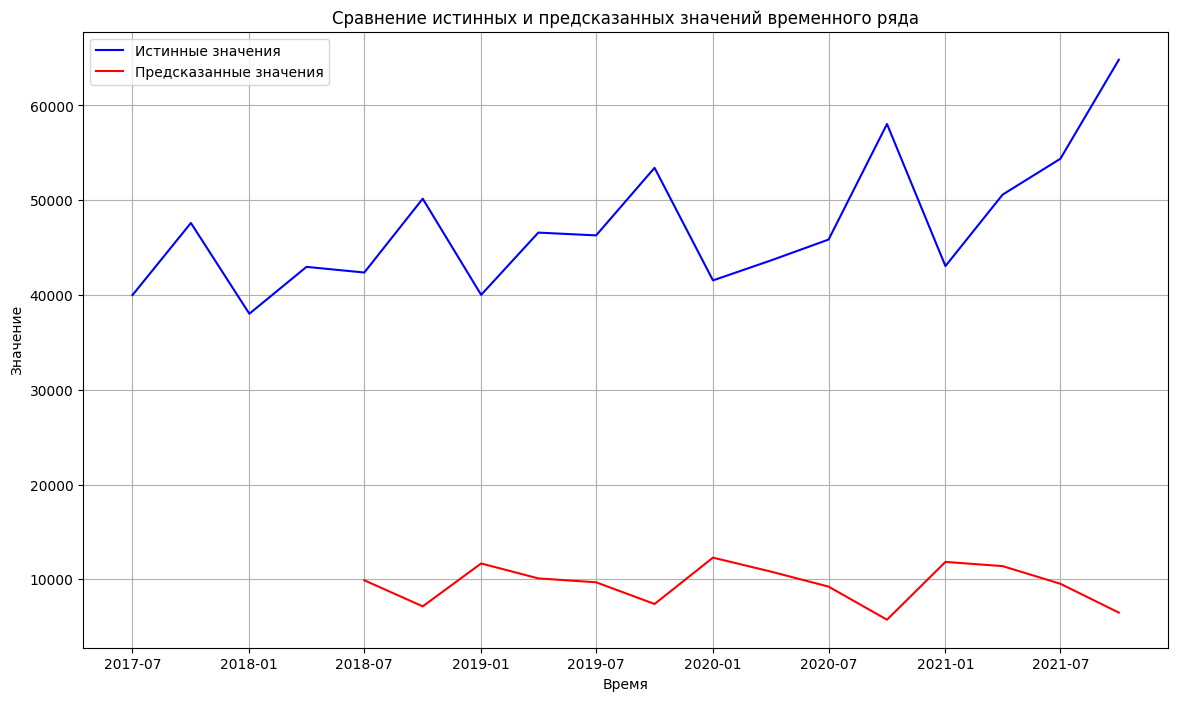

[I 2024-10-18 09:56:59,125] Trial 4 finished with value: 39750.97852268832 and parameters: {'window_size': 5, 'batch_size': 27, 'shuffle_buffer': 113}. Best is trial 1 with value: 16834.42403849352.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 25.5823 - mae: 2.0551
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 17.3263 - mae: 3.8748
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 66.7411 - mae: 7.7156
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 33.0719 - mae: 5.2983
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.9609 - mae: 0.8450
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 9.3014 - mae: 2.9402
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 13.6450 - mae: 3.5552
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.8669 - mae: 2.3042
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2632 - mae: 0.4575
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.8466 - mae: 1.2951
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 4.4671 - mae: 2.0202
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 4.0485 - mae: 1.9183
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - lo

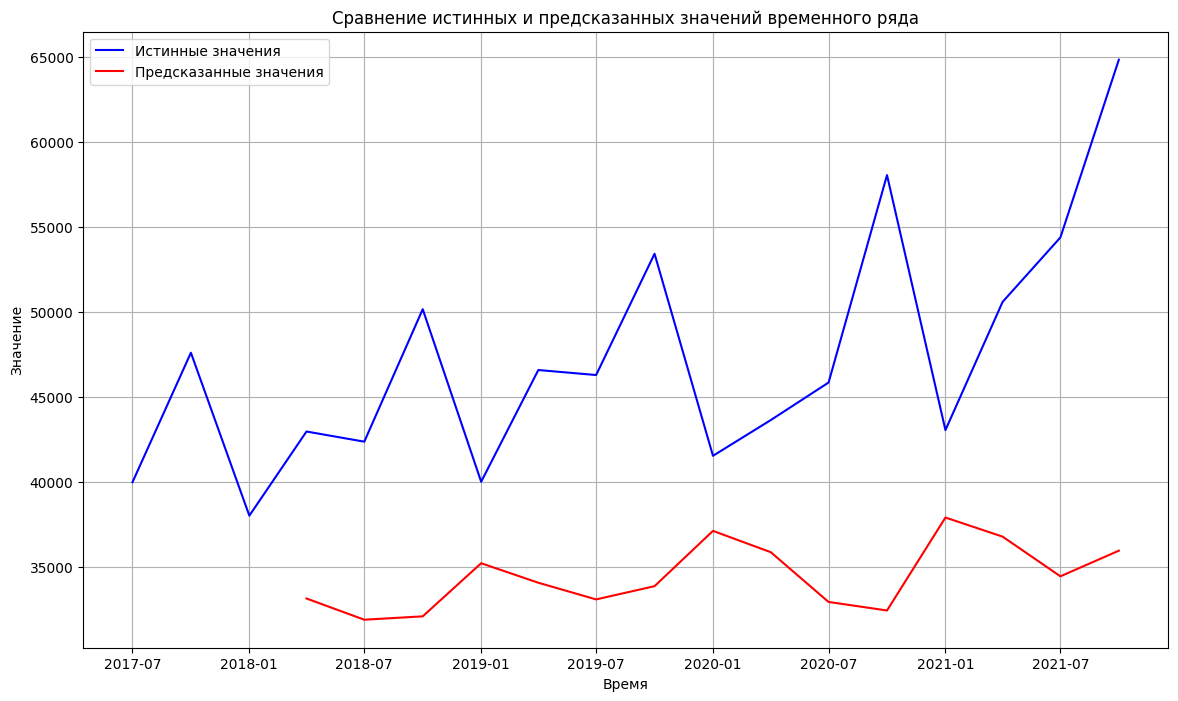

[I 2024-10-18 09:57:14,061] Trial 5 finished with value: 15452.777567595618 and parameters: {'window_size': 4, 'batch_size': 21, 'shuffle_buffer': 871}. Best is trial 5 with value: 15452.777567595618.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.9606 - mae: 0.7722
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 210.4810 - mae: 13.7292
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 31.2299 - mae: 5.2812
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 8.3874 - mae: 2.7257
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 59.2230 - mae: 7.2852
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 70.1544 - mae: 7.9058
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 46.2420 - mae: 6.3860
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 16.3372 - mae: 3.7666
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.0302 - mae: 0.8952
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 2.1003 - mae: 1.4062
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 12.0960 - mae: 3.3356
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 18.2837 - mae: 4.1075
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13

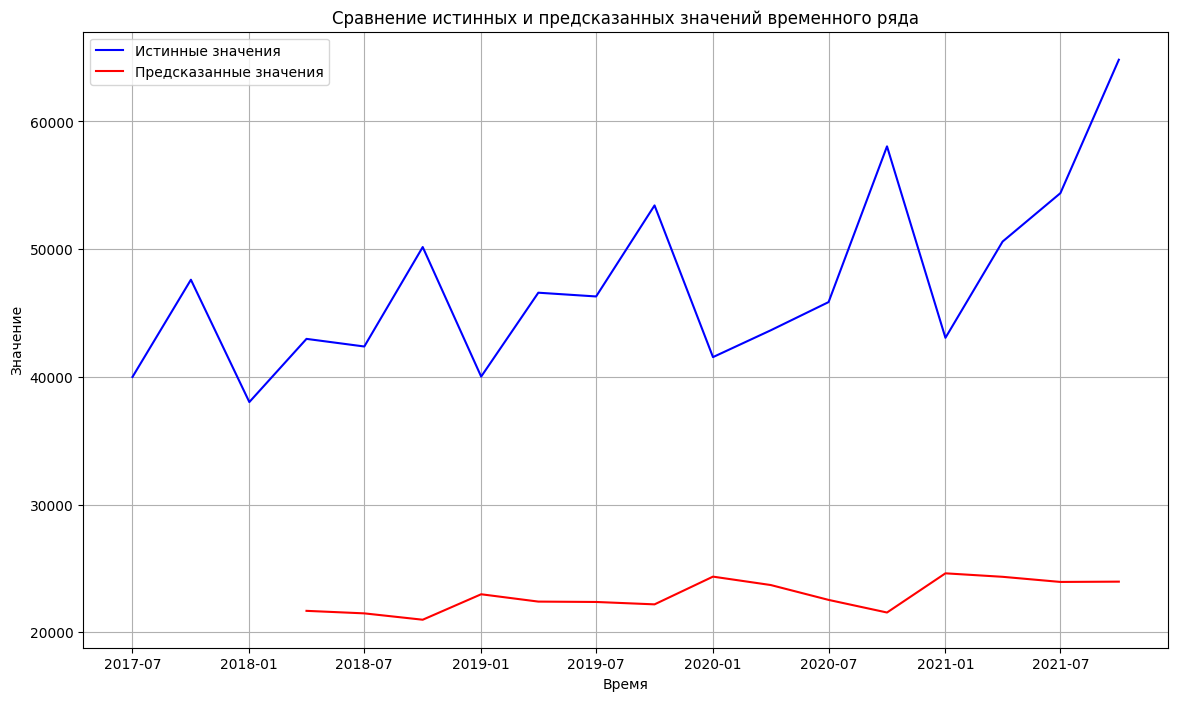

[I 2024-10-18 09:57:27,277] Trial 6 finished with value: 26283.688657462033 and parameters: {'window_size': 4, 'batch_size': 40, 'shuffle_buffer': 676}. Best is trial 5 with value: 15452.777567595618.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.1061 - mae: 0.2459
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 216.4048 - mae: 13.9320
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 29.4573 - mae: 5.1308
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 8.0626 - mae: 2.6869
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 58.4065 - mae: 7.2453
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 72.6221 - mae: 8.0386
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 47.4343 - mae: 6.4928
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 18.1432 - mae: 3.9772
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 2.2099 - mae: 1.3103
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 1.3718 - mae: 1.1363
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 9.7509 - mae: 3.0081
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 16.7398 - mae: 3.9387
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760

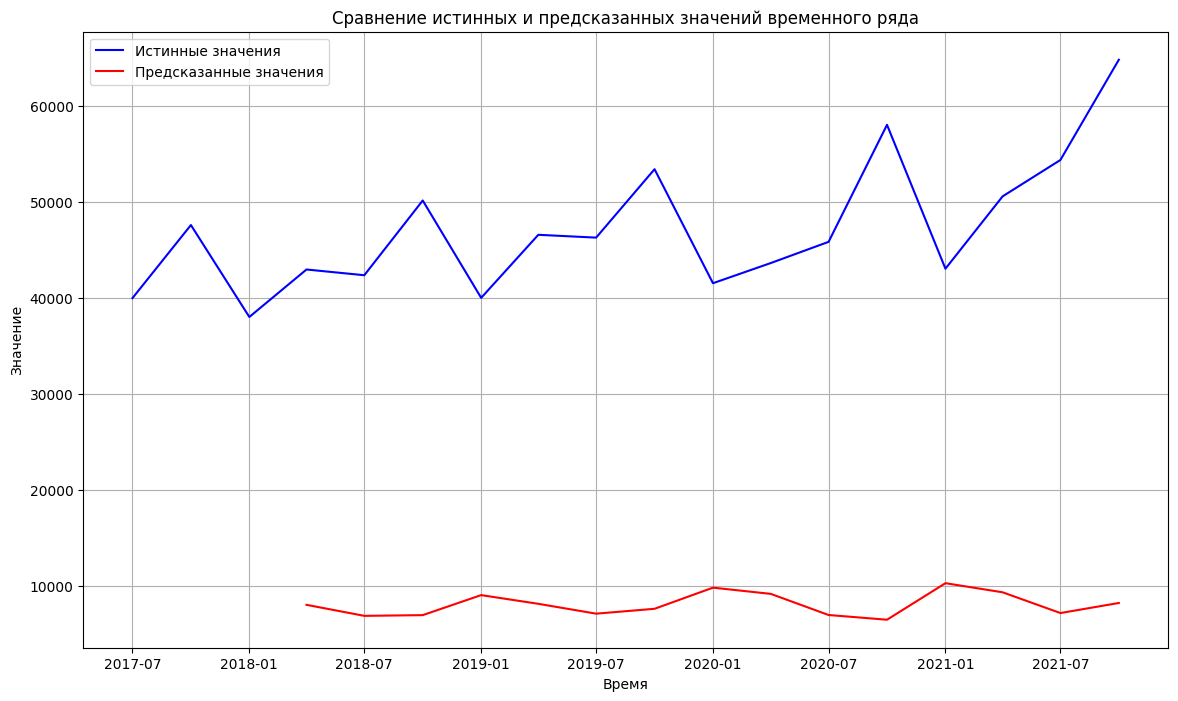

[I 2024-10-18 09:57:42,438] Trial 7 finished with value: 40743.36814670052 and parameters: {'window_size': 4, 'batch_size': 45, 'shuffle_buffer': 151}. Best is trial 5 with value: 15452.777567595618.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 1.5204 - mae: 1.0786
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 899.3159 - mae: 28.7062
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 119.7453 - mae: 10.4874
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 14.2683 - mae: 3.5745
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 149.7546 - mae: 11.7250
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 181.9161 - mae: 12.9475
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 128.0032 - mae: 10.8142
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 58.0815 - mae: 7.2550
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 11.4110 - mae: 3.1432
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 0.4995 - mae: 0.6253
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 15.4363 - mae: 3.8522
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 35.3515 - mae: 5.8125
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━

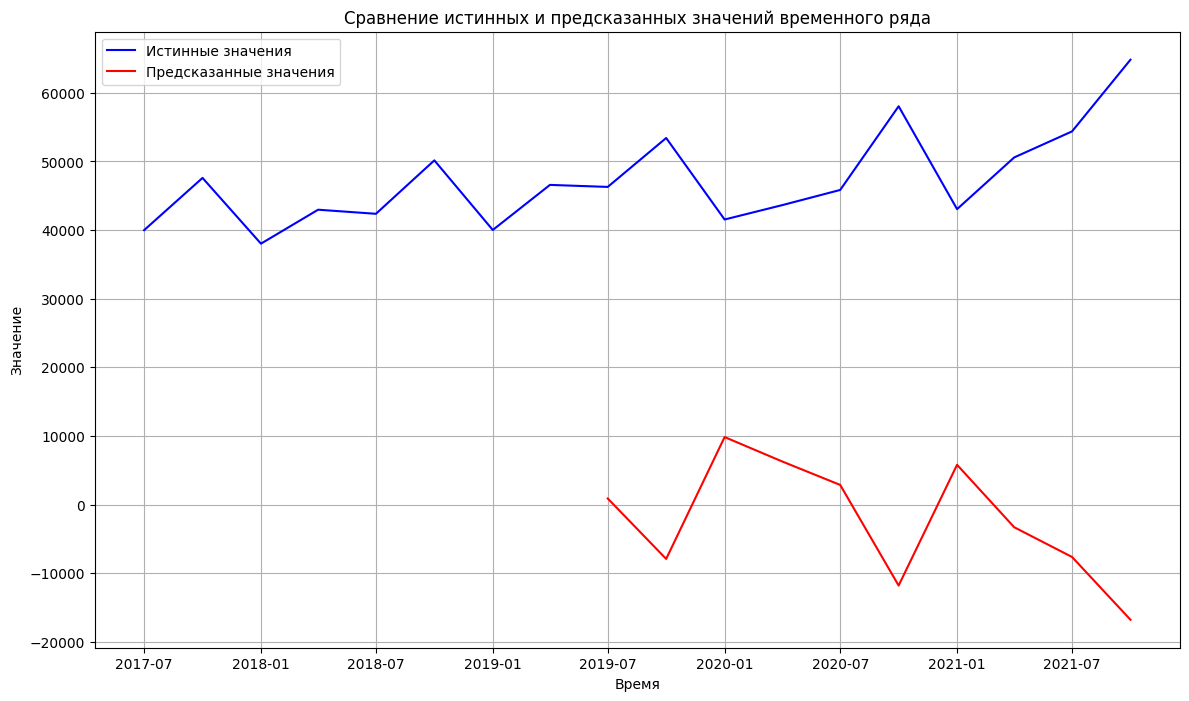

[I 2024-10-18 09:57:56,585] Trial 8 finished with value: 53468.49164534998 and parameters: {'window_size': 9, 'batch_size': 49, 'shuffle_buffer': 800}. Best is trial 5 with value: 15452.777567595618.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 41.8949 - mae: 1.8578
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 39.1780 - mae: 5.8957
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 147.2420 - mae: 11.4938
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 112.2915 - mae: 9.9866 
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 14.4434 - mae: 3.3545
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 10.2185 - mae: 3.0604
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 30.5534 - mae: 5.3849
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 21.3934 - mae: 4.4924
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 5.9634 - mae: 2.3476
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1225 - mae: 0.2979
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 3.2316 - mae: 1.6570
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 7.8541 - mae: 2.6388
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/st

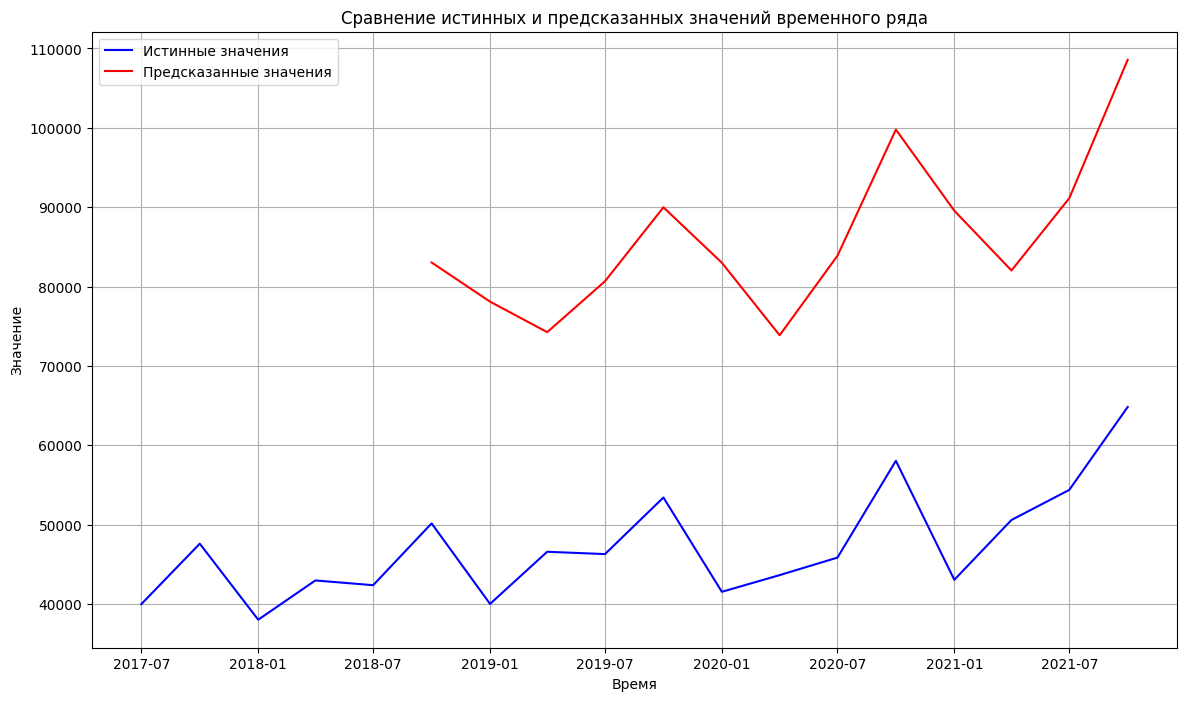

[I 2024-10-18 09:58:17,355] Trial 9 finished with value: 38686.20088542126 and parameters: {'window_size': 6, 'batch_size': 22, 'shuffle_buffer': 978}. Best is trial 5 with value: 15452.777567595618.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 28.4276 - mae: 3.4326
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 6.8519 - mae: 2.4396
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 31.8930 - mae: 5.2895
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 13.0008 - mae: 3.2420
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.8427 - mae: 0.6914
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 8.3506 - mae: 2.7662
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 7.9636 - mae: 2.7235
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.7037 - mae: 1.2167
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.5377 - mae: 0.5631
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 3.0931 - mae: 1.6557
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.3880 - mae: 1.7584
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.5475 - mae: 1.1790
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 

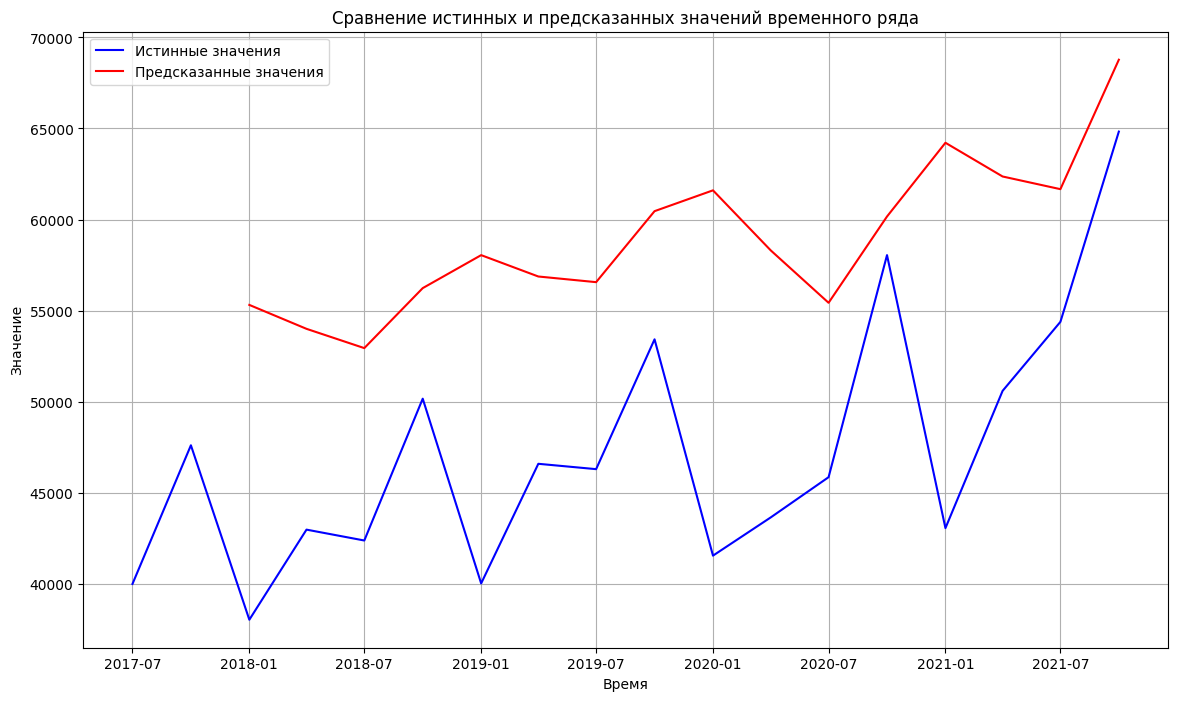

[I 2024-10-18 09:58:33,944] Trial 10 finished with value: 13892.251882782428 and parameters: {'window_size': 3, 'batch_size': 17, 'shuffle_buffer': 558}. Best is trial 10 with value: 13892.251882782428.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - loss: 25.7117 - mae: 3.1141
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 6.5819 - mae: 2.4168
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 25.4559 - mae: 4.7584
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 8.3895 - mae: 2.5531
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.9412 - mae: 0.6911
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 7.2996 - mae: 2.5743
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 4.7344 - mae: 2.0512
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.8243 - mae: 0.7729
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 1.0114 - mae: 0.9101
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.5680 - mae: 1.5438
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.9611 - mae: 1.3360
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.4106 - mae: 0.5749
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step -

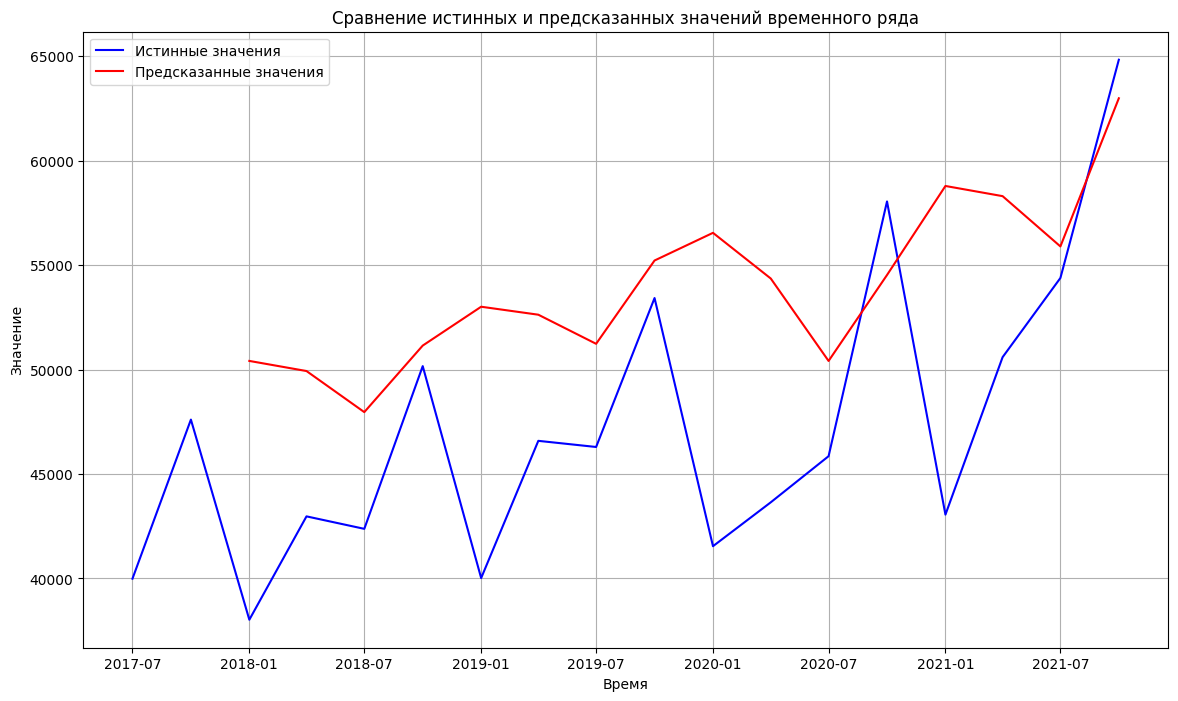

[I 2024-10-18 09:58:50,143] Trial 11 finished with value: 10166.392475916655 and parameters: {'window_size': 3, 'batch_size': 16, 'shuffle_buffer': 534}. Best is trial 11 with value: 10166.392475916655.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 3.0304 - mae: 1.5893
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 74.9133 - mae: 8.2028
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 12.1294 - mae: 3.2971
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 3.0402 - mae: 1.6073
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 22.5494 - mae: 4.4529
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 25.9694 - mae: 4.7840
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 15.8027 - mae: 3.6974
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 4.1220 - mae: 1.8593
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0981 - mae: 0.2705
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 2.6498 - mae: 1.5665
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 6.7733 - mae: 2.4972
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 8.7253 - mae: 2.8211
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/s

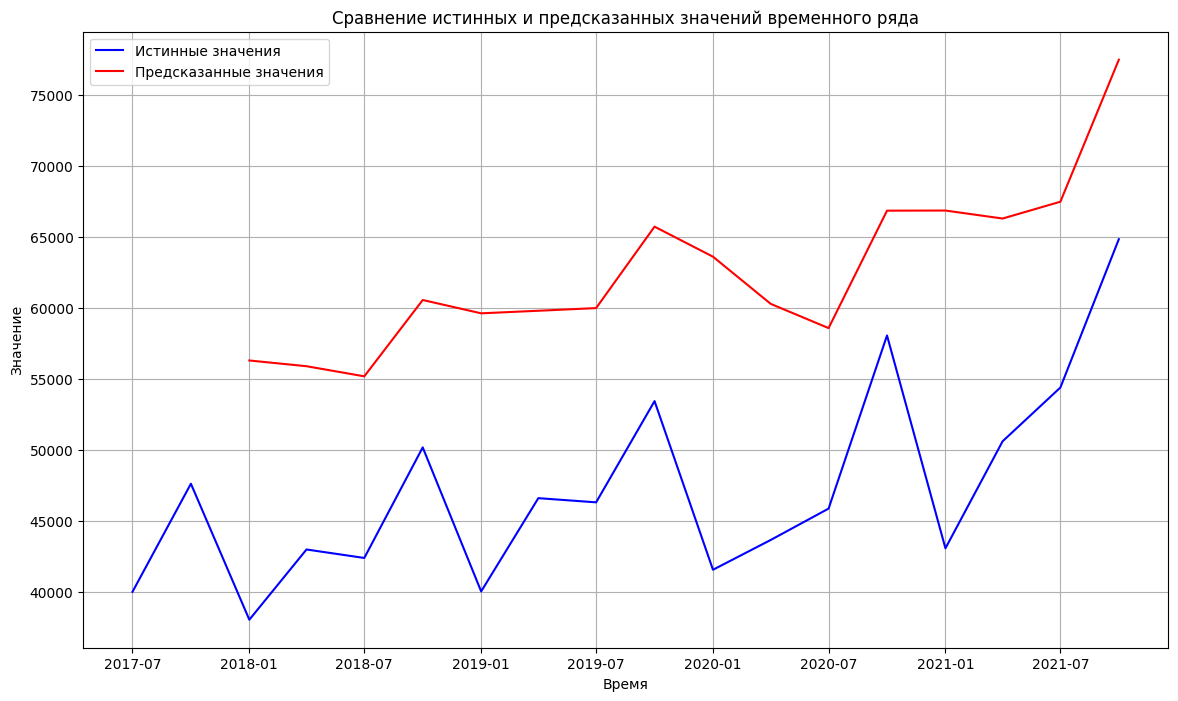

[I 2024-10-18 09:59:03,073] Trial 12 finished with value: 17370.295427011806 and parameters: {'window_size': 3, 'batch_size': 31, 'shuffle_buffer': 535}. Best is trial 11 with value: 10166.392475916655.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 24.4605 - mae: 3.3534
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 7.7592 - mae: 2.6685
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 27.8832 - mae: 4.9239
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 9.3064 - mae: 2.6372 
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 1.9403 - mae: 1.1709
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.7077 - mae: 2.8681
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 5.6783 - mae: 2.2508
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.6392 - mae: 0.6826
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.0217 - mae: 0.9011
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 2.9854 - mae: 1.6518
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 2.2794 - mae: 1.4202
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.5246 - mae: 0.6497
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - lo

[I 2024-10-18 09:59:17,868] Trial 13 finished with value: 18455.149987175144 and parameters: {'window_size': 3, 'batch_size': 16, 'shuffle_buffer': 559}. Best is trial 11 with value: 10166.392475916655.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 1.8136 - mae: 1.2289
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 89.7005 - mae: 8.9596
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 12.6635 - mae: 3.3379
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 3.9983 - mae: 1.8701
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 26.7584 - mae: 4.8880
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 31.6759 - mae: 5.2923
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 19.2202 - mae: 4.1073
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 5.7024 - mae: 2.2018
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.1285 - mae: 0.3024
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 2.9575 - mae: 1.6529
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 7.9372 - mae: 2.7128
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 10.5591 - mae: 3.0981
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/

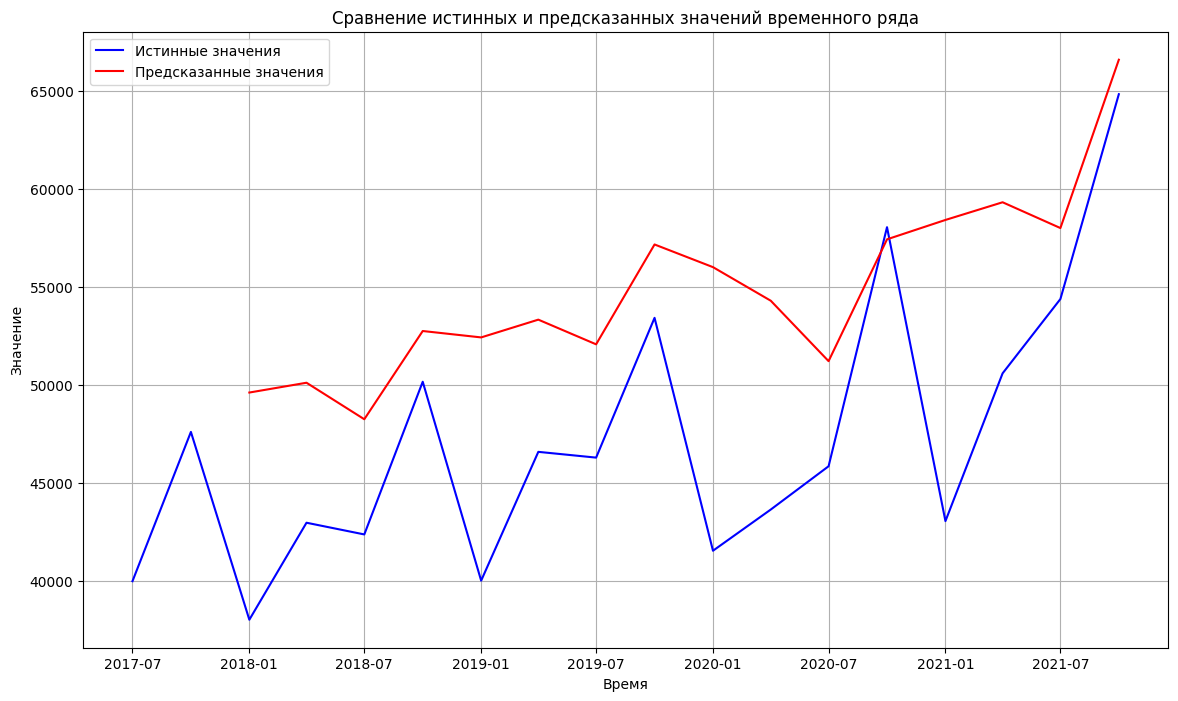

[I 2024-10-18 09:59:30,960] Trial 14 finished with value: 10977.526850824437 and parameters: {'window_size': 3, 'batch_size': 31, 'shuffle_buffer': 384}. Best is trial 11 with value: 10166.392475916655.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 3.1199 - mae: 1.6056
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 860.6301 - mae: 27.9372
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 111.9013 - mae: 10.0878
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 17.3898 - mae: 3.9916
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 166.4244 - mae: 12.3439
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 199.9913 - mae: 13.5131
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 137.1120 - mae: 11.1493
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 57.3174 - mae: 7.2043
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 9.8084 - mae: 2.9281
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.8600 - mae: 0.8737
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 15.9287 - mae: 3.8750
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 35.5575 - mae: 5.7808
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━

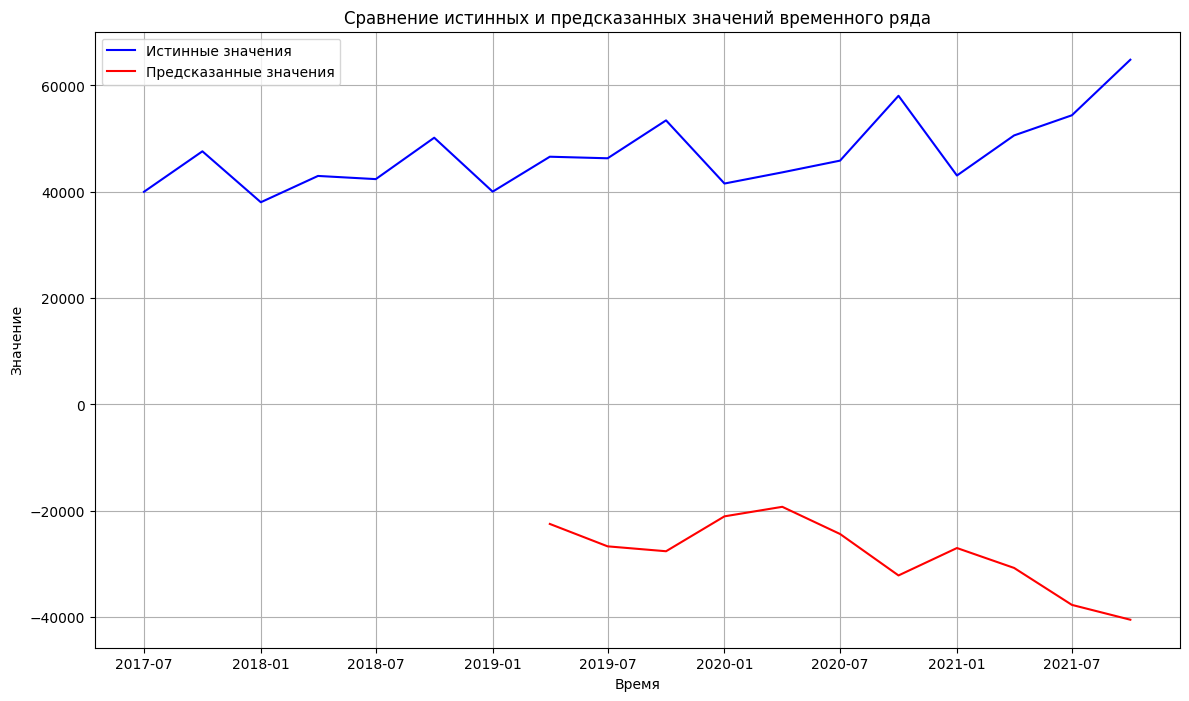

[I 2024-10-18 09:59:45,175] Trial 15 finished with value: 78541.85441215389 and parameters: {'window_size': 8, 'batch_size': 32, 'shuffle_buffer': 346}. Best is trial 11 with value: 10166.392475916655.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 1.9418 - mae: 1.3031
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 1046.6735 - mae: 31.0799
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 135.7464 - mae: 11.2274
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 12.9671 - mae: 3.4046
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 154.1336 - mae: 11.9758
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 207.0311 - mae: 13.7998
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - loss: 138.0335 - mae: 11.2836
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 66.1993 - mae: 7.7335
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 14.3658 - mae: 3.5216
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.3670 - mae: 0.5055
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 13.9250 - mae: 3.6728
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 34.0340 - mae: 5.7150
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━

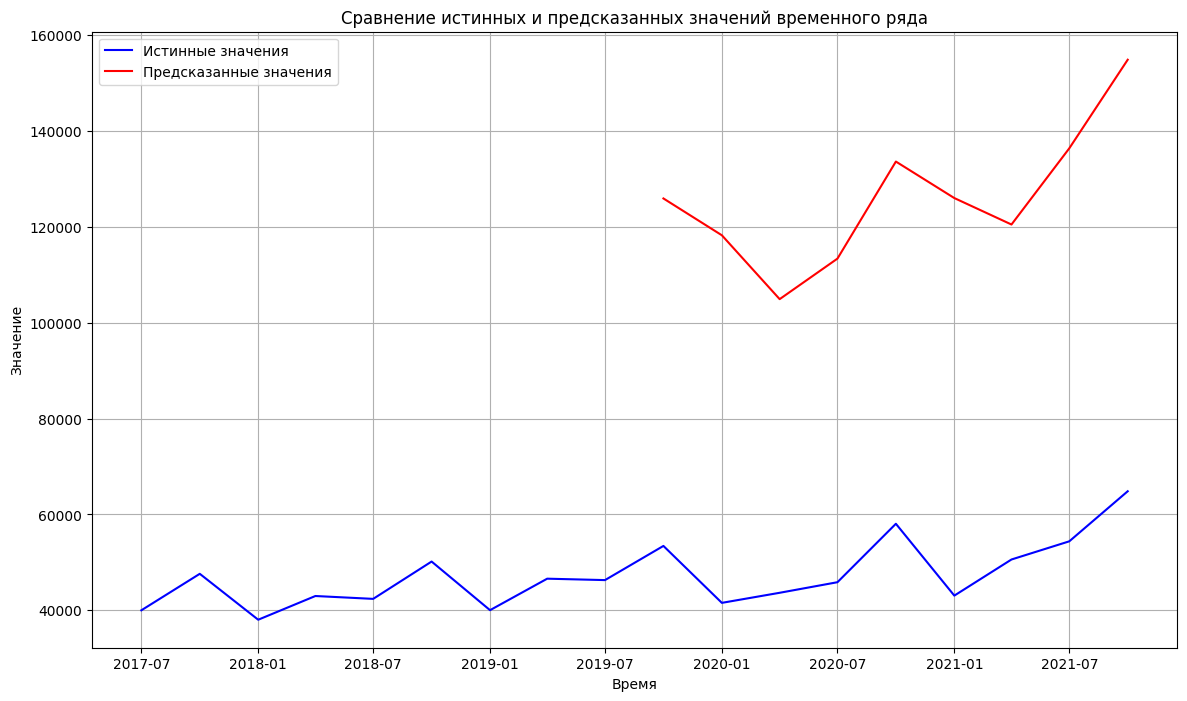

[I 2024-10-18 10:00:00,319] Trial 16 finished with value: 76975.08656163042 and parameters: {'window_size': 10, 'batch_size': 34, 'shuffle_buffer': 287}. Best is trial 11 with value: 10166.392475916655.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 1.8055 - mae: 1.2172
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 267.8196 - mae: 15.4662
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 36.1407 - mae: 5.7108
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 7.8004 - mae: 2.6510
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 69.4903 - mae: 7.8553
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 78.3907 - mae: 8.3707
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 49.1050 - mae: 6.6165
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 17.4642 - mae: 3.8968
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 1.6158 - mae: 1.0572
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 2.5681 - mae: 1.5604
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 13.2160 - mae: 3.5128
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 21.9029 - mae: 4.4932
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19

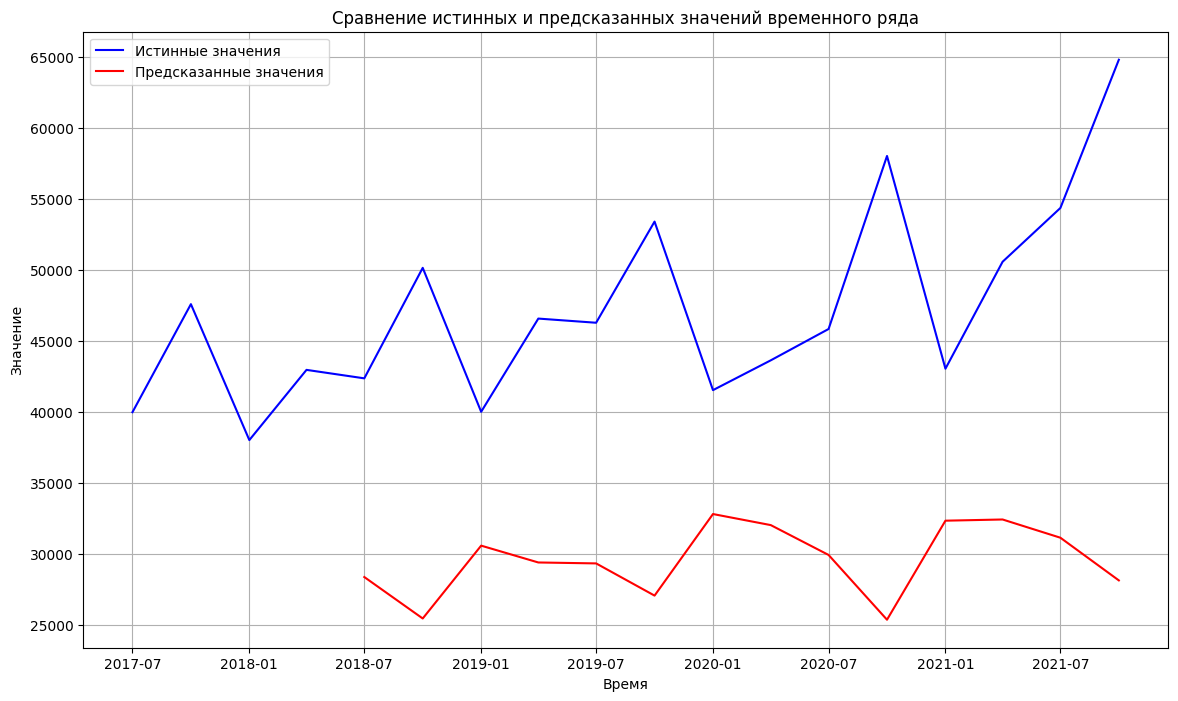

[I 2024-10-18 10:00:14,531] Trial 17 finished with value: 20354.033295171594 and parameters: {'window_size': 5, 'batch_size': 25, 'shuffle_buffer': 468}. Best is trial 11 with value: 10166.392475916655.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.1450 - mae: 0.3073
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 105.0080 - mae: 9.6605
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 14.0384 - mae: 3.5165
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 4.9430 - mae: 2.0999
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 31.8297 - mae: 5.3556
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 39.2720 - mae: 5.9014
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 24.4930 - mae: 4.6654
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 8.3693 - mae: 2.6834
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.3883 - mae: 0.5228
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 1.8457 - mae: 1.3162
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 7.4638 - mae: 2.6201
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 11.8402 - mae: 3.2871
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms

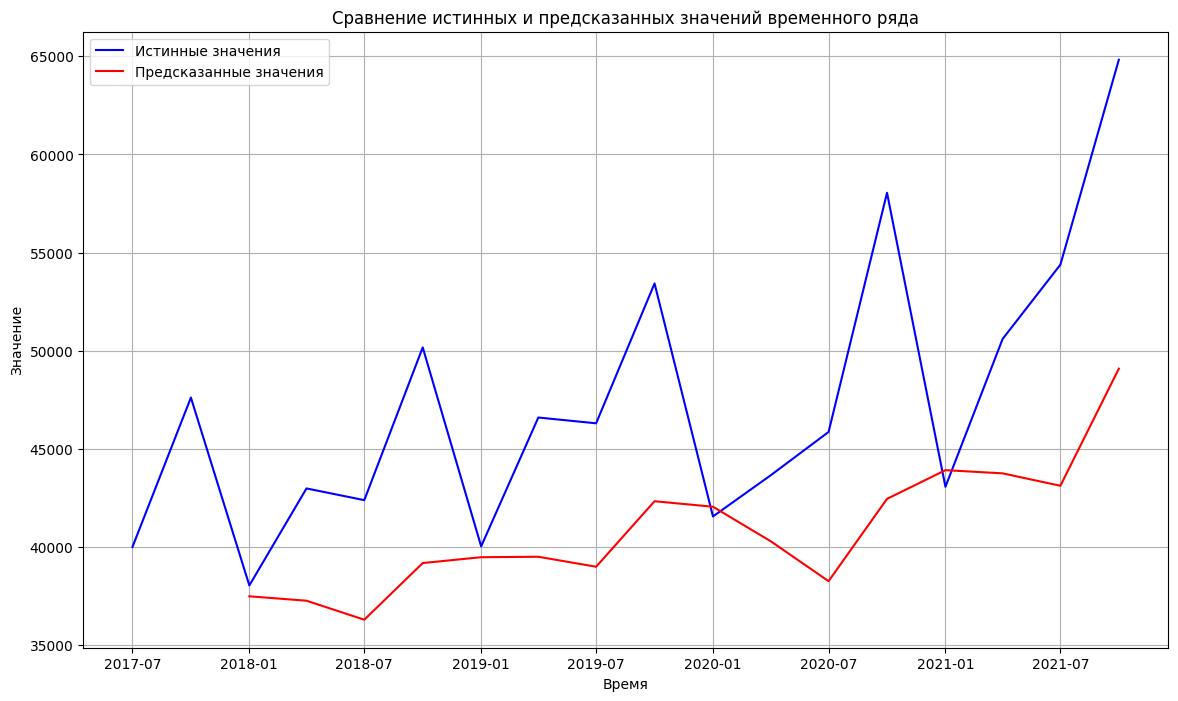

[I 2024-10-18 10:00:27,827] Trial 18 finished with value: 10227.149892082354 and parameters: {'window_size': 3, 'batch_size': 36, 'shuffle_buffer': 665}. Best is trial 11 with value: 10166.392475916655.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.4170 - mae: 0.5140
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 759.1716 - mae: 26.1878
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 100.1420 - mae: 9.5292
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 14.9589 - mae: 3.6772
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 142.2994 - mae: 11.3765
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 181.9406 - mae: 12.8272
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 127.3680 - mae: 10.7380
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 53.6521 - mae: 6.9200
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 8.9145 - mae: 2.7540
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 1.3675 - mae: 1.1185
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 18.8558 - mae: 4.2036
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 37.2368 - mae: 5.8860
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━

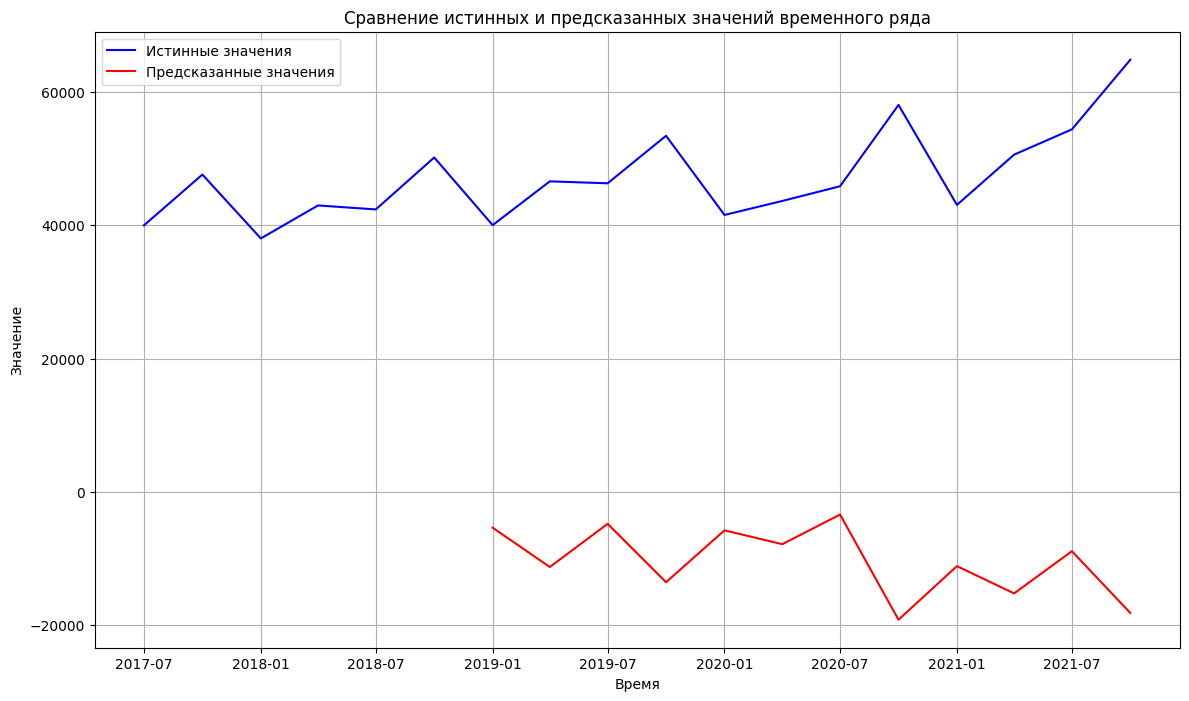

[I 2024-10-18 10:00:42,419] Trial 19 finished with value: 60034.355101455425 and parameters: {'window_size': 7, 'batch_size': 57, 'shuffle_buffer': 696}. Best is trial 11 with value: 10166.392475916655.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 11.4640 - mae: 3.0973
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 146.5414 - mae: 11.5113
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 24.3112 - mae: 4.7152
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 2.9092 - mae: 1.5403
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 35.5424 - mae: 5.5815
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 45.6862 - mae: 6.3384
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 28.6377 - mae: 4.9878
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 9.5248 - mae: 2.8270
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.5248 - mae: 0.6009
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 2.7500 - mae: 1.6182
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 9.6947 - mae: 3.0056
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 13.6370 - mae: 3.5651
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232

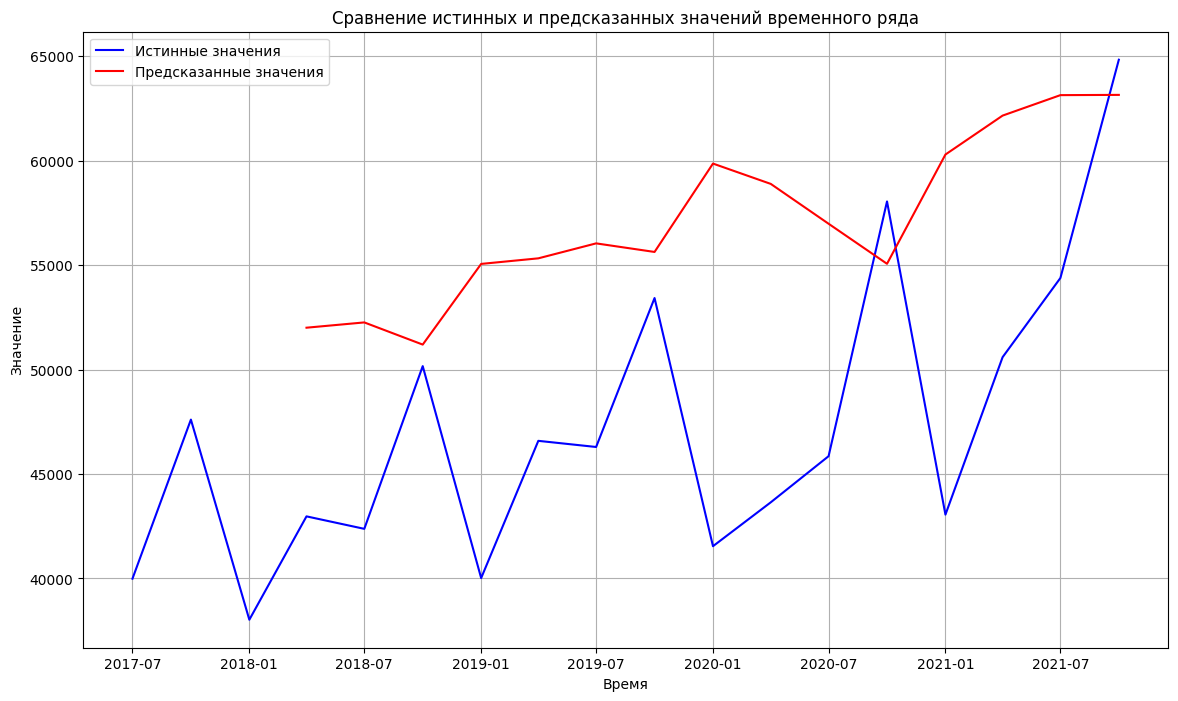

[I 2024-10-18 10:00:56,204] Trial 20 finished with value: 11781.192195811387 and parameters: {'window_size': 4, 'batch_size': 42, 'shuffle_buffer': 685}. Best is trial 11 with value: 10166.392475916655.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 2.8882 - mae: 1.5393
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 76.9312 - mae: 8.3068
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 11.2628 - mae: 3.1768
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 3.4274 - mae: 1.6990
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 23.2028 - mae: 4.5054
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 25.7112 - mae: 4.7667
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 15.0852 - mae: 3.6273
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 3.9396 - mae: 1.8114
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0679 - mae: 0.2115
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 2.8198 - mae: 1.6156
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 7.0104 - mae: 2.5373
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 9.0986 - mae: 2.8614
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/s

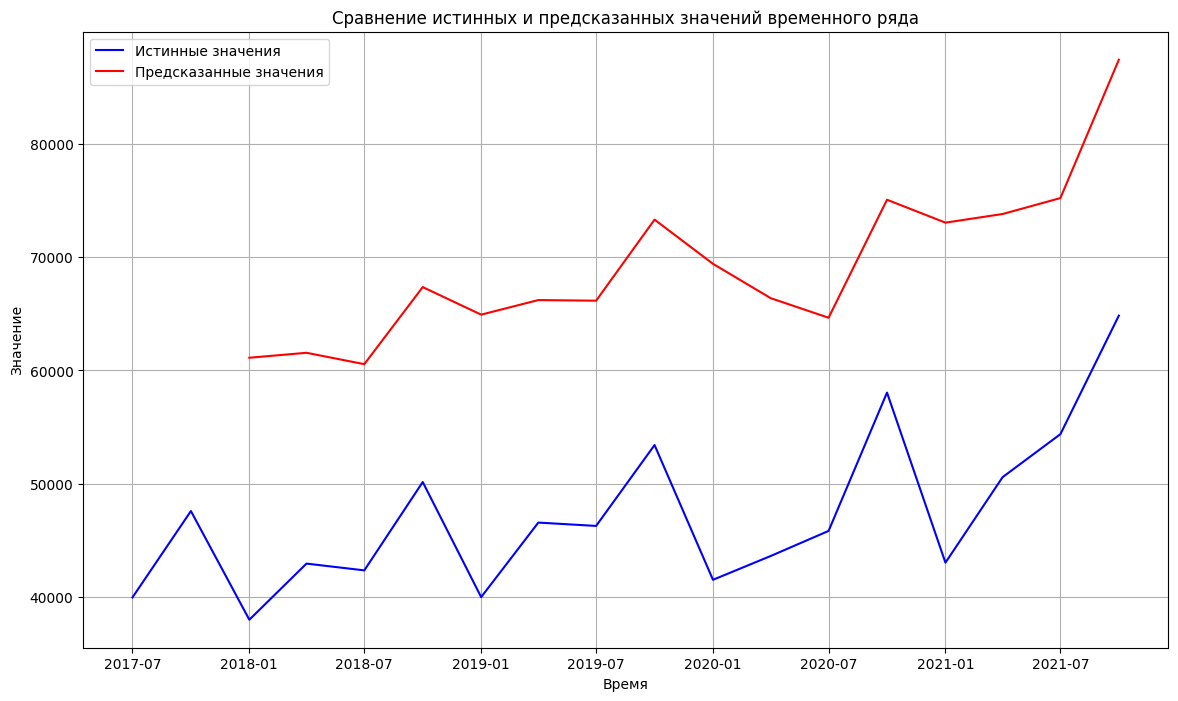

[I 2024-10-18 10:01:09,850] Trial 21 finished with value: 23586.440445504206 and parameters: {'window_size': 3, 'batch_size': 37, 'shuffle_buffer': 613}. Best is trial 11 with value: 10166.392475916655.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 1.1133 - mae: 0.9368
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 97.5162 - mae: 9.3314
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 13.5405 - mae: 3.4718
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 4.8274 - mae: 2.0501
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 31.9279 - mae: 5.3240
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 34.7683 - mae: 5.5323
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 20.5261 - mae: 4.2283
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 4.9027 - mae: 2.0356
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.0697 - mae: 0.2116
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 3.5095 - mae: 1.8080
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 9.0739 - mae: 2.8956
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 12.1529 - mae: 3.3309
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/

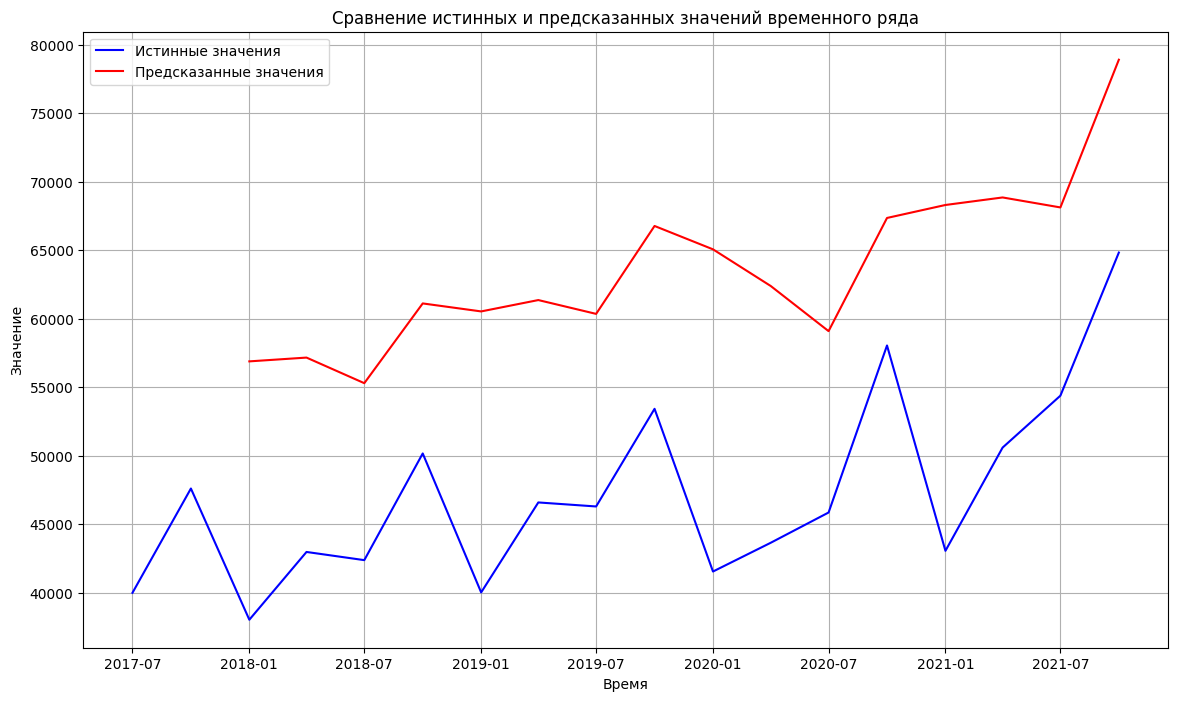

[I 2024-10-18 10:01:23,896] Trial 22 finished with value: 18380.74354209806 and parameters: {'window_size': 3, 'batch_size': 28, 'shuffle_buffer': 253}. Best is trial 11 with value: 10166.392475916655.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.0607 - mae: 0.1912
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.2371 - mae: 0.3883
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 80.1618 - mae: 8.3711
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 1.7943 - mae: 1.1227
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 35.3057 - mae: 5.7148
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 44.6167 - mae: 6.3938
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 18.1713 - mae: 4.1092
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 1.3950 - mae: 1.1419
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 3.0526 - mae: 1.5937
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 14.4213 - mae: 3.5374
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 16.6203 - mae: 3.8037
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 11.6018 - mae: 3.1791
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms

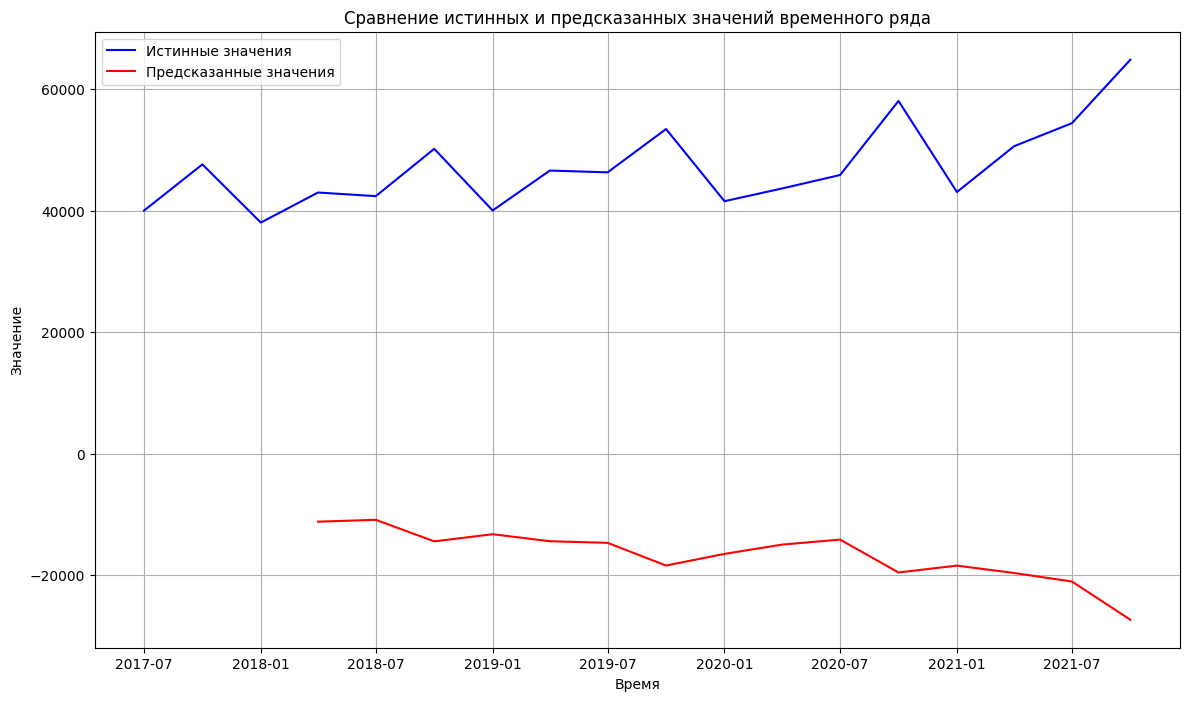

[I 2024-10-18 10:01:37,692] Trial 23 finished with value: 65334.404426505 and parameters: {'window_size': 4, 'batch_size': 35, 'shuffle_buffer': 484}. Best is trial 11 with value: 10166.392475916655.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.2430 - mae: 0.4065
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 318.5383 - mae: 16.9270
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 42.4638 - mae: 6.1601
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 9.9229 - mae: 2.9965
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 82.6111 - mae: 8.6057
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 98.4993 - mae: 9.3791
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 63.5587 - mae: 7.5097
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 22.7504 - mae: 4.4802
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 2.6656 - mae: 1.4476
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 1.9796 - mae: 1.3549
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 14.1614 - mae: 3.6355
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 22.8618 - mae: 4.5948
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20

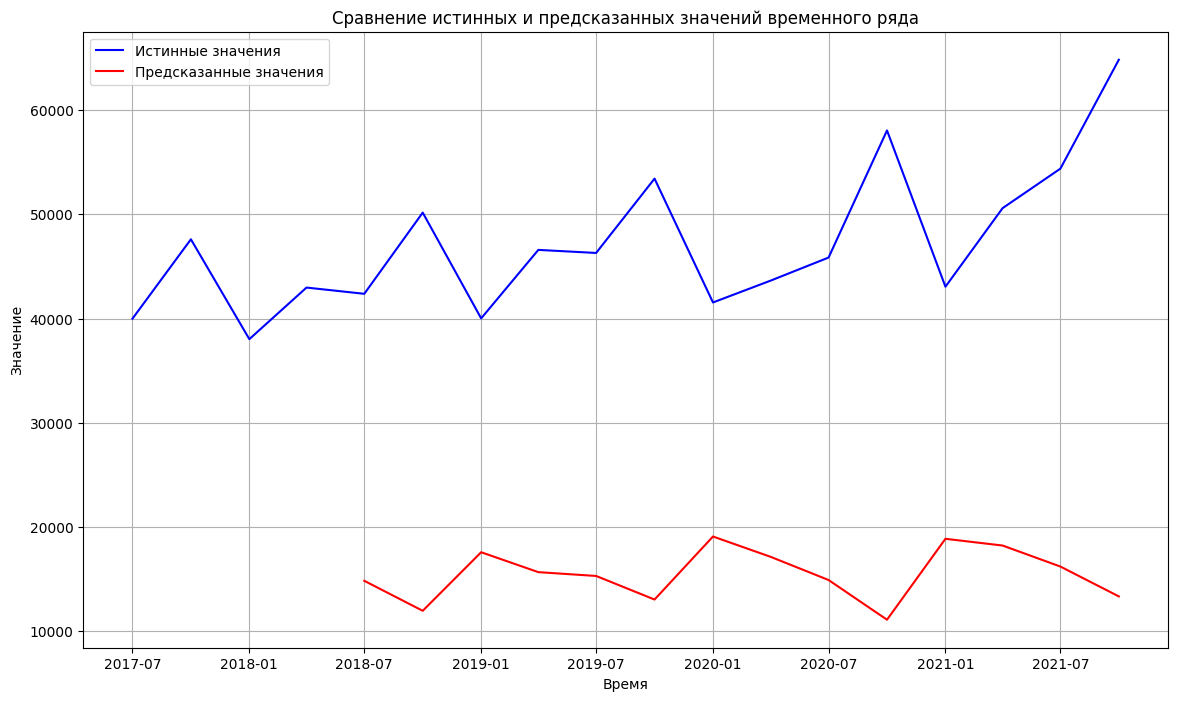

[I 2024-10-18 10:01:51,896] Trial 24 finished with value: 33885.13769136038 and parameters: {'window_size': 5, 'batch_size': 45, 'shuffle_buffer': 433}. Best is trial 11 with value: 10166.392475916655.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 9.6422 - mae: 1.6575
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 7.5731 - mae: 2.5766
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 32.1339 - mae: 5.3409
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 11.5721 - mae: 3.1086
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.4590 - mae: 1.0379
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 10.7920 - mae: 3.1282
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 7.1955 - mae: 2.5304
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.8341 - mae: 0.8121
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.0925 - mae: 1.0067
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 3.5582 - mae: 1.8218
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 3.5636 - mae: 1.8074
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.2948 - mae: 1.0723
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - lo

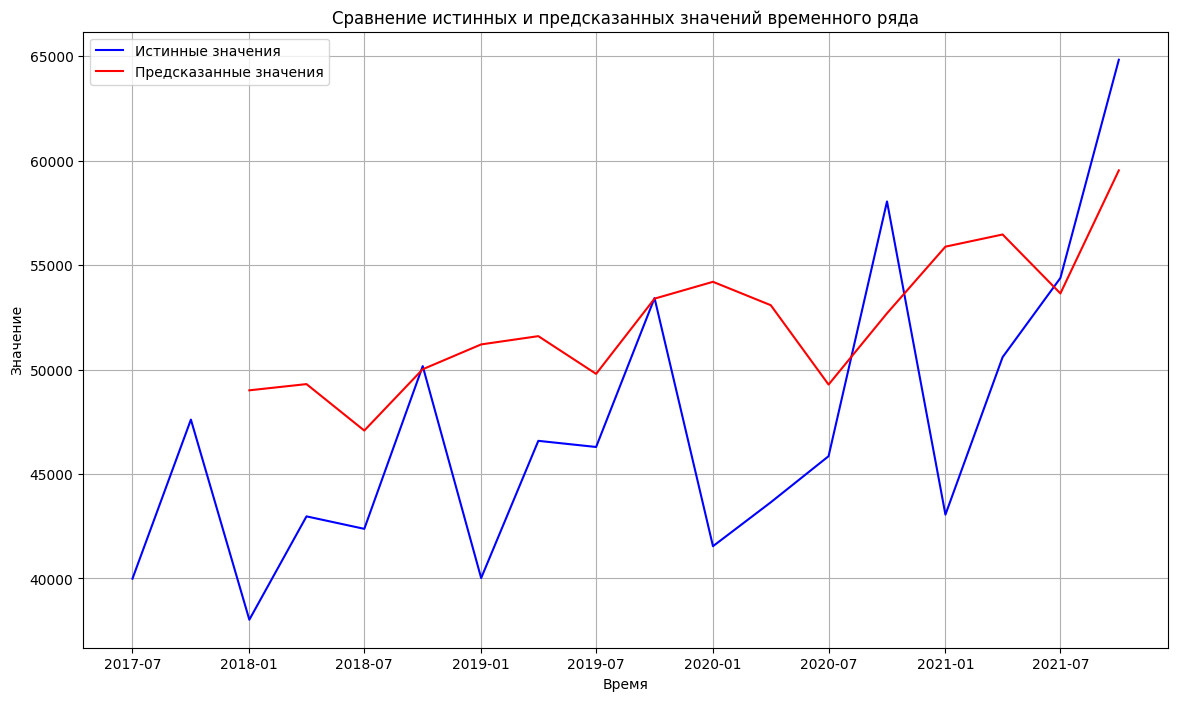

[I 2024-10-18 10:02:07,329] Trial 25 finished with value: 8954.195096250756 and parameters: {'window_size': 3, 'batch_size': 22, 'shuffle_buffer': 630}. Best is trial 25 with value: 8954.195096250756.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 21.6188 - mae: 1.9661
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 18.0620 - mae: 3.9953
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 58.2660 - mae: 7.1929
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 19.6826 - mae: 4.0824
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 2.5184 - mae: 1.3612
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 18.4045 - mae: 4.0833
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 13.1633 - mae: 3.4185
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 2.6942 - mae: 1.4436
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.7779 - mae: 0.8163
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 4.9357 - mae: 2.1810
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 6.2672 - mae: 2.4428
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 3.3578 - mae: 1.7915
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - lo

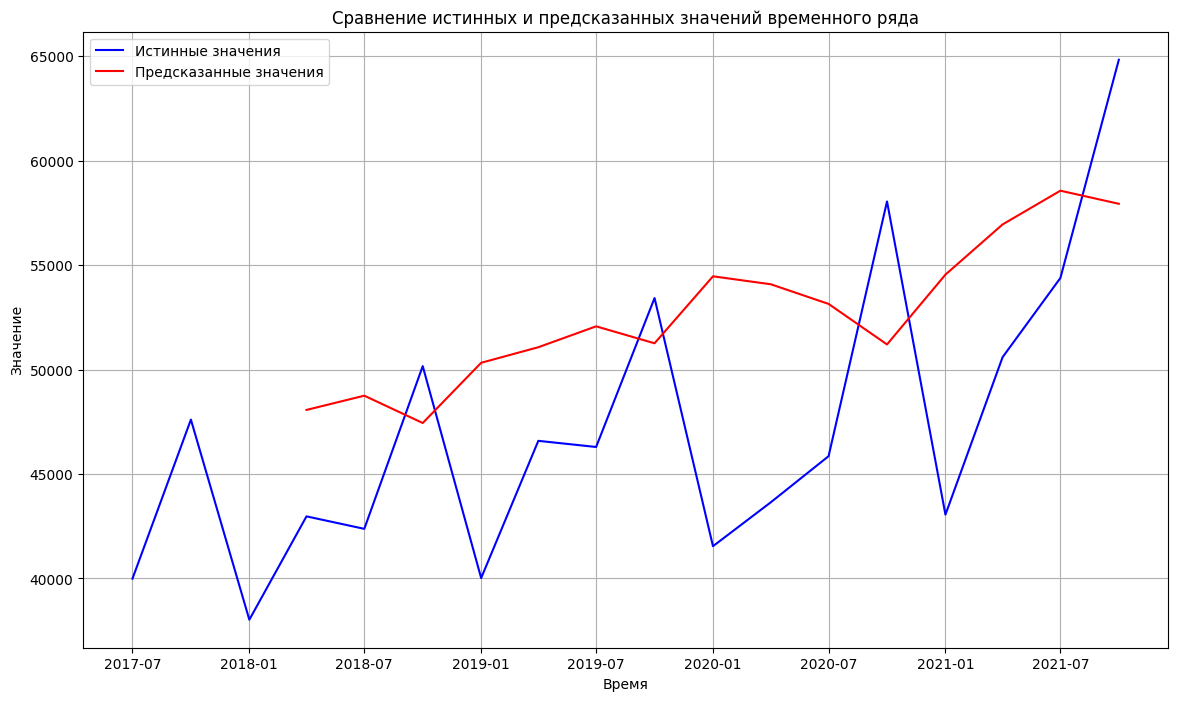

[I 2024-10-18 10:02:30,082] Trial 26 finished with value: 8706.512577157546 and parameters: {'window_size': 4, 'batch_size': 21, 'shuffle_buffer': 763}. Best is trial 26 with value: 8706.512577157546.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 24.7812 - mae: 3.7466
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 11.5599 - mae: 3.2287
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 49.8886 - mae: 6.6214
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 21.9319 - mae: 4.2798
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.8794 - mae: 0.6361
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 9.2704 - mae: 2.9711
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 7.6297 - mae: 2.6822
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 1.1865 - mae: 1.0035
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.9290 - mae: 0.8172
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 3.4739 - mae: 1.7138
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 2.9667 - mae: 1.5826
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.9632 - mae: 0.8794
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss

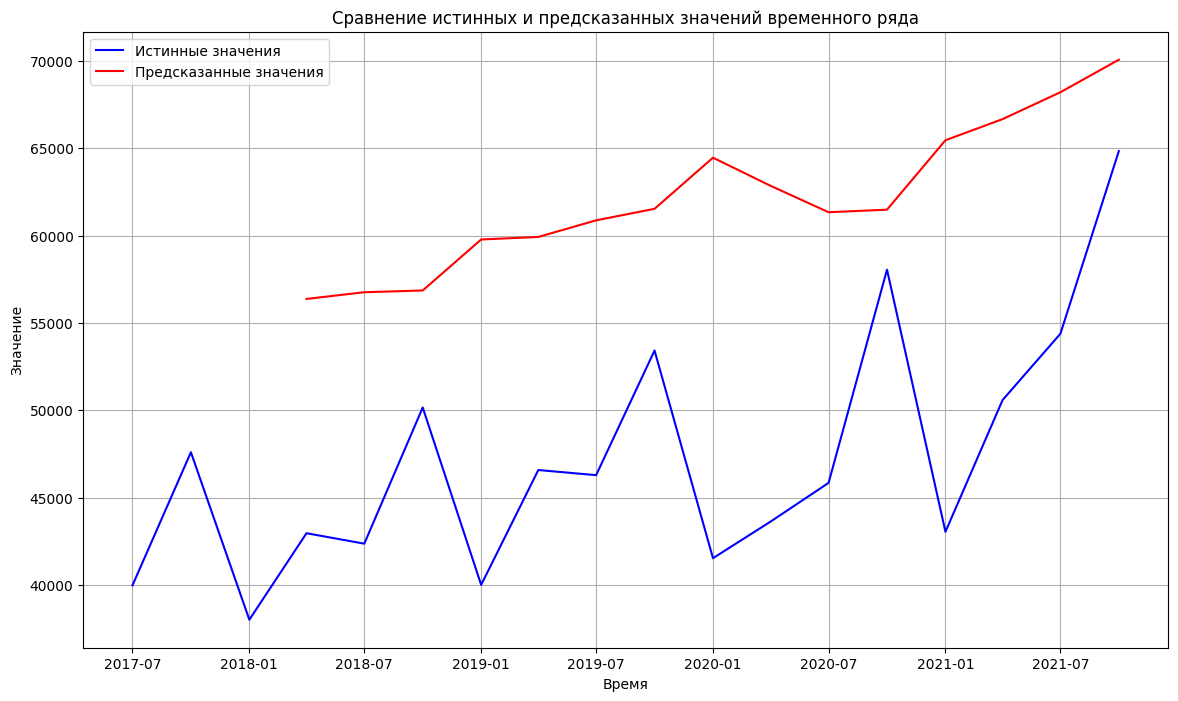

[I 2024-10-18 10:02:47,582] Trial 27 finished with value: 15969.514749562553 and parameters: {'window_size': 4, 'batch_size': 20, 'shuffle_buffer': 753}. Best is trial 26 with value: 8706.512577157546.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.6381 - mae: 0.6512
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 533.8260 - mae: 21.9065
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 68.4380 - mae: 7.8239
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 17.6101 - mae: 3.9672
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 122.9414 - mae: 10.5348
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 141.5636 - mae: 11.3174
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 96.0857 - mae: 9.2757
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 38.3579 - mae: 5.8497
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 6.4394 - mae: 2.3583
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 1.0967 - mae: 1.0067
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 13.4668 - mae: 3.5174
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 25.8419 - mae: 4.8852
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 

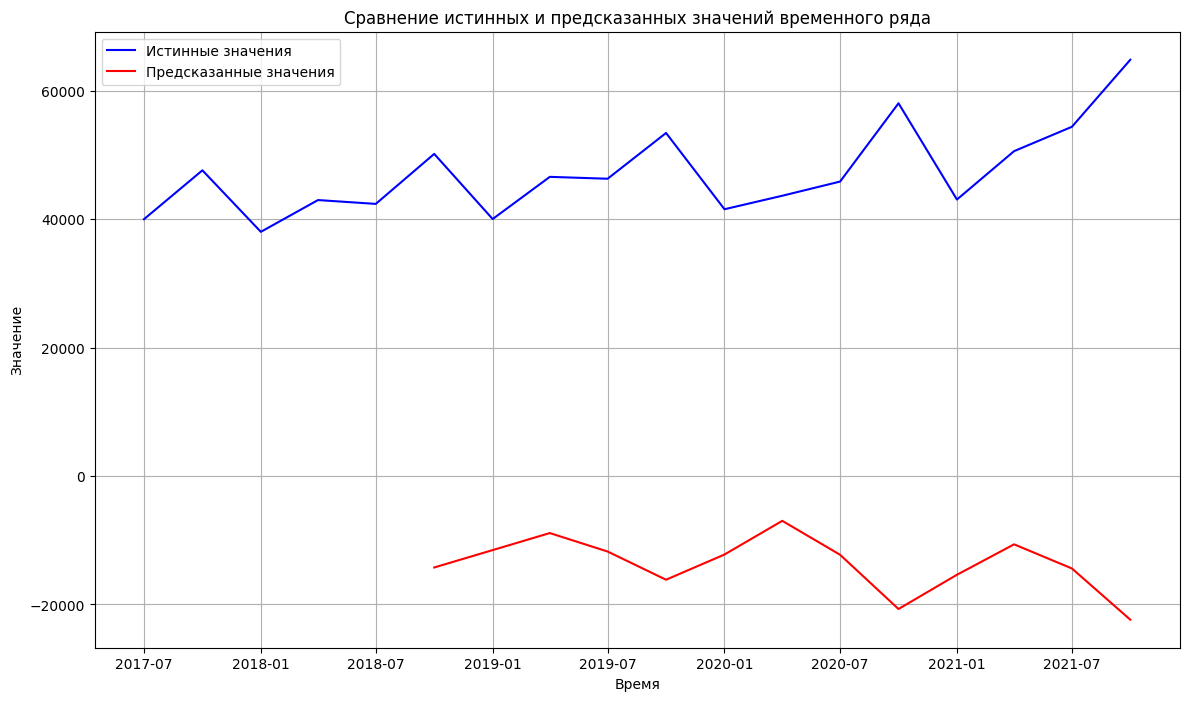

[I 2024-10-18 10:03:02,317] Trial 28 finished with value: 63279.540958540834 and parameters: {'window_size': 6, 'batch_size': 24, 'shuffle_buffer': 616}. Best is trial 26 with value: 8706.512577157546.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 28.7503 - mae: 2.2998
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 18.0216 - mae: 3.8588
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 94.6856 - mae: 9.0988
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 12.1863 - mae: 2.9566
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 11.0670 - mae: 3.1413
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 24.6941 - mae: 4.7096
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 9.0943 - mae: 2.7897
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.3117 - mae: 0.4642
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 4.1719 - mae: 1.9862
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 7.4816 - mae: 2.6511
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 4.4595 - mae: 2.0249
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.7528 - mae: 0.7931
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/st

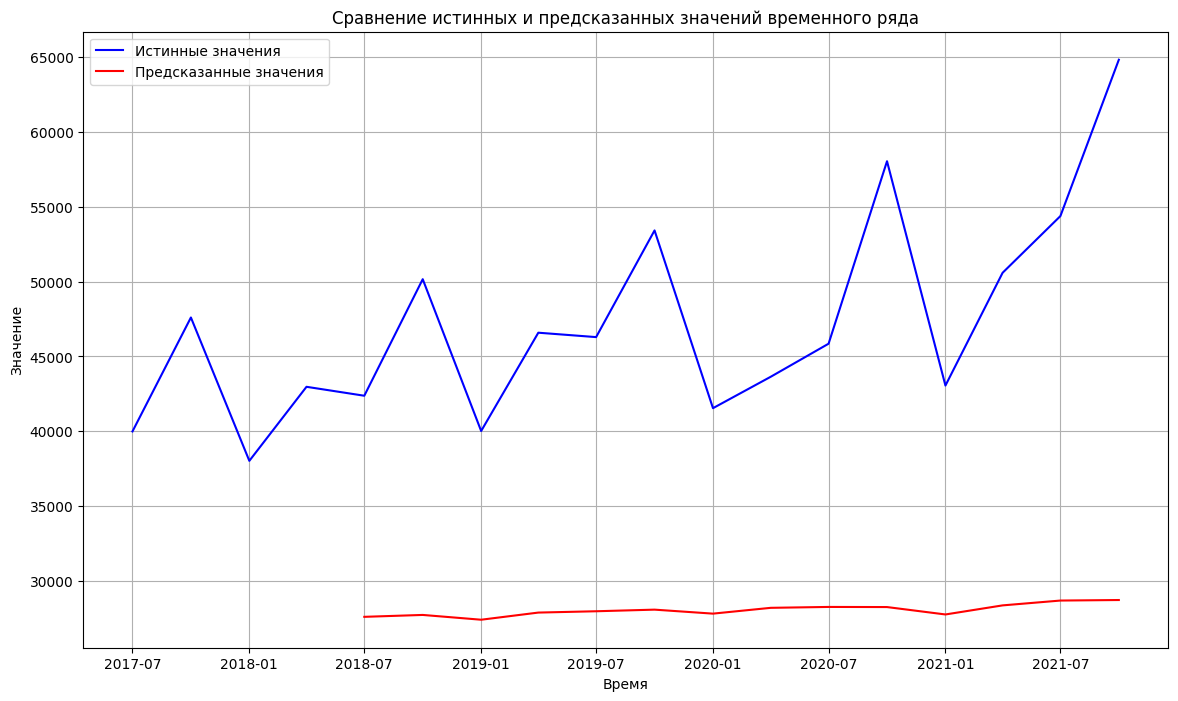

[I 2024-10-18 10:03:19,179] Trial 29 finished with value: 21678.087988908 and parameters: {'window_size': 5, 'batch_size': 19, 'shuffle_buffer': 921}. Best is trial 26 with value: 8706.512577157546.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 45.1888 - mae: 4.1242
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 12.6462 - mae: 3.3788
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 56.6342 - mae: 7.0817
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 24.2453 - mae: 4.4199
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 1.2886 - mae: 0.7661
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 11.9518 - mae: 3.3309
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 11.7029 - mae: 3.2793
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 3.2238 - mae: 1.6584
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.3437 - mae: 0.4055
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 2.5930 - mae: 1.5006
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 3.9226 - mae: 1.9004
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 2.6148 - mae: 1.5354
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/

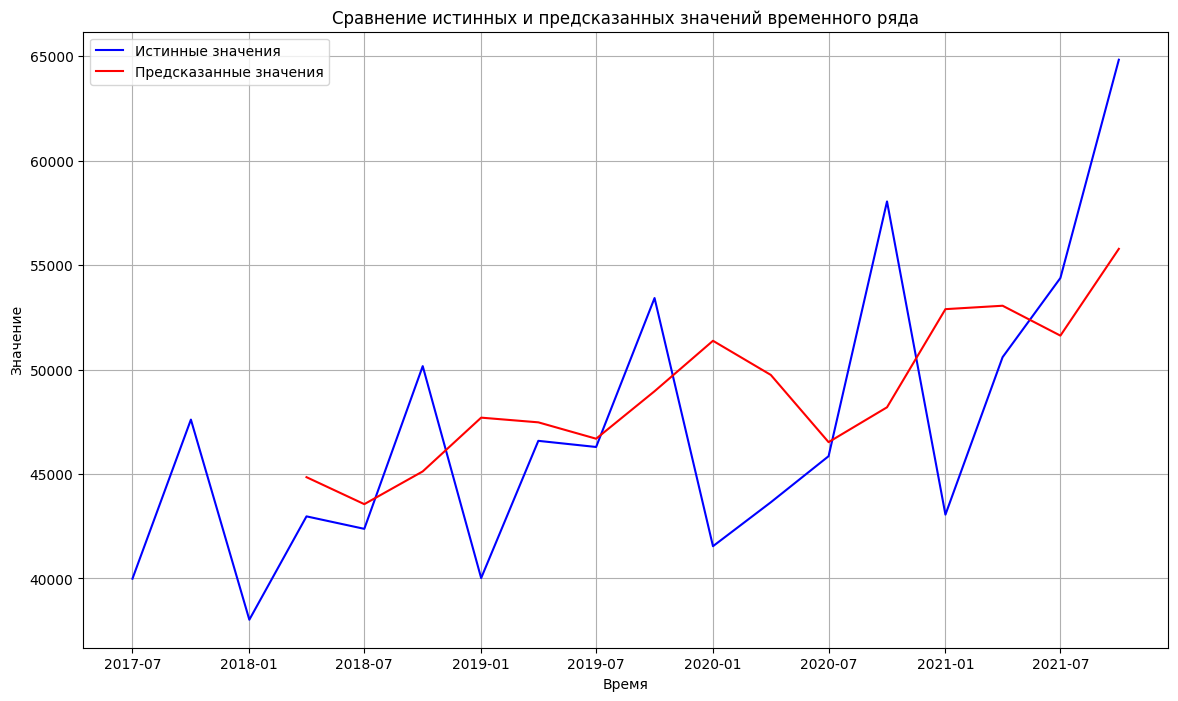

[I 2024-10-18 10:03:35,181] Trial 30 finished with value: 7548.889833651625 and parameters: {'window_size': 4, 'batch_size': 16, 'shuffle_buffer': 781}. Best is trial 30 with value: 7548.889833651625.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 48.5823 - mae: 3.8701
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 13.2858 - mae: 3.4646
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 58.1485 - mae: 7.1884
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 20.3586 - mae: 4.0937
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.3653 - mae: 0.7265
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 13.7206 - mae: 3.5709
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 13.5069 - mae: 3.4899
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 3.4562 - mae: 1.7063
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.2070 - mae: 0.3437
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 2.3905 - mae: 1.4802
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 4.1049 - mae: 1.9842
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 2.8265 - mae: 1.6393
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

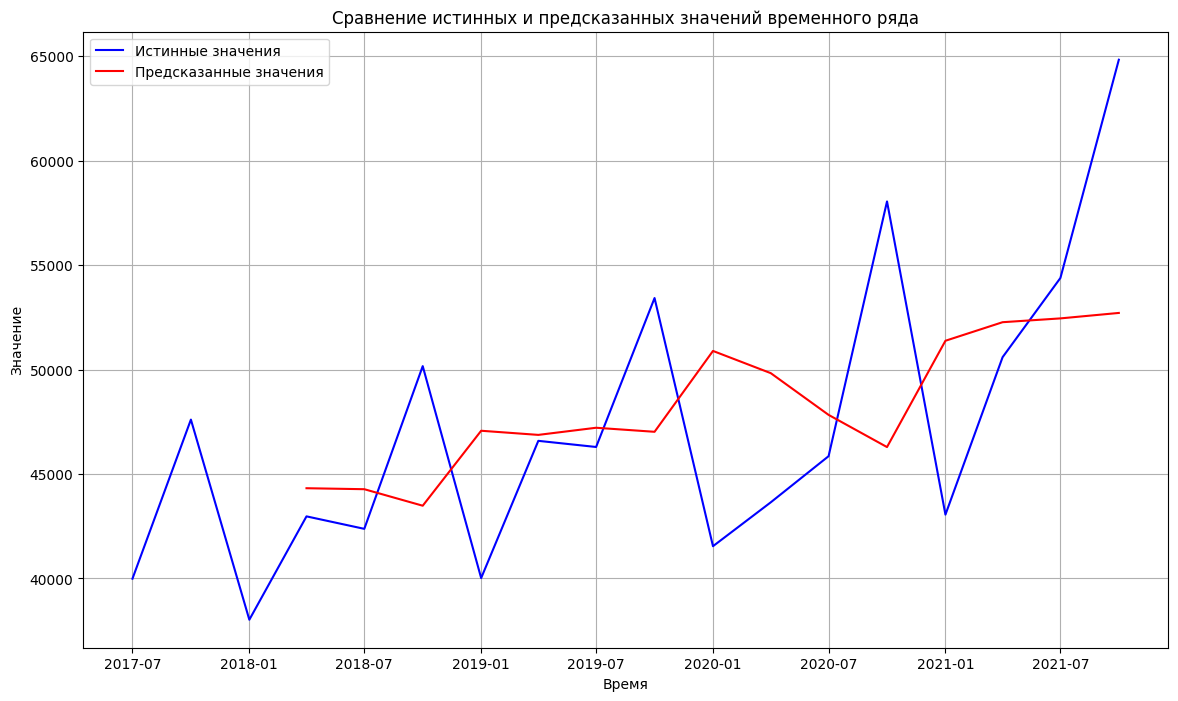

[I 2024-10-18 10:03:51,435] Trial 31 finished with value: 7379.017318289346 and parameters: {'window_size': 4, 'batch_size': 16, 'shuffle_buffer': 759}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 9.1474 - mae: 1.4807
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 19.6540 - mae: 4.1688
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 96.1216 - mae: 9.2868
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 40.8813 - mae: 6.0164
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.3917 - mae: 0.3839
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 25.1713 - mae: 4.7762
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 25.2159 - mae: 4.7773
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 6.6761 - mae: 2.3913
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1973 - mae: 0.3417
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 4.8508 - mae: 2.1456
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 8.0684 - mae: 2.7686
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 5.6127 - mae: 2.3038
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - l

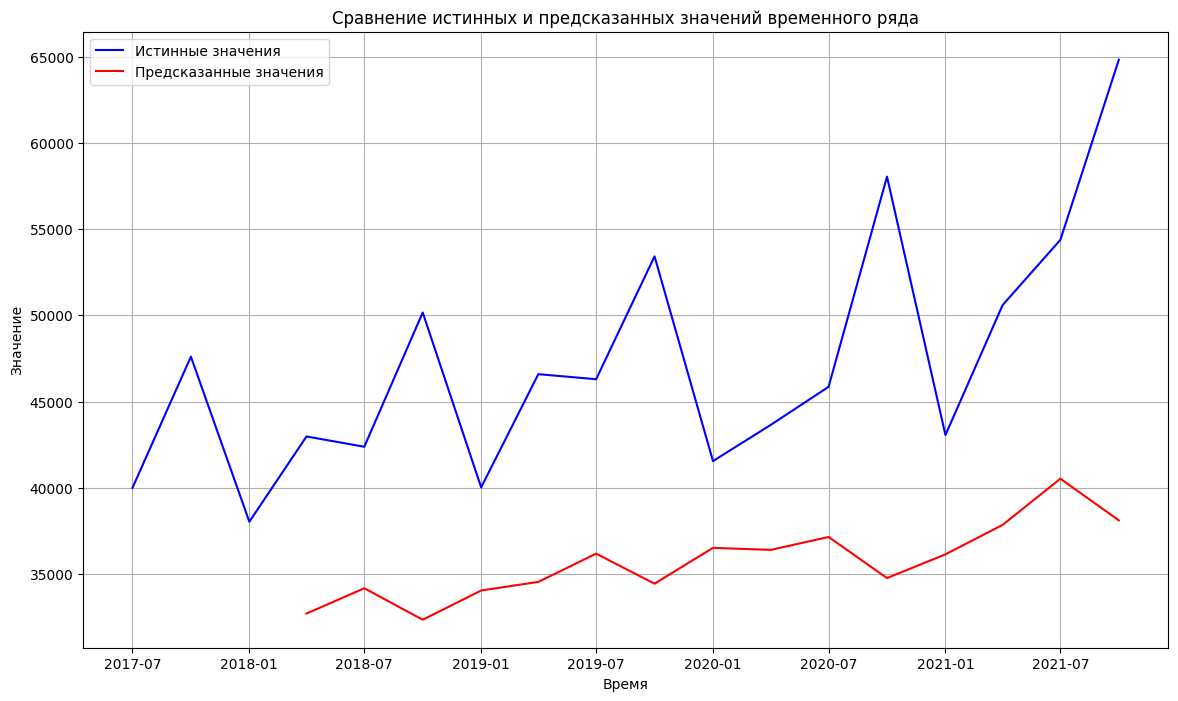

[I 2024-10-18 10:04:09,100] Trial 32 finished with value: 14381.966963570272 and parameters: {'window_size': 4, 'batch_size': 24, 'shuffle_buffer': 776}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 80.1687 - mae: 3.9417
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 27.0247 - mae: 4.9336
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 127.3383 - mae: 10.6969
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 95.8843 - mae: 9.0776
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 12.8978 - mae: 3.1264
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 6.7103 - mae: 2.4349
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 26.7230 - mae: 5.0596
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 18.9383 - mae: 4.2490
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 5.9084 - mae: 2.3192
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.3509 - mae: 0.3672
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 3.6373 - mae: 1.7676
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 7.1577 - mae: 2.5289
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

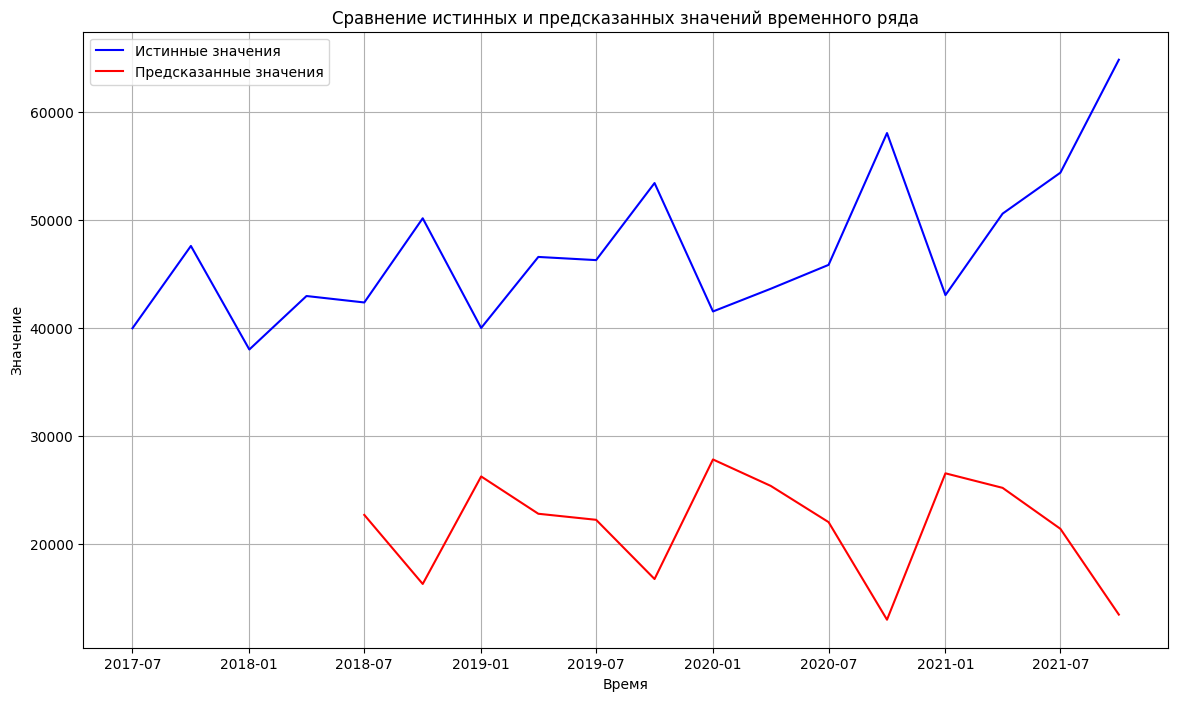

[I 2024-10-18 10:04:27,383] Trial 33 finished with value: 28269.4164822114 and parameters: {'window_size': 5, 'batch_size': 19, 'shuffle_buffer': 736}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 1.8046 - mae: 1.2353
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 181.8241 - mae: 12.7912
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 26.2351 - mae: 4.8511
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 8.0625 - mae: 2.6378
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 52.6354 - mae: 6.8174
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 58.3999 - mae: 7.1521
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 34.2731 - mae: 5.4791
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 10.0997 - mae: 2.9306
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step - loss: 0.4960 - mae: 0.5617
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 3.2155 - mae: 1.7558
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 11.3838 - mae: 3.2462
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - loss: 16.7652 - mae: 3.9280
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

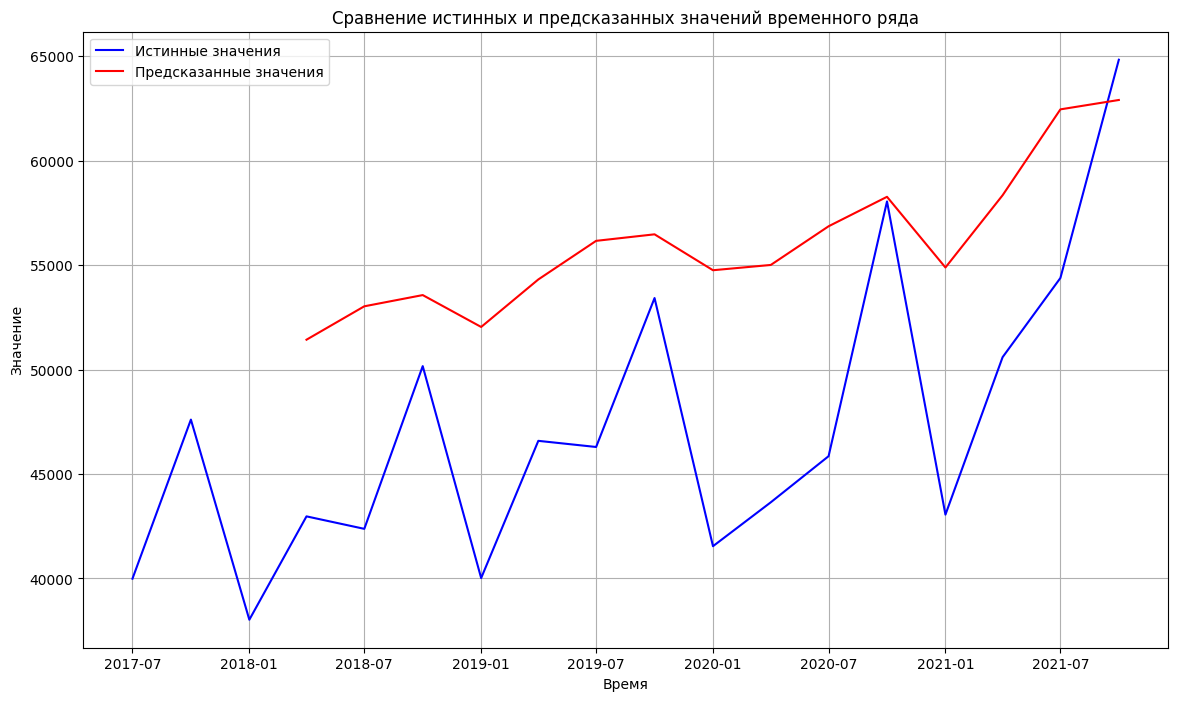

[I 2024-10-18 10:04:53,934] Trial 34 finished with value: 10790.682900404016 and parameters: {'window_size': 4, 'batch_size': 28, 'shuffle_buffer': 839}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 25.5510 - mae: 2.8321
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 23.1839 - mae: 4.5803
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 64.4892 - mae: 7.6001
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 31.4542 - mae: 5.2323
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.3321 - mae: 0.3585
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 17.3712 - mae: 4.0256
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 20.0436 - mae: 4.2738
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 5.8599 - mae: 2.2531
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1502 - mae: 0.2842
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 4.0178 - mae: 1.9499
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 6.3987 - mae: 2.4612
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 3.8789 - mae: 1.9102
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - 

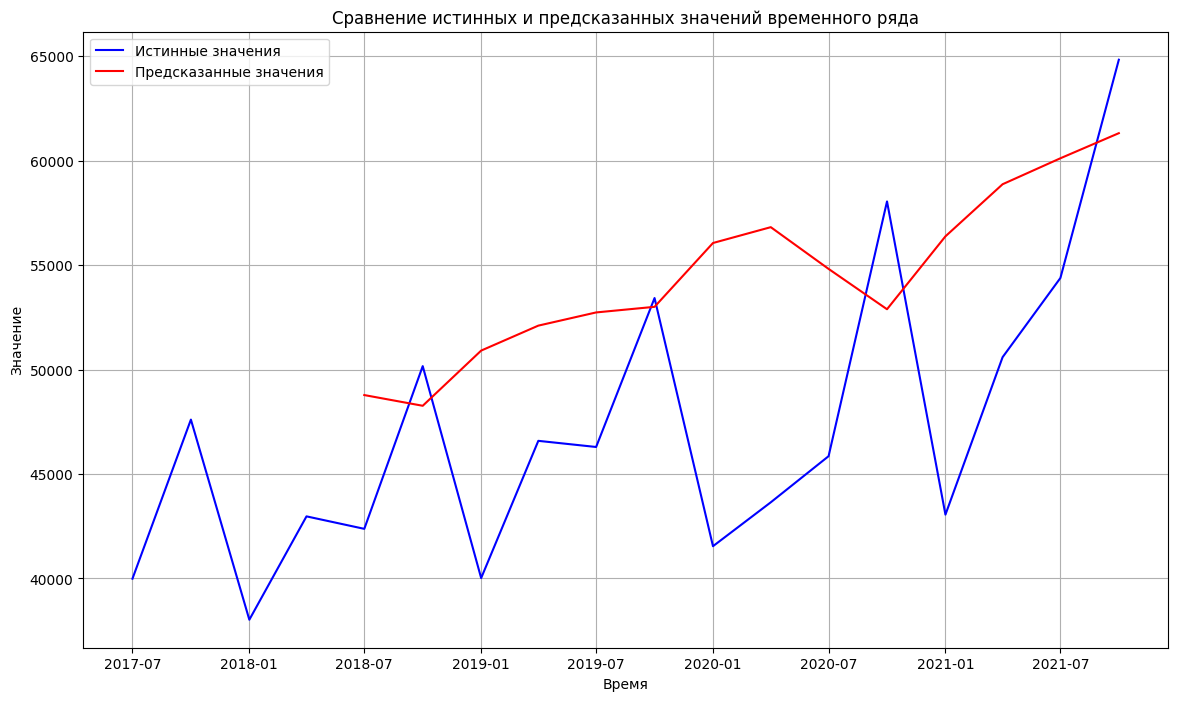

[I 2024-10-18 10:05:10,764] Trial 35 finished with value: 9782.316457805917 and parameters: {'window_size': 5, 'batch_size': 22, 'shuffle_buffer': 943}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 62.1060 - mae: 3.1280
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 29.2318 - mae: 5.0722
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 102.9354 - mae: 9.6146
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 35.8517 - mae: 5.4639
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 2.3414 - mae: 1.0659
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 20.8731 - mae: 4.3659
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 18.9422 - mae: 4.1444
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 4.5038 - mae: 1.9113
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.7437 - mae: 0.6987
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 4.8959 - mae: 2.1610
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 7.1790 - mae: 2.6073
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - loss: 3.9365 - mae: 1.9391
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12

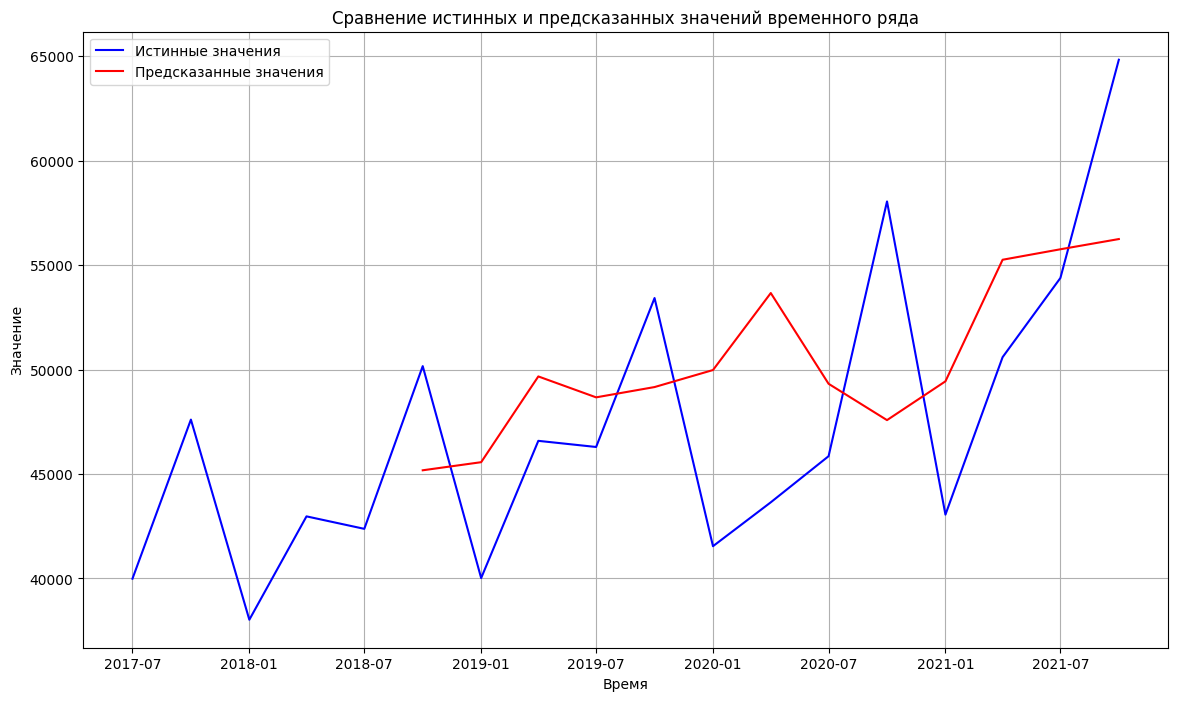

[I 2024-10-18 10:05:27,824] Trial 36 finished with value: 7811.912448308086 and parameters: {'window_size': 6, 'batch_size': 19, 'shuffle_buffer': 824}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 3.2156 - mae: 1.6180
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 537.7325 - mae: 22.1235
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 72.1970 - mae: 8.0745
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 14.1807 - mae: 3.5663
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 114.2172 - mae: 10.1848
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - loss: 132.9746 - mae: 10.9874
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 86.3036 - mae: 8.7566
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 28.6590 - mae: 5.0154
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 2.8427 - mae: 1.4808
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 4.6467 - mae: 2.1026
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 20.9114 - mae: 4.4314
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 32.3180 - mae: 5.5129
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 

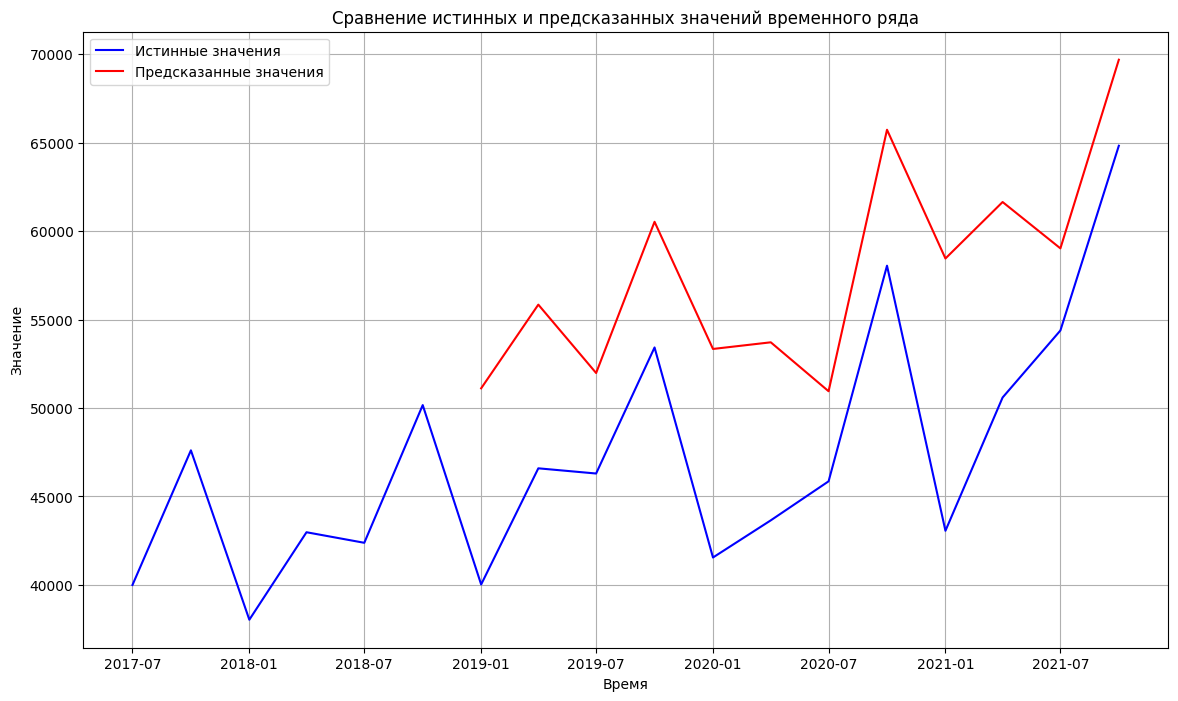

[I 2024-10-18 10:05:43,030] Trial 37 finished with value: 12576.847019720994 and parameters: {'window_size': 7, 'batch_size': 64, 'shuffle_buffer': 863}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - loss: 80.2297 - mae: 4.3381
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 32.6188 - mae: 5.4107
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 116.5614 - mae: 10.2585
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 56.1400 - mae: 6.9667
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 1.9706 - mae: 1.1862
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 16.3900 - mae: 3.9062
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 23.3329 - mae: 4.6532
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 8.1545 - mae: 2.6906
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2766 - mae: 0.4534
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 3.0197 - mae: 1.6552
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 6.5360 - mae: 2.4675
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 6.3230 - mae: 2.4103
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1

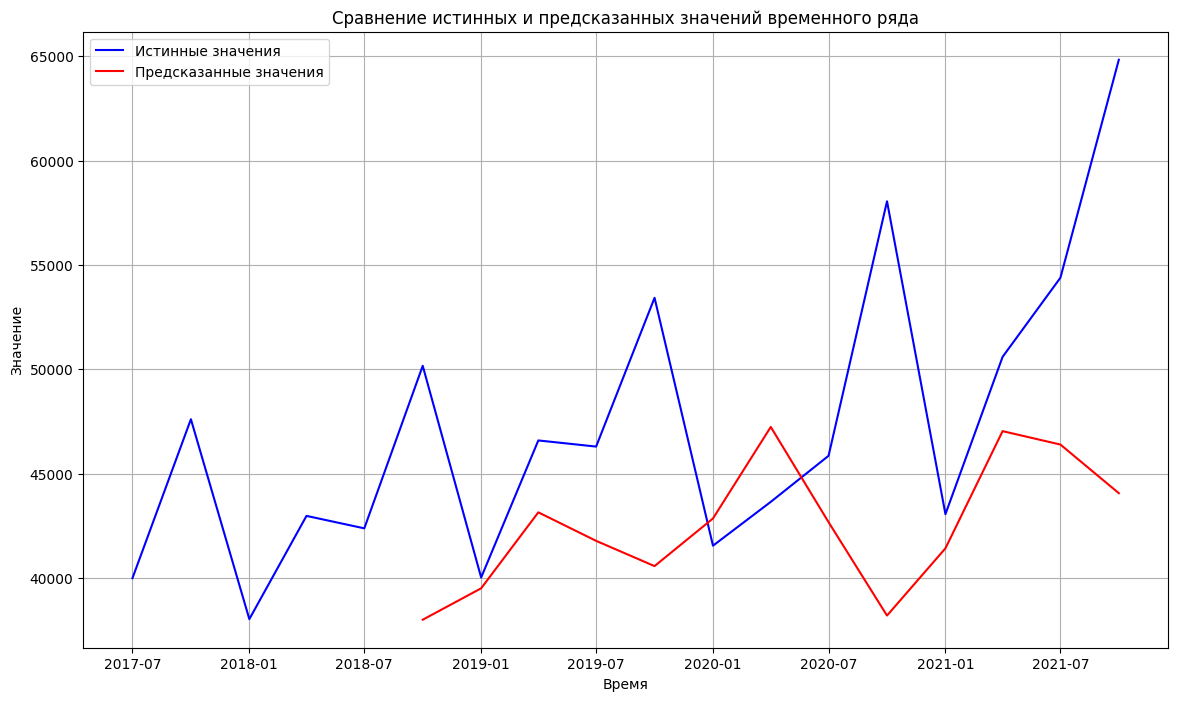

[I 2024-10-18 10:06:00,686] Trial 38 finished with value: 9945.453432855476 and parameters: {'window_size': 6, 'batch_size': 18, 'shuffle_buffer': 817}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.5937 - mae: 0.6597
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 475.7132 - mae: 20.6769
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 64.3966 - mae: 7.5996
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 14.1386 - mae: 3.5498
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 105.2460 - mae: 9.7695
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 126.3255 - mae: 10.6742
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 86.7527 - mae: 8.8103
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 33.2982 - mae: 5.4250
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 5.1537 - mae: 2.0318
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 1.3146 - mae: 1.1226
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 14.8351 - mae: 3.7465
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 26.4899 - mae: 4.9776
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

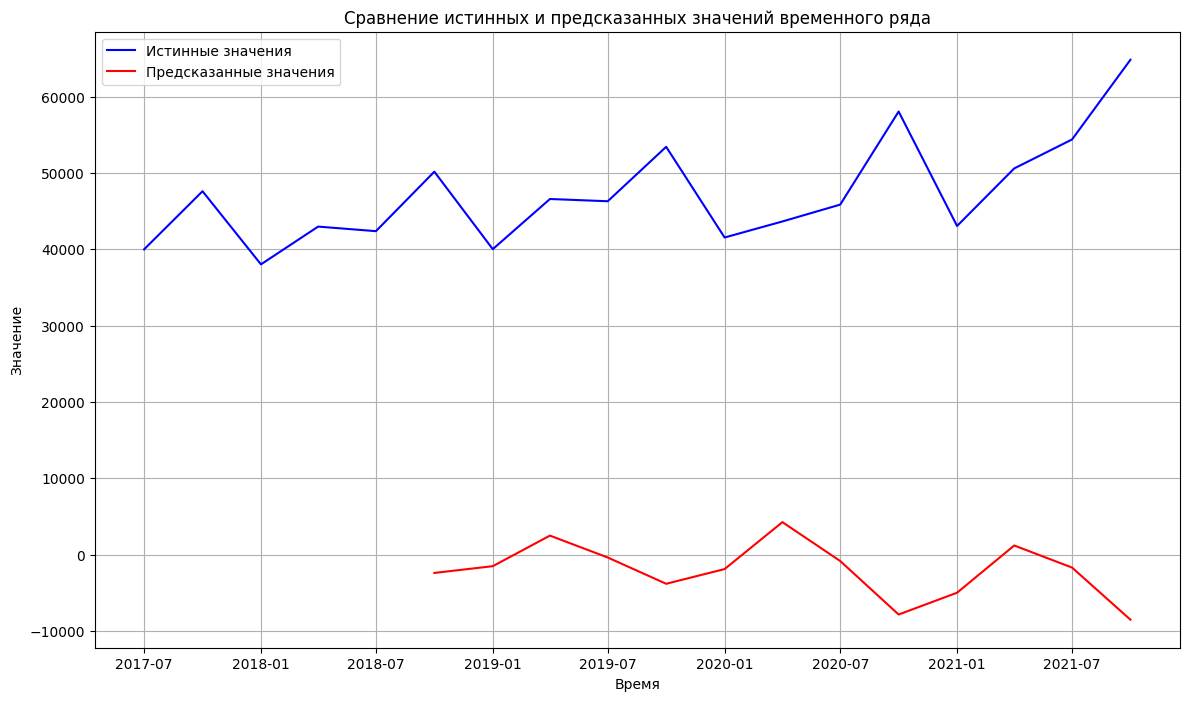

[I 2024-10-18 10:06:15,903] Trial 39 finished with value: 51674.069482924344 and parameters: {'window_size': 6, 'batch_size': 25, 'shuffle_buffer': 905}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - loss: 50.0850 - mae: 3.1538
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 28.5837 - mae: 3.8613
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 63.0011 - mae: 7.4094
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 3.6055 - mae: 1.3024
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 33.7541 - mae: 5.6158
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 17.1491 - mae: 3.9108
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.5737 - mae: 0.5521
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 7.6120 - mae: 2.6567
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 10.4829 - mae: 3.1340
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 5.3073 - mae: 2.2019
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3529 - mae: 0.5272
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 1.1262 - mae: 0.9826
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 257

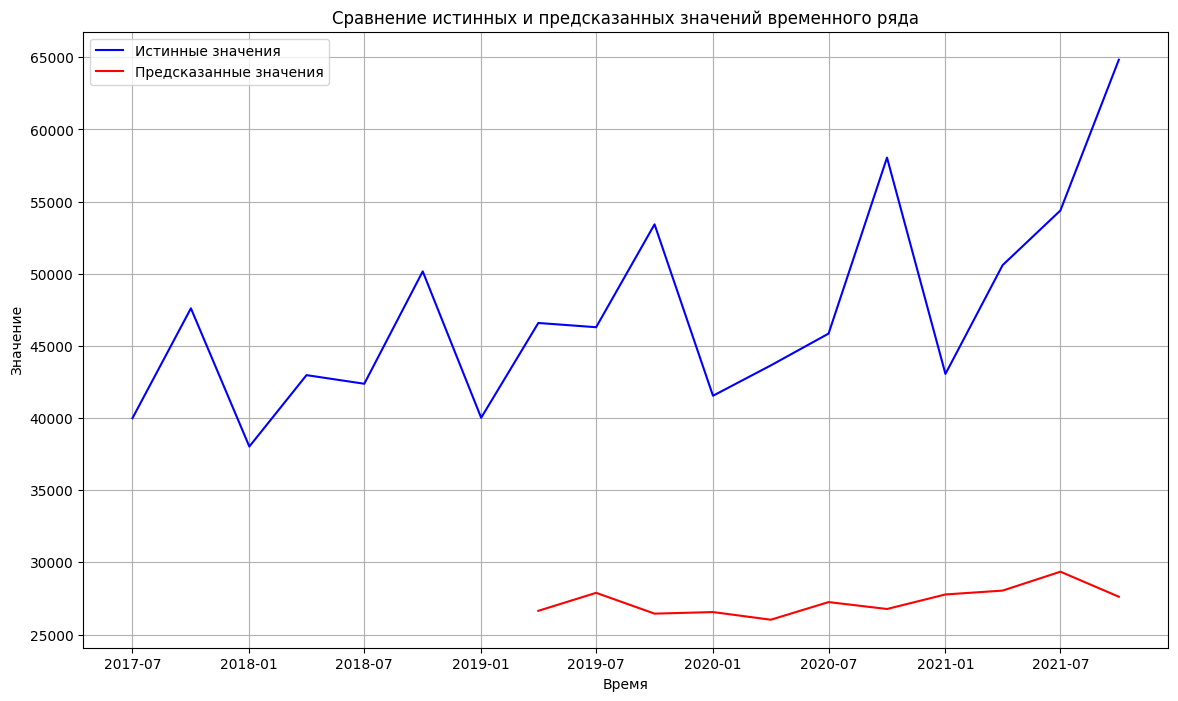

[I 2024-10-18 10:06:38,091] Trial 40 finished with value: 23576.145649570575 and parameters: {'window_size': 8, 'batch_size': 16, 'shuffle_buffer': 752}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 18.3202 - mae: 2.0252
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 15.6192 - mae: 3.7402
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 51.0465 - mae: 6.7524
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 16.2361 - mae: 3.7032
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 2.5526 - mae: 1.3482
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 13.1414 - mae: 3.4223
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 7.8514 - mae: 2.5732
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.7153 - mae: 0.7115
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 1.4853 - mae: 1.1937
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 4.3290 - mae: 2.0377
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 3.6640 - mae: 1.8678
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 1.1414 - mae: 1.0337
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/

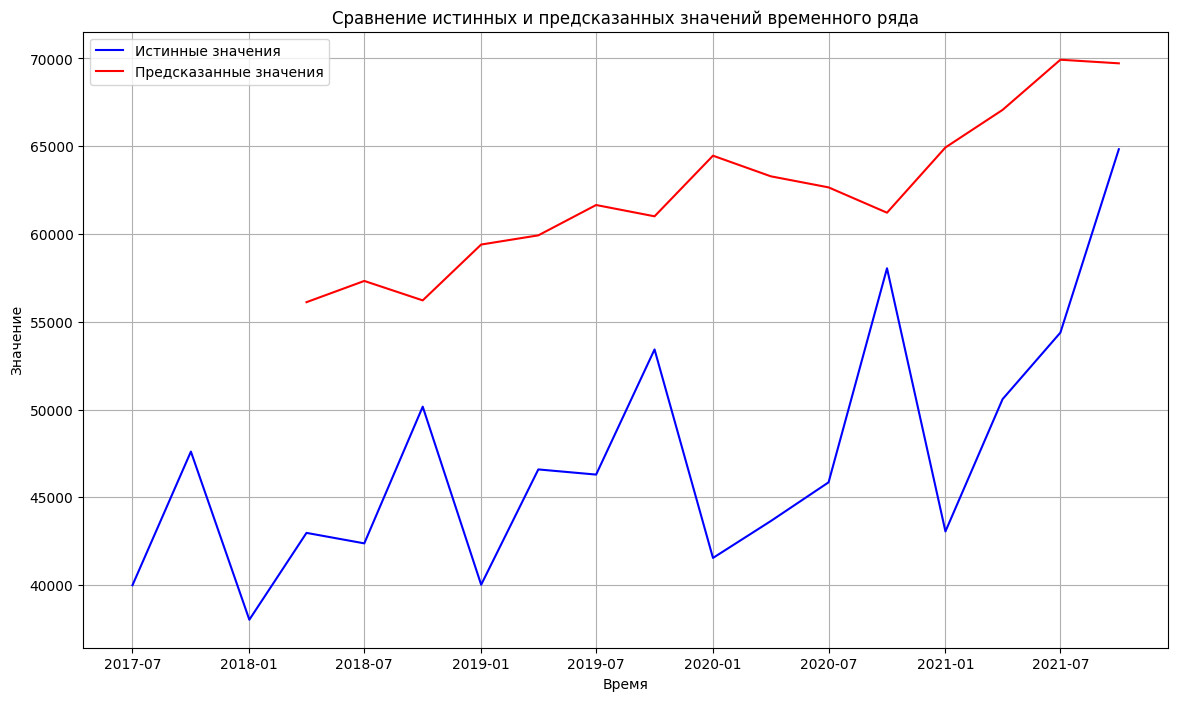

[I 2024-10-18 10:06:55,125] Trial 41 finished with value: 16160.554729217716 and parameters: {'window_size': 4, 'batch_size': 21, 'shuffle_buffer': 630}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - loss: 25.7233 - mae: 2.5188
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 26.6172 - mae: 4.7975
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 106.8183 - mae: 9.7730
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 55.8458 - mae: 6.9404
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 1.1829 - mae: 0.9223
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 20.6214 - mae: 4.3810
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 29.4294 - mae: 5.2083
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 13.3866 - mae: 3.4581
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.8306 - mae: 0.8375
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 1.7437 - mae: 1.2819
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 6.4228 - mae: 2.4678
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 6.6458 - mae: 2.5225
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98

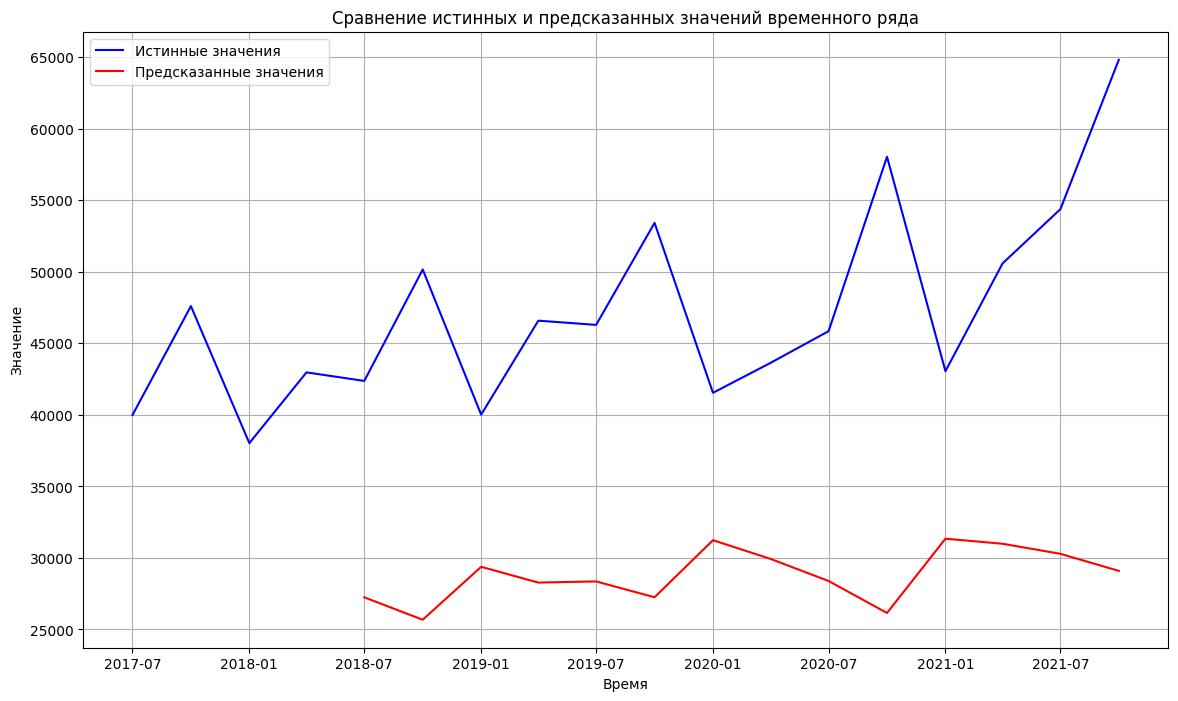

[I 2024-10-18 10:07:12,709] Trial 42 finished with value: 21012.6367238993 and parameters: {'window_size': 5, 'batch_size': 22, 'shuffle_buffer': 739}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 44.7178 - mae: 3.4946
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 15.7226 - mae: 3.7395
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 69.9450 - mae: 7.8750
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 31.7844 - mae: 5.1805
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.2411 - mae: 0.8245
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 15.8181 - mae: 3.8328
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 19.7212 - mae: 4.2419
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 6.5174 - mae: 2.4047
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.3311 - mae: 0.5209
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 2.0174 - mae: 1.3581
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 5.0481 - mae: 2.1806
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 4.4846 - mae: 2.0462
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/

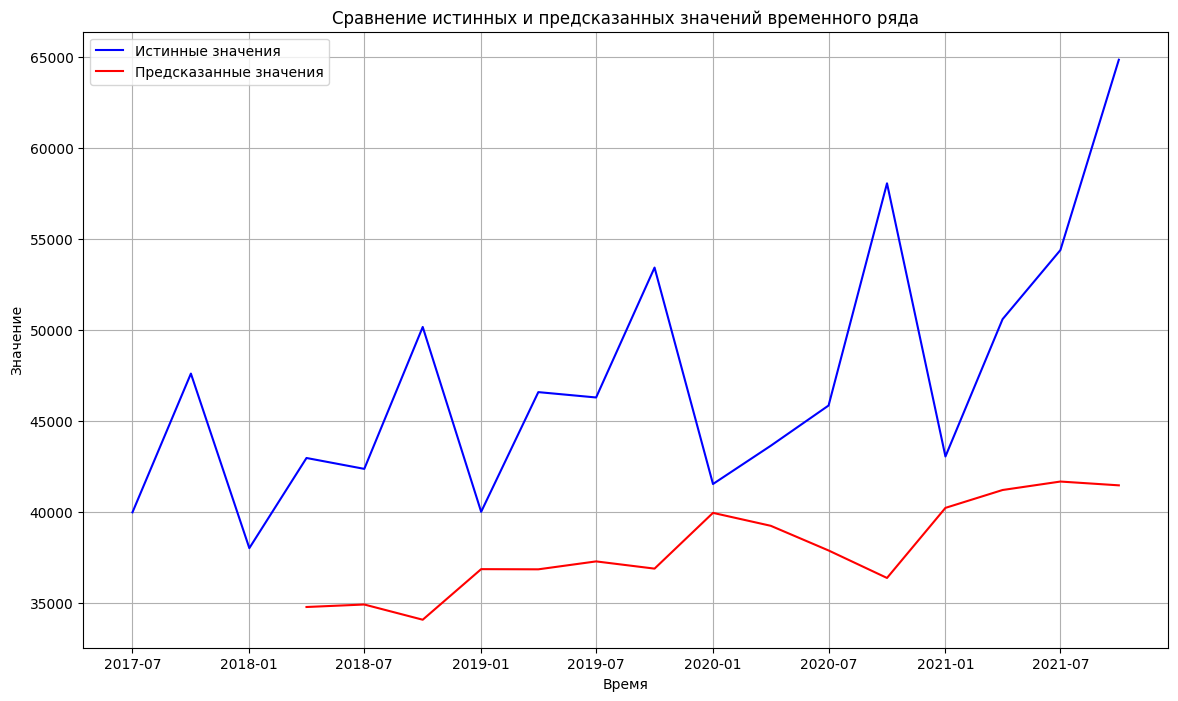

[I 2024-10-18 10:07:29,670] Trial 43 finished with value: 12510.403314015803 and parameters: {'window_size': 4, 'batch_size': 18, 'shuffle_buffer': 801}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.5213 - mae: 0.5802
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 190.2213 - mae: 13.0828
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 26.3532 - mae: 4.8816
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 7.1861 - mae: 2.5176
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 50.4379 - mae: 6.7055
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 63.0473 - mae: 7.4723
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 37.9743 - mae: 5.7790
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 13.1365 - mae: 3.3461
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.8050 - mae: 0.6932
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 2.7927 - mae: 1.6241
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 11.7857 - mae: 3.3148
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 17.8349 - mae: 4.0688
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24

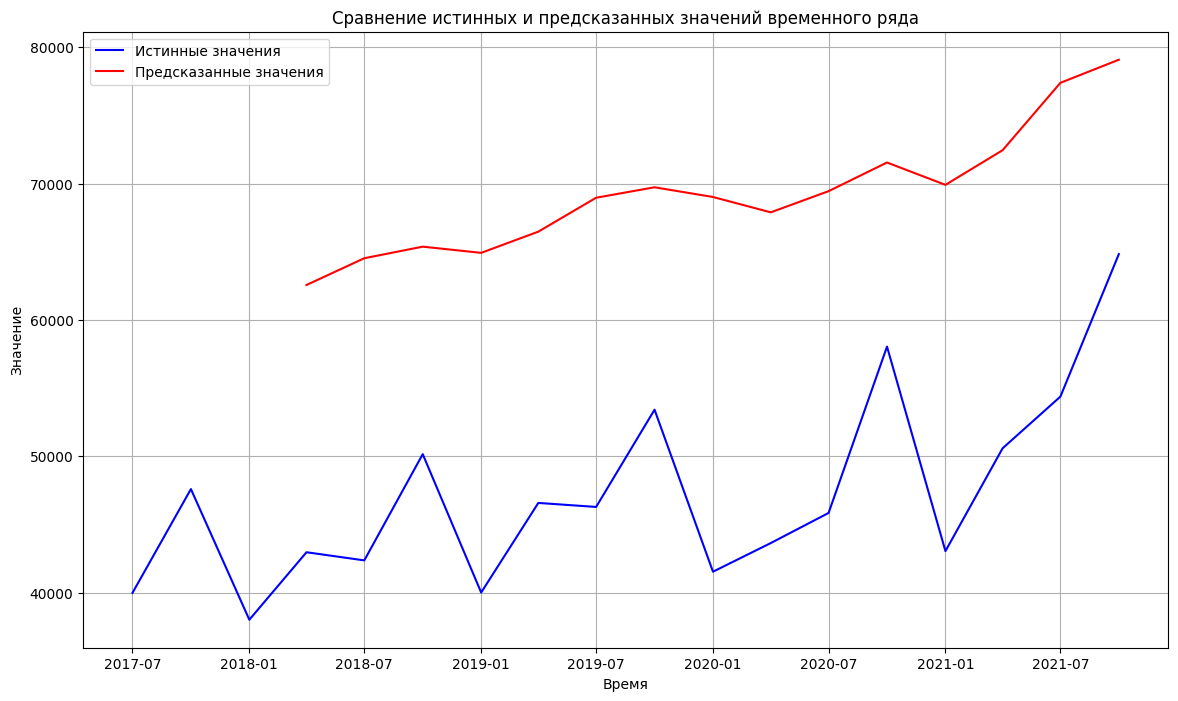

[I 2024-10-18 10:07:46,167] Trial 44 finished with value: 22515.344688596593 and parameters: {'window_size': 4, 'batch_size': 27, 'shuffle_buffer': 878}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - loss: 14.9157 - mae: 2.0798
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 6.8135 - mae: 2.4431
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 31.7427 - mae: 5.3203
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 12.4783 - mae: 3.1903
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 1.0199 - mae: 0.7165
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 8.8541 - mae: 2.8473
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 6.8757 - mae: 2.4859
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1.3108 - mae: 0.9912
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.5188 - mae: 0.6185
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 2.4828 - mae: 1.5330
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 2.6560 - mae: 1.5805
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.0424 - mae: 0.9783
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - los

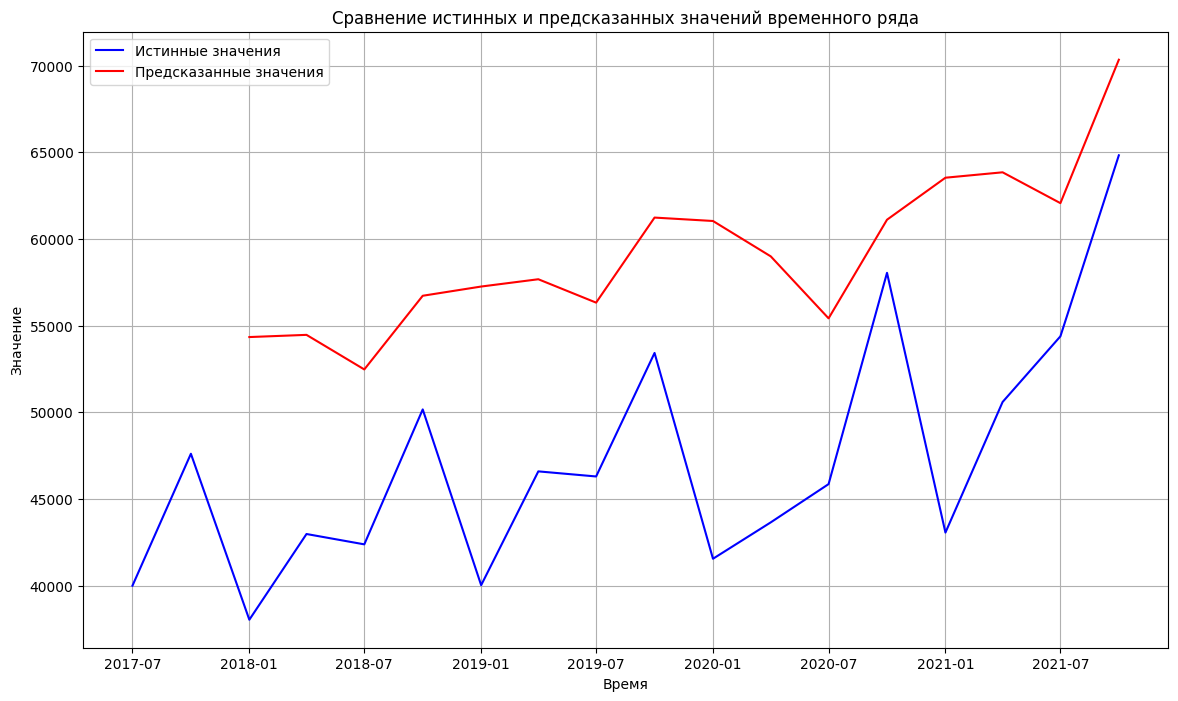

[I 2024-10-18 10:08:10,822] Trial 45 finished with value: 14205.100082770065 and parameters: {'window_size': 3, 'batch_size': 20, 'shuffle_buffer': 715}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.1984 - mae: 0.3835
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 88.0800 - mae: 9.1392
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 40.5479 - mae: 5.7373
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 58.0048 - mae: 6.9546
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 7.9329 - mae: 2.4190
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 4.8142 - mae: 2.1349
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 22.2333 - mae: 4.6410
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 22.4369 - mae: 4.6372
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 9.4714 - mae: 3.0069
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.3602 - mae: 0.5390
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 2.8812 - mae: 1.5011
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 8.9943 - mae: 2.7902
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/s

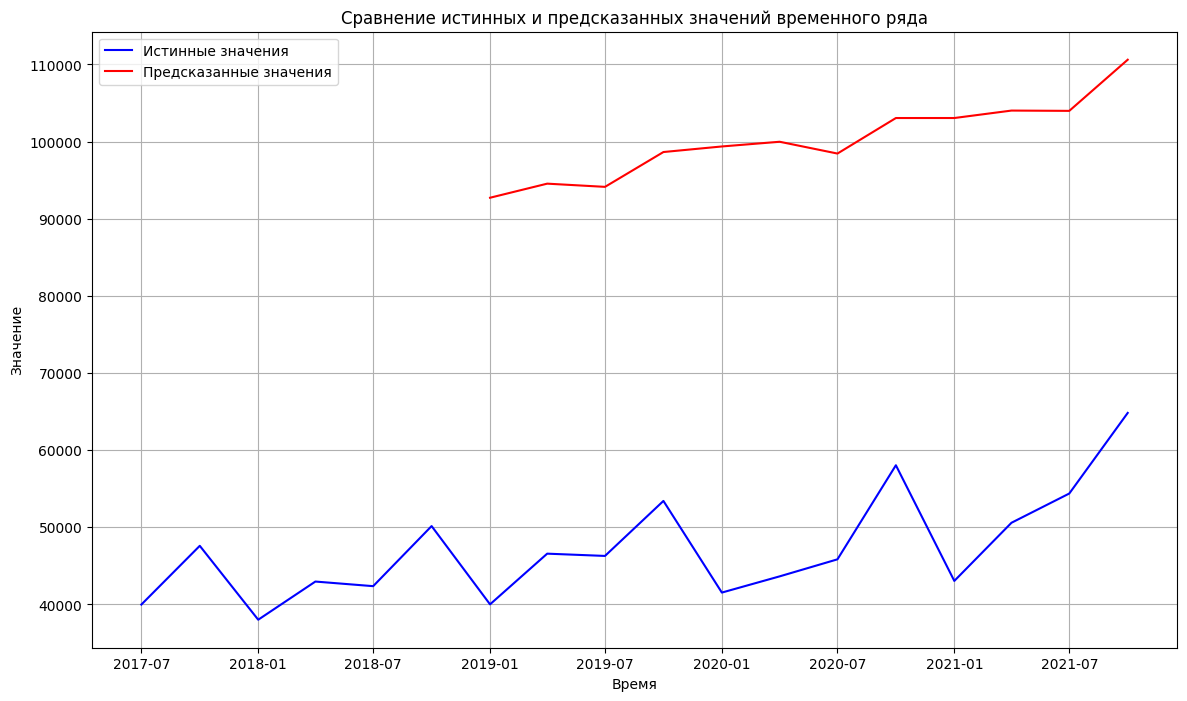

[I 2024-10-18 10:08:27,570] Trial 46 finished with value: 51908.43463482077 and parameters: {'window_size': 7, 'batch_size': 23, 'shuffle_buffer': 812}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 100.3690 - mae: 4.6163
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 56.9922 - mae: 7.1760
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 138.0063 - mae: 11.2085
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 55.6187 - mae: 6.9430
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 2.7497 - mae: 1.0319
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 34.1728 - mae: 5.6835
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 27.5546 - mae: 5.0738
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 5.1404 - mae: 2.1033
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.7301 - mae: 0.7302
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 7.3180 - mae: 2.6332
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 9.0333 - mae: 2.9253
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 6.4750 - mae: 2.4598
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 

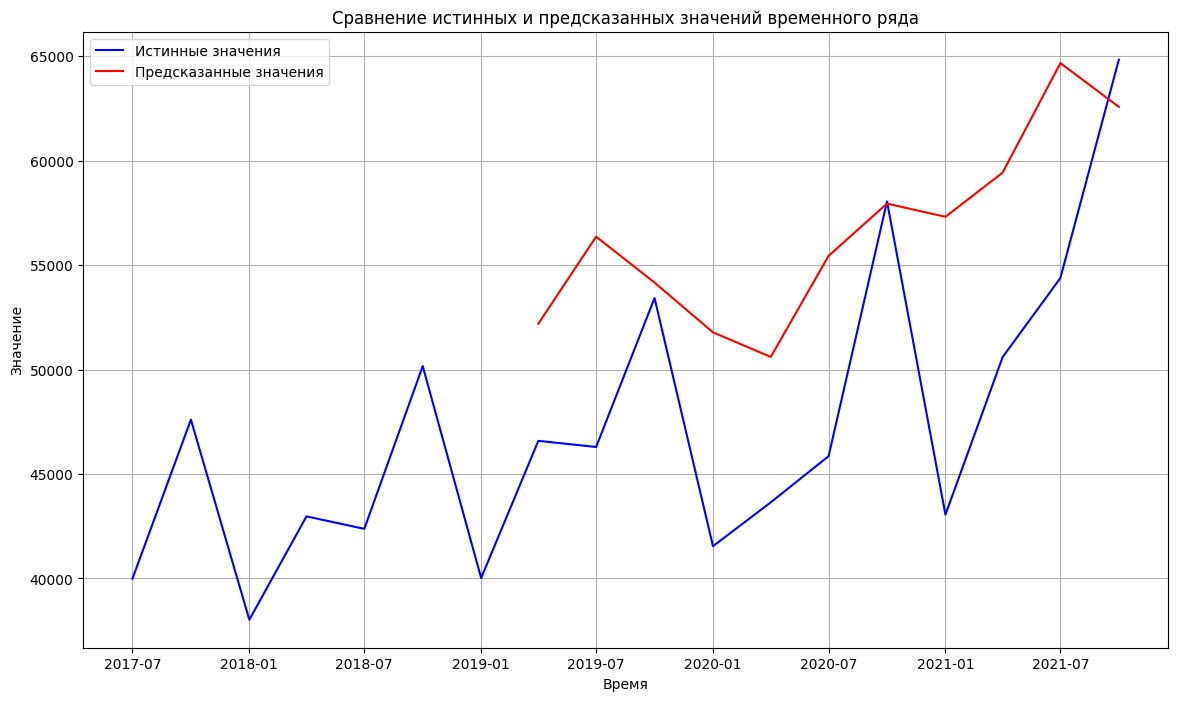

[I 2024-10-18 10:08:48,136] Trial 47 finished with value: 10513.786956284503 and parameters: {'window_size': 8, 'batch_size': 17, 'shuffle_buffer': 987}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.1340 - mae: 0.3011
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 115.0567 - mae: 10.0603
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 14.5302 - mae: 3.5636
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 4.9732 - mae: 2.1112
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 34.3695 - mae: 5.5470
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 40.8506 - mae: 6.0395
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 26.7062 - mae: 4.8428
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 8.9485 - mae: 2.7974
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.6061 - mae: 0.6516
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 1.8058 - mae: 1.2857
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 8.1487 - mae: 2.7307
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 12.2453 - mae: 3.3516
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153m

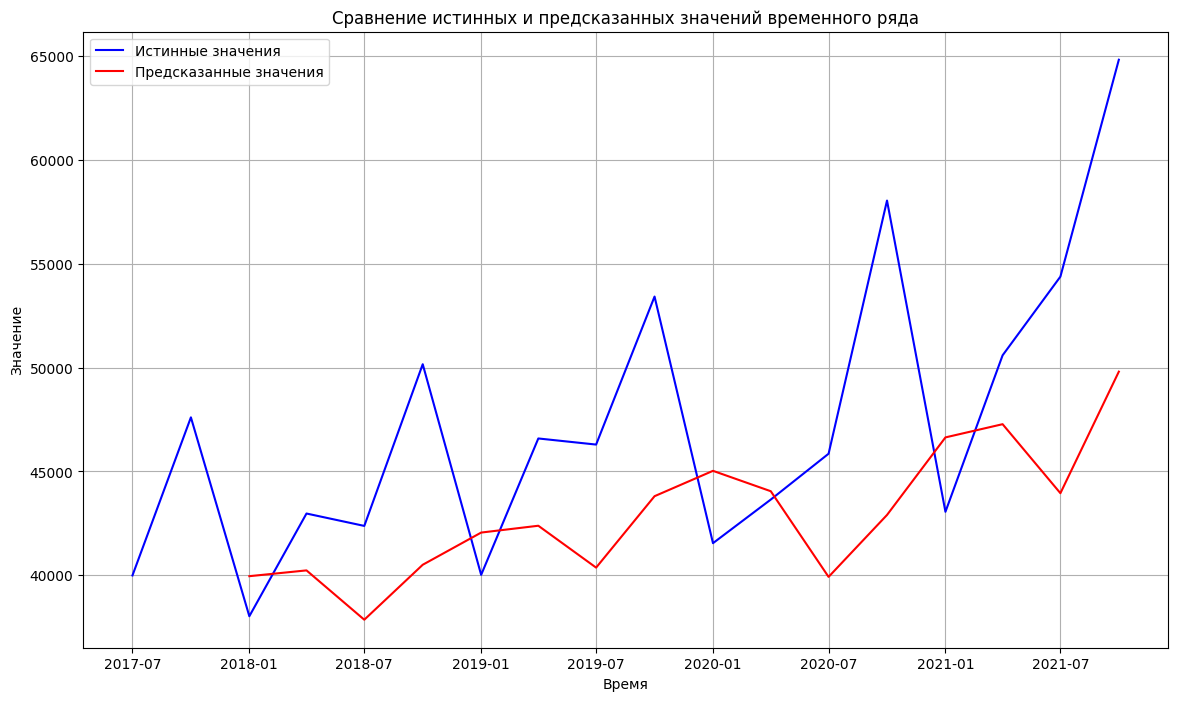

[I 2024-10-18 10:09:03,039] Trial 48 finished with value: 8951.549477468117 and parameters: {'window_size': 3, 'batch_size': 60, 'shuffle_buffer': 781}. Best is trial 31 with value: 7379.017318289346.


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.2396 - mae: 0.3878
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 201.6052 - mae: 13.4923
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.3682 - mae: 0.4971
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 93.9484 - mae: 9.2005
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 94.2513 - mae: 9.2342
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 36.8937 - mae: 5.7033
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 2.4399 - mae: 1.3854
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 5.5438 - mae: 2.2546
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 22.3060 - mae: 4.5355
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 29.9833 - mae: 5.2498
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 24.2626 - mae: 4.7139
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 13.7916 - mae: 3.5190
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20

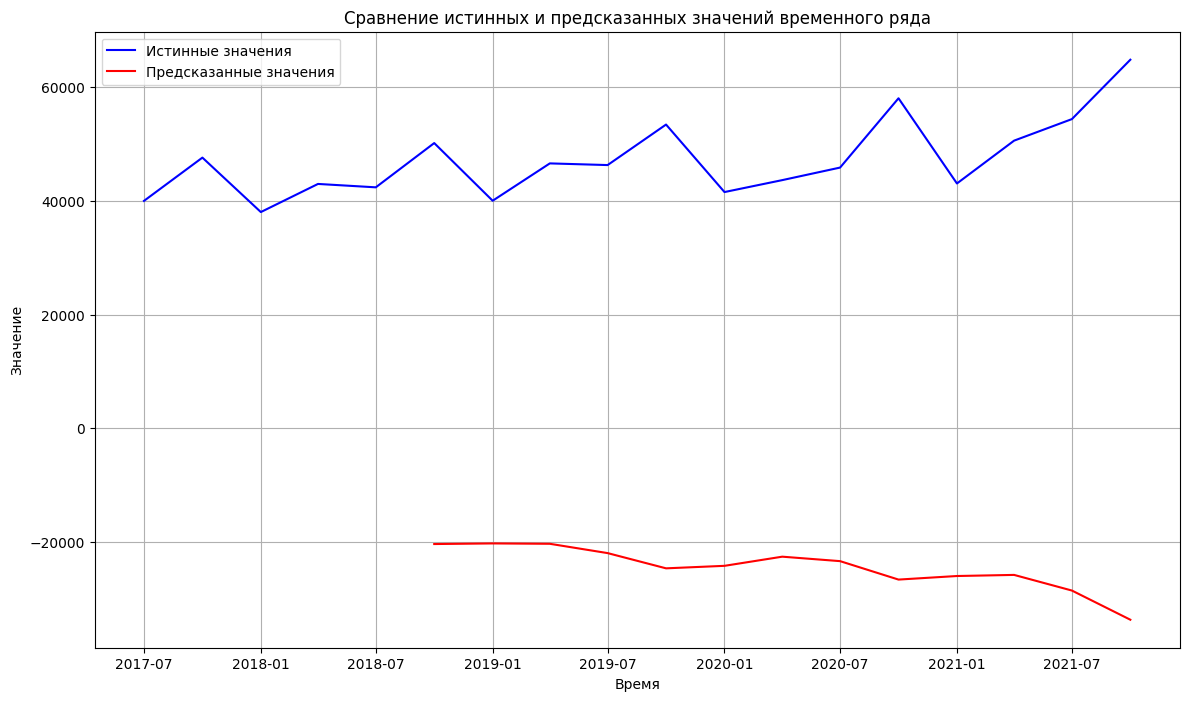

[I 2024-10-18 10:09:18,749] Trial 49 finished with value: 74029.13245418732 and parameters: {'window_size': 6, 'batch_size': 61, 'shuffle_buffer': 779}. Best is trial 31 with value: 7379.017318289346.


Лучшие параметры: {'window_size': 4, 'batch_size': 16, 'shuffle_buffer': 759}


In [ ]:
import optuna

def objective(trial):
    # Предложение значений гиперпараметров
    window_size = trial.suggest_int('window_size', 3, 10)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    shuffle_buffer = trial.suggest_int('shuffle_buffer', 100, 1000)

    # Запуск пайплайна с текущими гиперпараметрами
    metrics = run_pipeline(df, 'srd(cfo)', split_time=30, window_size=window_size,
                           batch_size=batch_size, shuffle_buffer=shuffle_buffer, epochs=25)

    # Возвращаем метрику для минимизации, например, RMSE
    return metrics['RMSE']

# Создание объекта для оптимизации
study = optuna.create_study(direction='minimize')

# Запуск оптимизации с 50 испытаниями
study.optimize(objective, n_trials=50)

# Получение лучших параметров
best_params = study.best_params

print("Лучшие параметры:", best_params)


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 52.8137 - mae: 3.7384
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 18.4162 - mae: 4.0635
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 74.3021 - mae: 8.1704
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 23.5608 - mae: 4.4464
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 1.3726 - mae: 0.7631
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 17.4957 - mae: 4.0042
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 17.0144 - mae: 3.9020
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 4.3100 - mae: 1.8776
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.2776 - mae: 0.3744
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 3.6336 - mae: 1.8400
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 5.8245 - mae: 2.3368
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 4.2356 - mae: 1.9900
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/

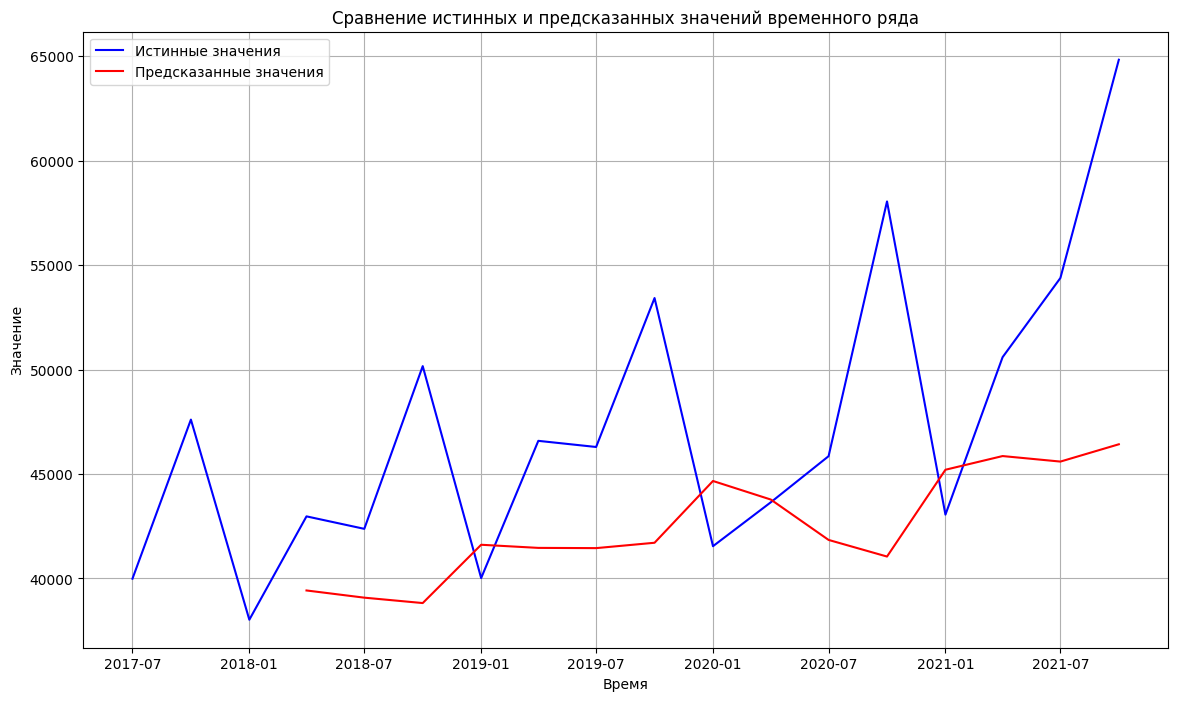

{'RMSE': 9169.964862102292,
 'MAE': 6766.195503472222,
 'MAPE': 12.798018290734813}

In [ ]:
    # Запуск пайплайна с текущими гиперпараметрами
run_pipeline(df, 'srd(cfo)', split_time=30, window_size=4,
                           batch_size=16, shuffle_buffer=759, epochs=25)

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 3.9649 - mae: 1.8039
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 990.2675 - mae: 30.2432
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 137.7831 - mae: 11.2082
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - loss: 17.8624 - mae: 4.0454
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 156.7595 - mae: 12.0777
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 198.9380 - mae: 13.5274
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 136.1684 - mae: 11.2348
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 62.0224 - mae: 7.5480
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 13.3436 - mae: 3.4741
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.2918 - mae: 0.4561
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 12.6611 - mae: 3.4723
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 33.2829 - mae: 5.6358
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━

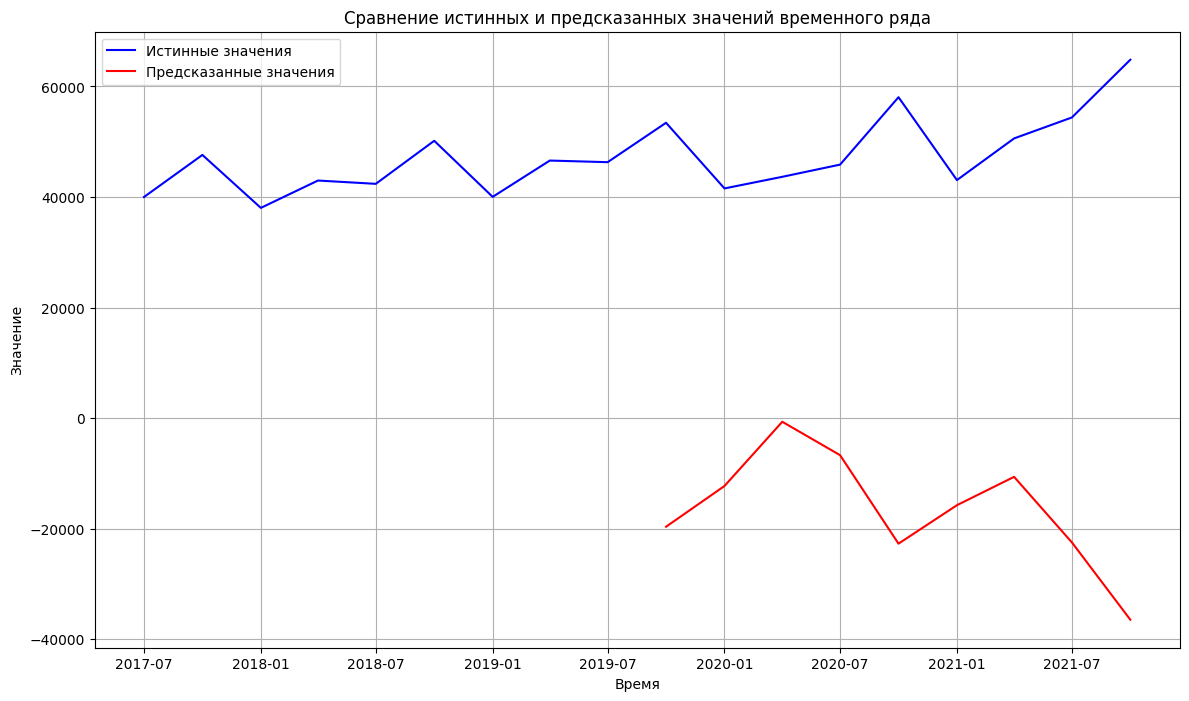

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.2402 - mae: 0.3986
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 332.3041 - mae: 17.2904
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 46.7371 - mae: 6.4748
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 12.3669 - mae: 3.2756
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 84.6982 - mae: 8.6734
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 98.0727 - mae: 9.3375
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 61.7608 - mae: 7.3703
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 21.0941 - mae: 4.2665
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 1.7793 - mae: 1.1328
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 3.4566 - mae: 1.8095
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 15.9194 - mae: 3.8526
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 25.0094 - mae: 4.8161
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

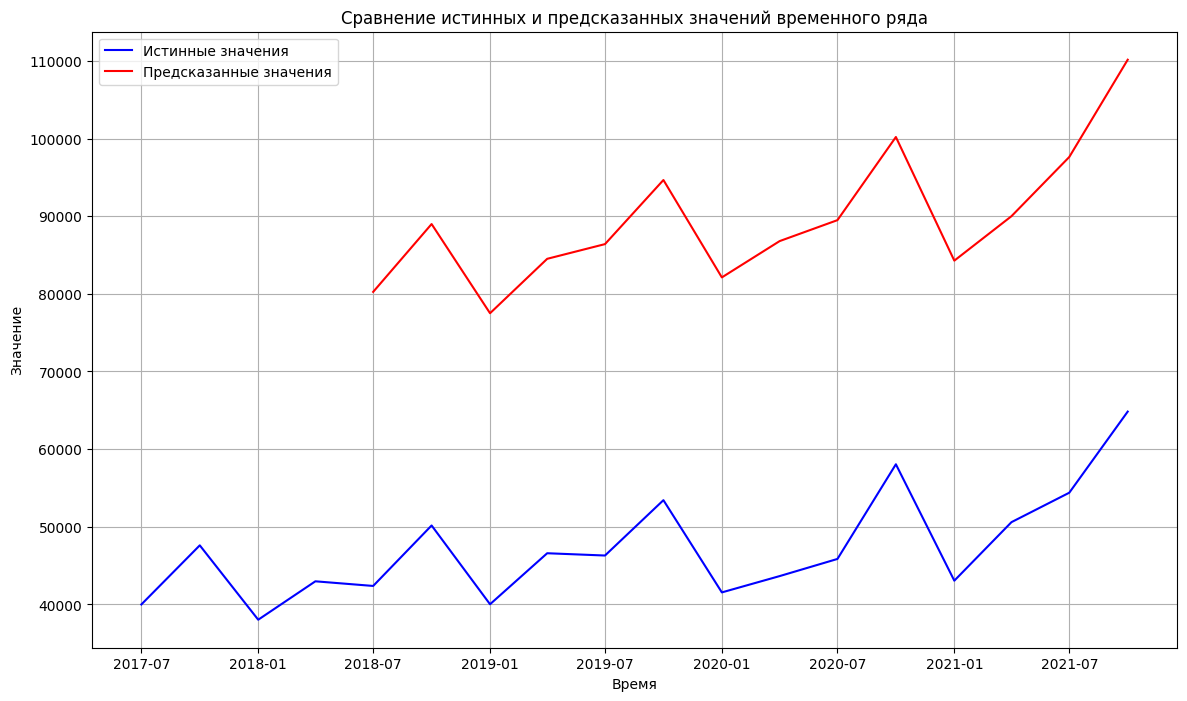

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.2871 - mae: 0.4235
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 603.7387 - mae: 23.3850
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 82.2663 - mae: 8.6582
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 13.8278 - mae: 3.5041
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 125.2998 - mae: 10.6537
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 147.3845 - mae: 11.5239
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 98.6024 - mae: 9.3805
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 38.8632 - mae: 5.8393
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 4.9722 - mae: 1.9250
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 3.0126 - mae: 1.6937
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 18.8950 - mae: 4.2554
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 35.3286 - mae: 5.7810
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 

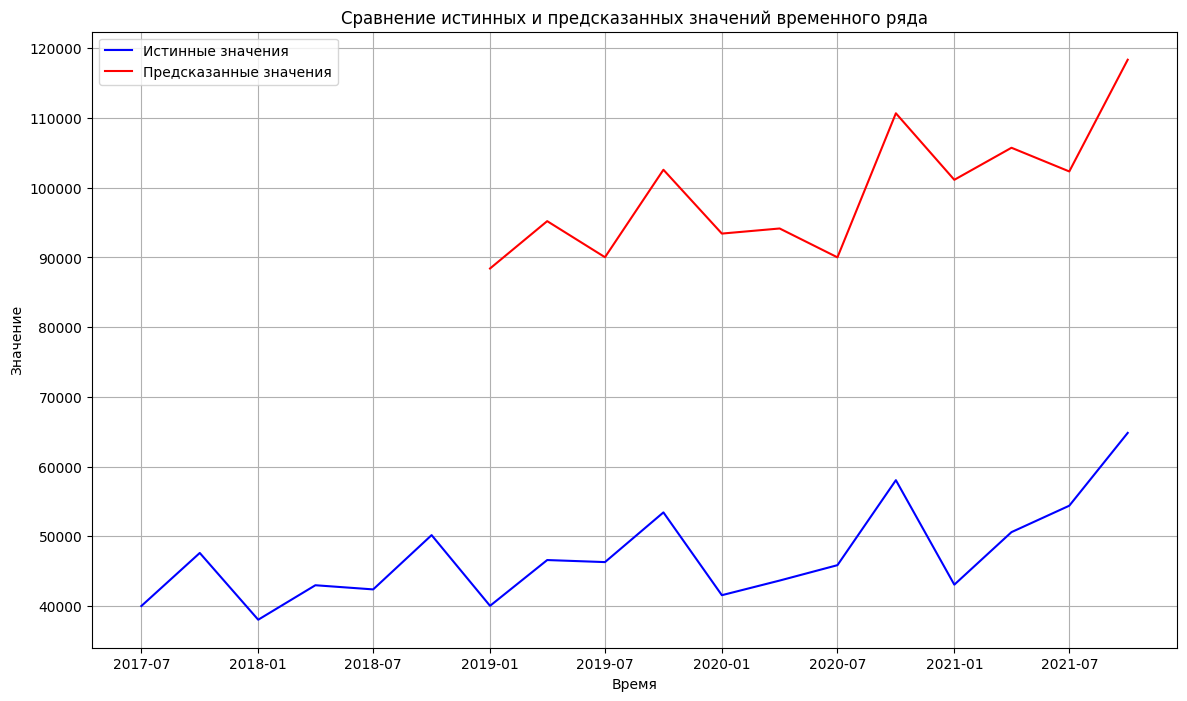

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 17.2669 - mae: 3.9231
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 492.6816 - mae: 21.0956
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 77.2793 - mae: 8.3330
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 8.2202 - mae: 2.6965
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 90.0775 - mae: 9.0316
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 115.8027 - mae: 10.2022
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 83.0027 - mae: 8.6280
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 34.8265 - mae: 5.5705
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 6.6180 - mae: 2.3248
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 0.9108 - mae: 0.9379
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 12.0000 - mae: 3.3826
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 24.4709 - mae: 4.8226
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

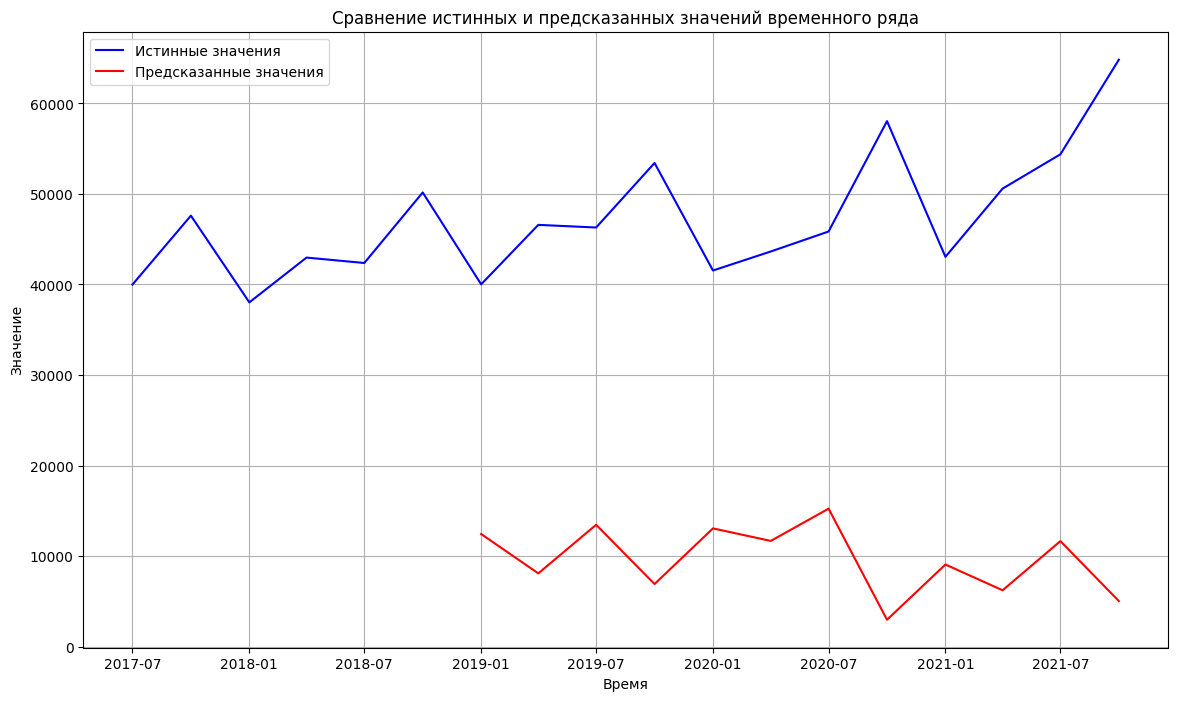

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.0596 - mae: 0.1949
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 15.0482 - mae: 3.3854
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 8.2013 - mae: 2.8349
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 11.2705 - mae: 3.2965
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 1.6045 - mae: 1.2272
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 2.5416 - mae: 1.3054
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 6.9254 - mae: 2.2728
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 4.1867 - mae: 1.7895
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.6887 - mae: 0.6736
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.6589 - mae: 0.7763
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 3.0423 - mae: 1.6909
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 3.1409 - mae: 1.7087
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step 

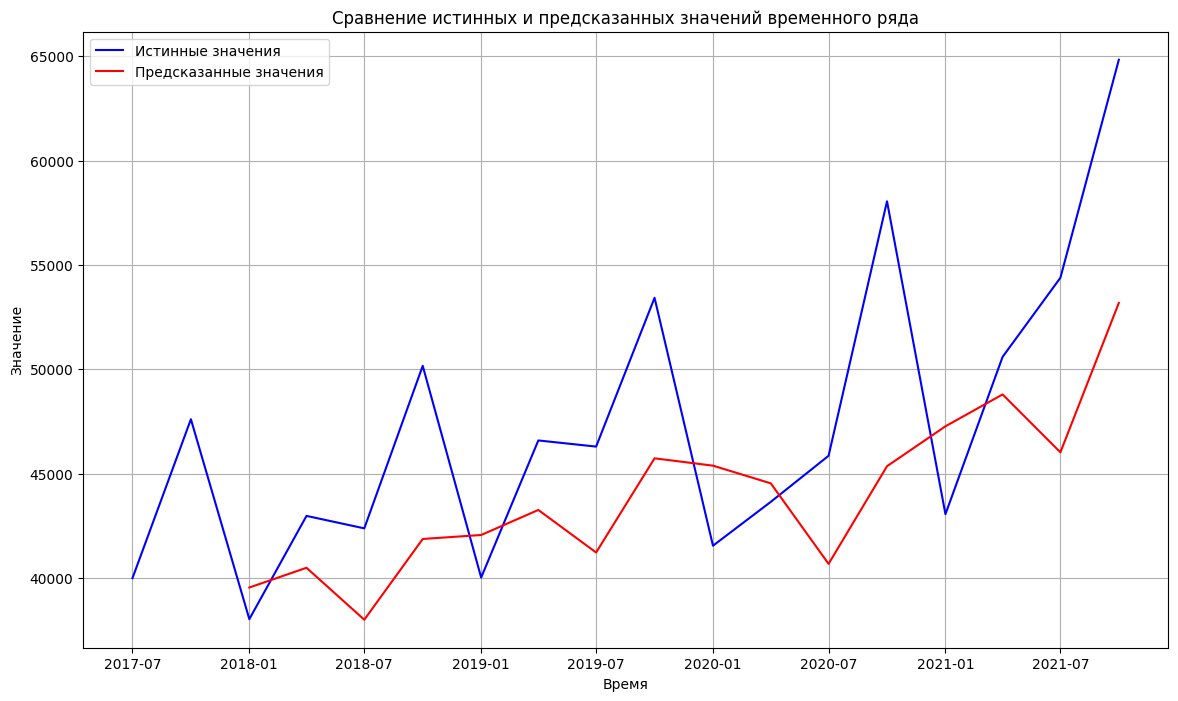

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 8.2741 - mae: 2.6900
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 1159.2568 - mae: 32.7179
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 158.6710 - mae: 12.0999
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 19.5182 - mae: 4.1712
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 186.8076 - mae: 13.0747
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 226.6005 - mae: 14.4388
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 156.0611 - mae: 11.9444
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 64.9283 - mae: 7.6699
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - loss: 10.2542 - mae: 2.9340
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 1.6531 - mae: 1.2163
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 22.2487 - mae: 4.6561
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 46.6445 - mae: 6.6879
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━

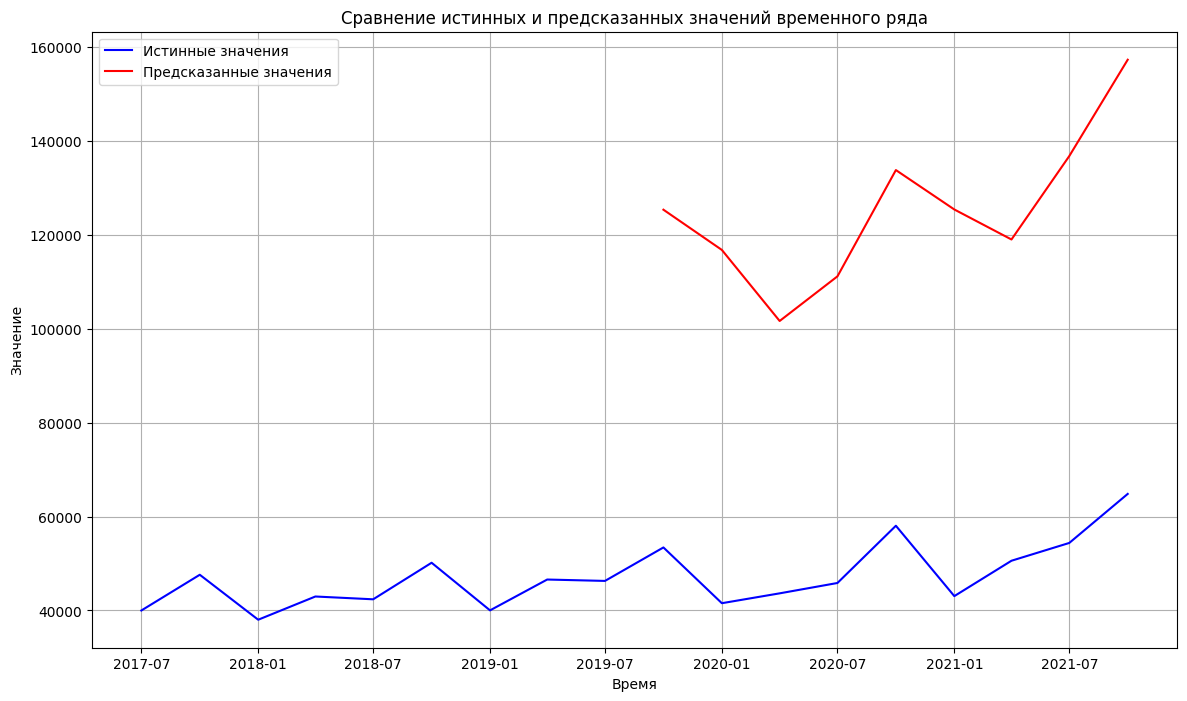

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.6074 - mae: 0.6641
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 295.7606 - mae: 16.2895
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 40.7711 - mae: 6.0149
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 9.9979 - mae: 3.0034
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 73.4854 - mae: 8.1223
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 87.0472 - mae: 8.8301
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 58.1705 - mae: 7.2143
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 22.9368 - mae: 4.4887
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 3.2016 - mae: 1.6065
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 1.0591 - mae: 0.9836
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 9.3621 - mae: 2.9697
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 18.4282 - mae: 4.1465
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221

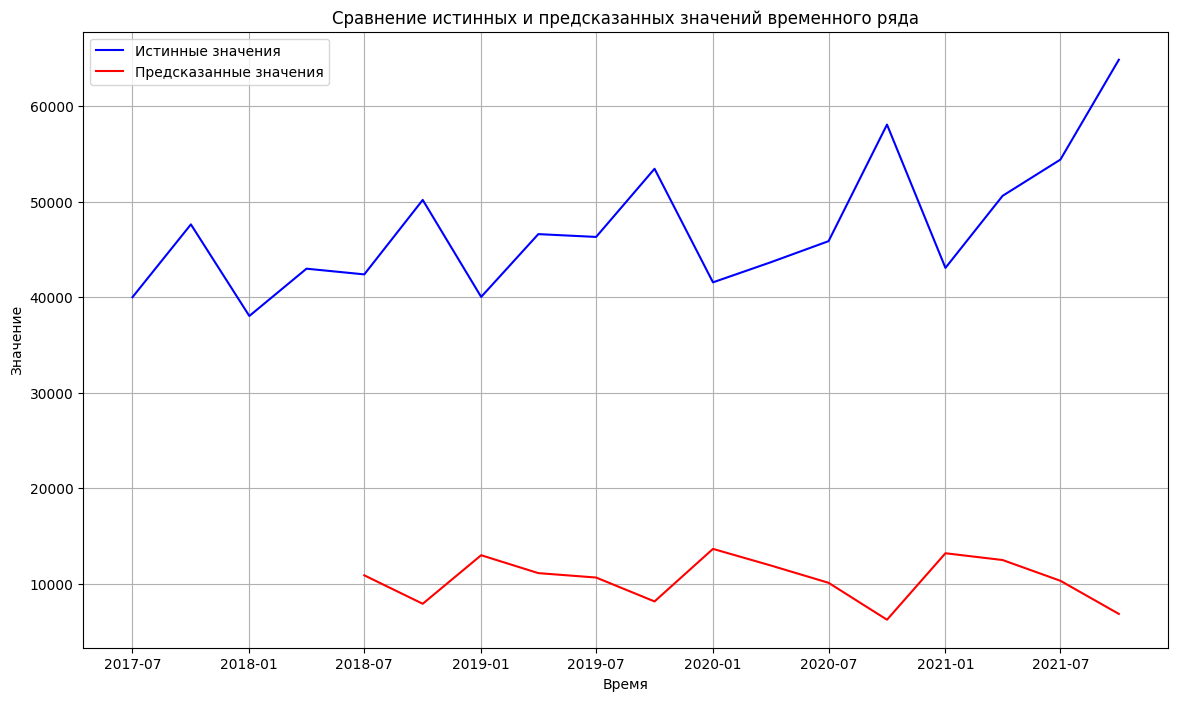

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.2390 - mae: 0.4172
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 100.4536 - mae: 9.4948
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 14.1706 - mae: 3.5659
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 4.9163 - mae: 2.0329
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 33.4953 - mae: 5.4068
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 35.8215 - mae: 5.6074
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 21.4469 - mae: 4.3090
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 5.6281 - mae: 2.1471
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.1371 - mae: 0.2825
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 3.7393 - mae: 1.8673
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 9.4405 - mae: 2.9537
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 12.0618 - mae: 3.3280
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms

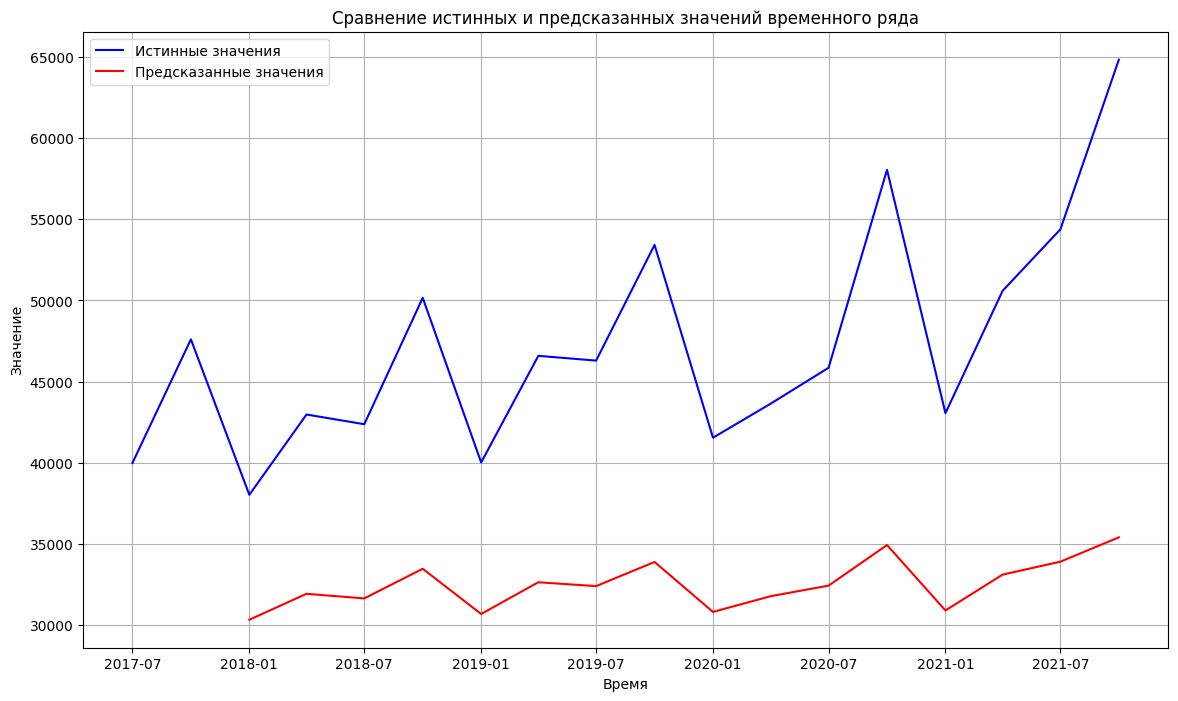

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 26.8397 - mae: 3.1343
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 7.4744 - mae: 2.5887
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 36.5596 - mae: 5.6682
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 17.4128 - mae: 3.7628
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.9352 - mae: 0.7105
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 8.8047 - mae: 2.8798
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 8.8900 - mae: 2.8860
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 2.5391 - mae: 1.4669
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1929 - mae: 0.3397
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.4267 - mae: 1.4972
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 3.4007 - mae: 1.7736
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 2.3440 - mae: 1.4572
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - 

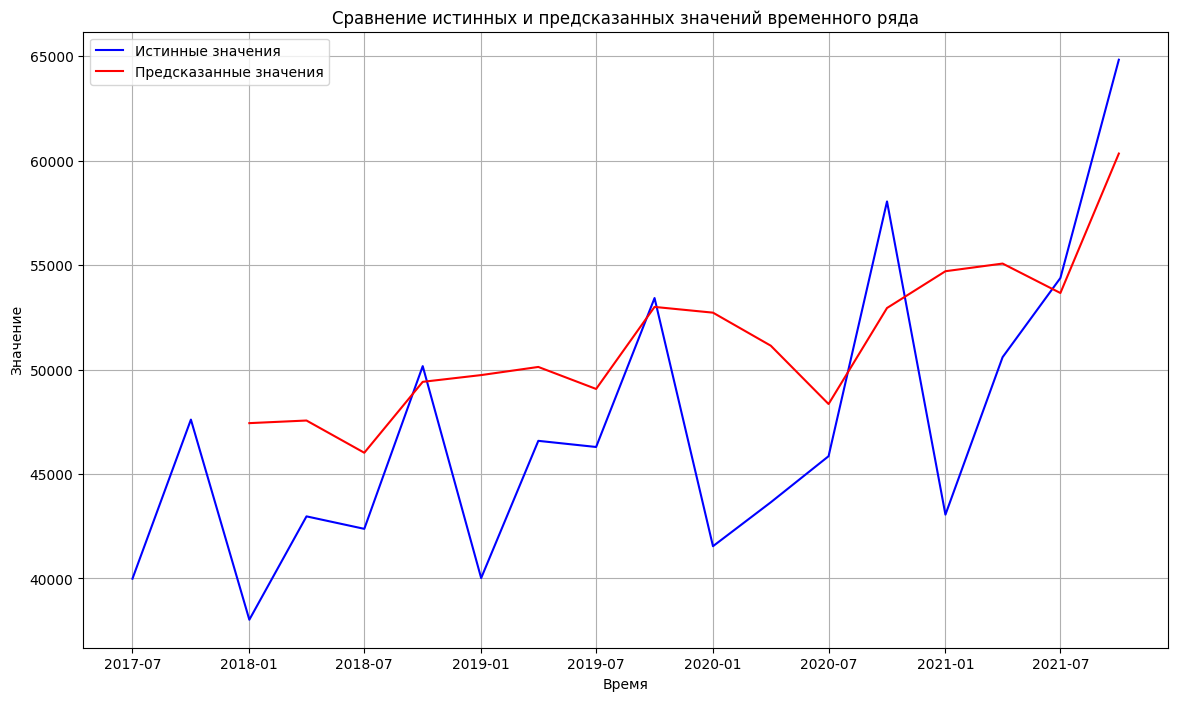

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.1492 - mae: 0.3124
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 346.7866 - mae: 17.5783
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 46.6044 - mae: 6.4147
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 11.6079 - mae: 3.2320
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 87.3380 - mae: 8.8484
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 108.5212 - mae: 9.8447
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 71.3797 - mae: 7.9851
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 28.8491 - mae: 5.0237
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 4.5736 - mae: 1.9438
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.6892 - mae: 0.7944
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 9.8737 - mae: 3.0388
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 20.2344 - mae: 4.3365
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

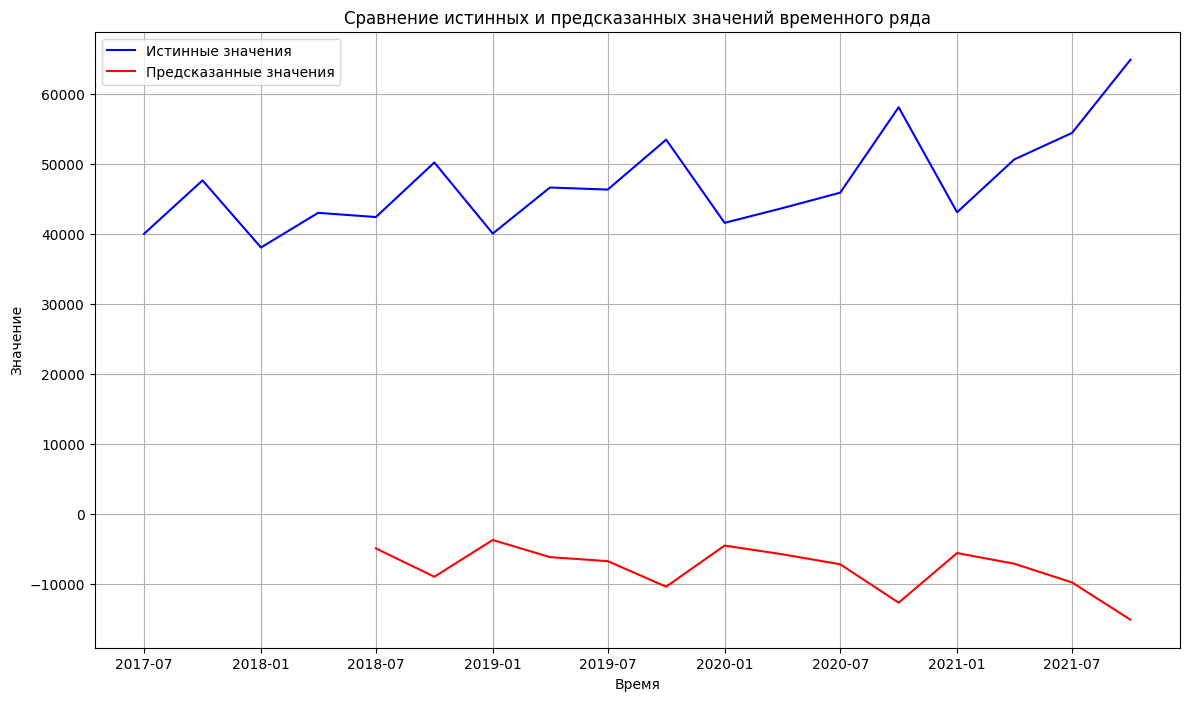

In [ ]:
from sklearn.model_selection import ParameterSampler

param_dist = {
    'window_size': [3, 5, 7, 10],
    'batch_size': [16, 32, 64],
    'shuffle_buffer': [100, 500, 1000]
}

random_params = list(ParameterSampler(param_dist, n_iter=10, random_state=42))

for params in random_params:
    window_size = params['window_size']
    batch_size = params['batch_size']
    shuffle_buffer = params['shuffle_buffer']
    # Запуск пайплайна с текущими параметрами
    metrics = run_pipeline(df,
                       series_name='srd(cfo)',
                       split_time=30,
                       window_size=window_size,
                       batch_size=batch_size,
                       shuffle_buffer=shuffle_buffer,
                       epochs=25)
    # Сохраняйте и анализируйте результаты

In [ ]:
# from kerastuner.tuners import RandomSearch

# def build_model(hp):
#     model = tf.keras.models.Sequential([
#         tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp.Int('lstm_units1', min_value=128, max_value=512, step=64), return_sequences=True)),
#         tf.keras.layers.Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp.Int('lstm_units2', min_value=128, max_value=512, step=64))),
#         tf.keras.layers.Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)),
#         tf.keras.layers.Dense(1),
#         tf.keras.layers.Lambda(lambda x: x * 100.0)
#     ])

#     model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mae'])
#     return model

# tuner = RandomSearch(
#     build_model,
#     objective='val_loss',
#     max_trials=10,
#     executions_per_trial=1,
#     directory='my_dir',
#     project_name='time_series_tuning'
# )

# tuner.search(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid))
